<a href="https://colab.research.google.com/github/Luke-Williams-01/Luke-Williams-01/blob/main/ICRARproject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy import integrate
from scipy import stats, interpolate
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
import pandas as pd

1) Cross-matching the xCOLDGASS sample with the xGASS galaxies to investigate the molecular hydrogen, H2 in the galaxy. This is in the optical region of a galaxy and therefore will not require the process used for HI.

In [2]:
hdulist = fits.open('xGASSCOLD_matched_inclHI&env.fits')
hdu = hdulist[1].data
cols = hdulist[1].columns
# Importing data into arrays
GASS = hdu['GASS']
RA = hdu['RA_1']
DEC = hdu['DEC_1']
FLAG_CO = hdu['FLAG_CO']
lgMH2 = hdu['LOGMH2']
limlgMH2 = hdu['LIM_LOGMH2']
lgMH2_2_Ms = hdu['LOGMH2MS']
lgMSTAR = hdu['LOGMSTAR']
SFRbest = hdu['SFR_best']
NUVr = hdu['NUVr_1']
lgMuST = hdu['lgmust']
lgMHI_in = hdu['lgMHI_2Reff']
lgMHI_gl = hdu['lgMHI_global']
B2TM = hdu['B2T_M']
HIsrc = hdu['HIsource']
Cluster = hdu['env_code_B']
Ngal = hdu['Ngal_B']
Reff_kpc = hdu['2Reff_kpc']
R90_kpc = hdu['r90_kpc']
lgSFRbest = np.log10(SFRbest)
lgsSFR = np.log10((SFRbest) / (10**lgMSTAR))
print('Starting length of the dataset is', len(FLAG_CO))

Starting length of the dataset is 372


In [3]:
# Checking whether any of the galaxies in the dataset are missing important values
print('Data without H2 mass values:', np.where((lgMH2 < 0) & (limlgMH2 < 0))[0], np.where(np.isnan(lgMH2))[0], np.where(np.isnan(limlgMH2))[0])
print('Data without stellar mass values:', np.where(lgMSTAR < 0)[0], np.where(np.isnan(lgMSTAR))[0])
print('Data without NUV-r values:', np.where(NUVr < 0)[0], np.where(np.isnan(NUVr))[0])
print('Data without stellar mass density values:', np.where(lgMuST < 0)[0], np.where(np.isnan(lgMuST))[0])

Data without H2 mass values: [] [] []
Data without stellar mass values: [] []
Data without NUV-r values: [] []
Data without stellar mass density values: [] []


In [4]:
# Need to separate the H2 data into the detections and the non-detection upper limits
# We can use the CO flag for this, 1 = H2 detection, 2 = no H2 detection (upper limit only)
# H2 detections
lgMH2_det = np.delete(lgMH2, (np.where(FLAG_CO > 1)))
lgMSTAR_det = np.delete(lgMSTAR, (np.where(FLAG_CO > 1)))
lgSFRbest_det = np.delete(lgSFRbest, (np.where(FLAG_CO > 1)))
NUVr_det = np.delete(NUVr, (np.where(FLAG_CO > 1)))
lgMuST_det = np.delete(lgMuST, (np.where(FLAG_CO > 1)))
lgsSFR_det = np.delete(lgsSFR, (np.where(FLAG_CO > 1)))
lgMHI_in_det = np.delete(lgMHI_in, (np.where(FLAG_CO > 1)))
lgMHI_gl_det = np.delete(lgMHI_gl, (np.where(FLAG_CO > 1)))
# H2 non-detections
limlgMH2_ndet = np.delete(limlgMH2, (np.where(FLAG_CO < 2)))
lgMSTAR_ndet = np.delete(lgMSTAR, (np.where(FLAG_CO < 2)))
lgSFRbest_ndet = np.delete(lgSFRbest, (np.where(FLAG_CO < 2)))
NUVr_ndet = np.delete(NUVr, (np.where(FLAG_CO < 2)))
lgMuST_ndet = np.delete(lgMuST, (np.where(FLAG_CO < 2)))
lgsSFR_ndet = np.delete(lgsSFR, (np.where(FLAG_CO < 2)))
lgMHI_in_ndet = np.delete(lgMHI_in, (np.where(FLAG_CO < 2)))
lgMHI_gl_ndet = np.delete(lgMHI_gl, (np.where(FLAG_CO < 2)))

2) Plotting how the H2 changes with stellar mass and SFR

In [5]:
# Finding the running median of the galaxies for H2
# Arrays for the bins
H2bins = np.linspace(9, 11.9, 10)
H2bins2 = np.linspace(-1.9, 1.5, 10)

# Array of zeroes to store the median of each bin
mH2_1 = np.zeros(len(H2bins))
H2median1 = np.zeros(len(H2bins))
H2MAD1 = np.zeros(len(H2bins))

mH2_2 = np.zeros(len(H2bins2))
H2median2 = np.zeros(len(H2bins2))
H2MAD2 = np.zeros(len(H2bins2))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(H2bins) -1):
  # Median and MAD for H2 of galaxies against stellar mass
  H2median1[i] = np.median(lgMH2_det[np.where((lgMSTAR_det >= H2bins[i]) & (lgMSTAR_det <= H2bins[i+1]))])
  H2MAD1[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgMSTAR_det >= H2bins[i]) & (lgMSTAR_det <= H2bins[i+1]))])
  mH2_1[i] = H2median1[i]

  # Median and MAD for H2 of galaxies against SFR
  H2median2[i] = np.median(lgMH2_det[np.where((lgSFRbest_det >= H2bins2[i]) & (lgSFRbest_det <= H2bins2[i+1]))])
  H2MAD2[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgSFRbest_det >= H2bins2[i]) & (lgSFRbest_det <= H2bins2[i+1]))])
  mH2_2[i] = H2median2[i]

# Working out the upper and lower bounds of the median absolute deviation
H2pMAD1 = mH2_1 + H2MAD1
H2nMAD1 = mH2_1 - H2MAD1
H2pMAD2 = mH2_2 + H2MAD2
H2nMAD2 = mH2_2 - H2MAD2

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


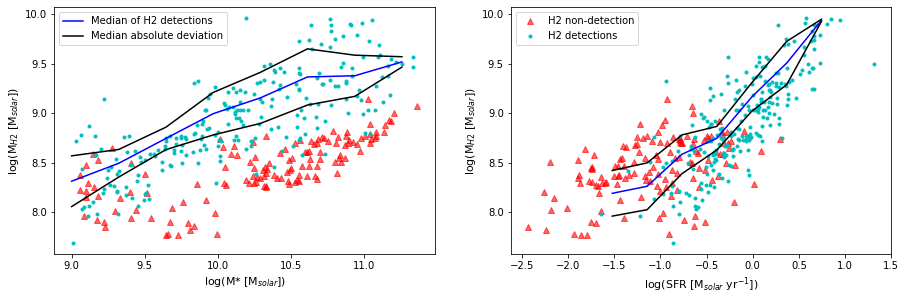

In [6]:
# Plotting the relations between the H2 mass in the galaxy and stellar mass as well as the Star formation rate
plt.figure(figsize = (15,10))
# H2 mass against Stellar mass
plt.subplot(221)
plt.plot(lgMSTAR_ndet, limlgMH2_ndet, 'r^', alpha = 0.6)
plt.plot(lgMSTAR_det, lgMH2_det, 'c.')
plt.plot(H2bins[:-2], mH2_1[:-2], 'b-', label = 'Median of H2 detections')
plt.plot(H2bins[:-2], H2pMAD1[:-2], 'k-', label = 'Median absolute deviation')
plt.plot(H2bins[:-2], H2nMAD1[:-2], 'k-')
plt.xlabel('log(M* [M$_{solar}$])', fontsize=11)
plt.ylabel('log(M$_{H2}$ [M$_{solar}$])', fontsize=11)
plt.legend(loc='upper left')

# H2 mass against Star formation rate
plt.subplot(222)
plt.plot(lgSFRbest_ndet, limlgMH2_ndet, 'r^', alpha = 0.6, label= 'H2 non-detection')
plt.plot(lgSFRbest_det, lgMH2_det, 'c.', label= 'H2 detections')
plt.plot(H2bins2[1:-2], mH2_2[1:-2], 'b-')
plt.plot(H2bins2[1:-2], H2pMAD2[1:-2], 'k-')
plt.plot(H2bins2[1:-2], H2nMAD2[1:-2], 'k-')
plt.xlabel('log(SFR [M$_{solar}$ yr$^{-1}$])', fontsize=11)
plt.ylabel('log(M$_{H2}$ [M$_{solar}$])', fontsize=11)
plt.legend(loc='upper left');

3) Comparing how the H2 mass changes with various stellar properties, plotted with how the global HI mass changes and how the HI mass inside the optical region changes

In [7]:
# Finding the running median of the galaxies in the sample for the HI global
# Arrays for the bins
HIglbins_Mstar = np.linspace(9, 11.5, 10)
HIglbins_NUVr = np.linspace(1, 5.5, 10)
HIglbins_sSFR = np.linspace(-11.5, -9.5, 10)
HIglbins_Must = np.linspace(7.5, 10, 10)

# Array of zeroes to store the median of each bin
MHIgl_Mstar = np.zeros(len(HIglbins_Mstar))
HIglmedian_Mstar = np.zeros(len(HIglbins_Mstar))
HIglMAD_Mstar = np.zeros(len(HIglbins_Mstar))

MHIgl_NUVr = np.zeros(len(HIglbins_NUVr))
HIglmedian_NUVr = np.zeros(len(HIglbins_NUVr))
HIglMAD_NUVr = np.zeros(len(HIglbins_NUVr))

MHIgl_sSFR = np.zeros(len(HIglbins_sSFR))
HIglmedian_sSFR = np.zeros(len(HIglbins_sSFR))
HIglMAD_sSFR = np.zeros(len(HIglbins_sSFR))

MHIgl_Must = np.zeros(len(HIglbins_Must))
HIglmedian_Must = np.zeros(len(HIglbins_Must))
HIglMAD_Must = np.zeros(len(HIglbins_Must))

In [8]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(HIglbins_Mstar) -1):
  # Median and MAD for the Mstar graph
  HIglmedian_Mstar[i] = np.median(lgMHI_gl_det[np.where((lgMSTAR_det >= HIglbins_Mstar[i]) & (lgMSTAR_det <= HIglbins_Mstar[i+1]))])
  HIglMAD_Mstar[i] = stats.median_abs_deviation(lgMHI_gl_det[np.where((lgMSTAR_det >= HIglbins_Mstar[i]) & (lgMSTAR_det <= HIglbins_Mstar[i+1]))])
  MHIgl_Mstar[i] = HIglmedian_Mstar[i]

  # Median and MAD for the NUV-r graph
  HIglmedian_NUVr[i] = np.median(lgMHI_gl_det[np.where((NUVr_det >= HIglbins_NUVr[i]) & (NUVr_det <= HIglbins_NUVr[i+1]))])
  HIglMAD_NUVr[i] = stats.median_abs_deviation(lgMHI_gl_det[np.where((NUVr_det >= HIglbins_NUVr[i]) & (NUVr_det <= HIglbins_NUVr[i+1]))])
  MHIgl_NUVr[i] = HIglmedian_NUVr[i]

  # Median and MAD for the sSFR graph
  HIglmedian_sSFR[i] = np.median(lgMHI_gl_det[np.where((lgsSFR_det >= HIglbins_sSFR[i]) & (lgsSFR_det <= HIglbins_sSFR[i+1]))])
  HIglMAD_sSFR[i] = stats.median_abs_deviation(lgMHI_gl_det[np.where((lgsSFR_det >= HIglbins_sSFR[i]) & (lgsSFR_det <= HIglbins_sSFR[i+1]))])
  MHIgl_sSFR[i] = HIglmedian_sSFR[i]

  #Median and MAD for the Must graph
  HIglmedian_Must[i] = np.median(lgMHI_gl_det[np.where((lgMuST_det >= HIglbins_Must[i]) & (lgMuST_det <= HIglbins_Must[i+1]))])
  HIglMAD_Must[i] = stats.median_abs_deviation(lgMHI_gl_det[np.where((lgMuST_det >= HIglbins_Must[i]) & (lgMuST_det <= HIglbins_Must[i+1]))])
  MHIgl_Must[i] = HIglmedian_Must[i]

# Working out the upper and lower bounds of the median absolute deviation
# Mstar graph median bounds
HIglpMAD_Mstar = MHIgl_Mstar + HIglMAD_Mstar
HIglnMAD_Mstar = MHIgl_Mstar - HIglMAD_Mstar
# NUV-r graph median bounds
HIglpMAD_NUVr = MHIgl_NUVr + HIglMAD_NUVr
HIglnMAD_NUVr = MHIgl_NUVr - HIglMAD_NUVr
# sSFR graph median bounds
HIglpMAD_sSFR = MHIgl_sSFR + HIglMAD_sSFR
HIglnMAD_sSFR = MHIgl_sSFR - HIglMAD_sSFR
# Must graph median bounds
HIglpMAD_Must = MHIgl_Must + HIglMAD_Must
HIglnMAD_Must = MHIgl_Must - HIglMAD_Must

In [9]:
# Finding the running median of the galaxies in the sample for the HI inner
# Arrays for the bins
HIinbins_Mstar = np.linspace(9, 11.5, 10)
HIinbins_NUVr = np.linspace(1, 5.5, 10)
HIinbins_sSFR = np.linspace(-11.5, -9.5, 10)
HIinbins_Must = np.linspace(7.5, 10, 10)

# Array of zeroes to store the median of each bin
MHIin_Mstar = np.zeros(len(HIinbins_Mstar))
HIinmedian_Mstar = np.zeros(len(HIinbins_Mstar))
HIinMAD_Mstar = np.zeros(len(HIinbins_Mstar))

MHIin_NUVr = np.zeros(len(HIinbins_NUVr))
HIinmedian_NUVr = np.zeros(len(HIinbins_NUVr))
HIinMAD_NUVr = np.zeros(len(HIinbins_NUVr))

MHIin_sSFR = np.zeros(len(HIinbins_sSFR))
HIinmedian_sSFR = np.zeros(len(HIinbins_sSFR))
HIinMAD_sSFR = np.zeros(len(HIinbins_sSFR))

MHIin_Must = np.zeros(len(HIinbins_Must))
HIinmedian_Must = np.zeros(len(HIinbins_Must))
HIinMAD_Must = np.zeros(len(HIinbins_Must))

In [10]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(HIinbins_Mstar) -1):
  # Median and MAD for the Mstar graph
  HIinmedian_Mstar[i] = np.median(lgMHI_in_det[np.where((lgMSTAR_det >= HIinbins_Mstar[i]) & (lgMSTAR_det <= HIinbins_Mstar[i+1]))])
  HIinMAD_Mstar[i] = stats.median_abs_deviation(lgMHI_in_det[np.where((lgMSTAR_det >= HIinbins_Mstar[i]) & (lgMSTAR_det <= HIinbins_Mstar[i+1]))])
  MHIin_Mstar[i] = HIinmedian_Mstar[i]

  # Median and MAD for the NUV-r graph
  HIinmedian_NUVr[i] = np.median(lgMHI_in_det[np.where((NUVr_det >= HIinbins_NUVr[i]) & (NUVr_det <= HIinbins_NUVr[i+1]))])
  HIinMAD_NUVr[i] = stats.median_abs_deviation(lgMHI_in_det[np.where((NUVr_det >= HIinbins_NUVr[i]) & (NUVr_det <= HIinbins_NUVr[i+1]))])
  MHIin_NUVr[i] = HIinmedian_NUVr[i]

  # Median and MAD for the sSFR graph
  HIinmedian_sSFR[i] = np.median(lgMHI_in_det[np.where((lgsSFR_det >= HIinbins_sSFR[i]) & (lgsSFR_det <= HIinbins_sSFR[i+1]))])
  HIinMAD_sSFR[i] = stats.median_abs_deviation(lgMHI_in_det[np.where((lgsSFR_det >= HIinbins_sSFR[i]) & (lgsSFR_det <= HIinbins_sSFR[i+1]))])
  MHIin_sSFR[i] = HIinmedian_sSFR[i]
  
  #Median and MAD for the Must graph
  HIinmedian_Must[i] = np.median(lgMHI_in_det[np.where((lgMuST_det >= HIinbins_Must[i]) & (lgMuST_det <= HIinbins_Must[i+1]))])
  HIinMAD_Must[i] = stats.median_abs_deviation(lgMHI_in_det[np.where((lgMuST_det >= HIinbins_Must[i]) & (lgMuST_det <= HIinbins_Must[i+1]))])
  MHIin_Must[i] = HIinmedian_Must[i]

# Working out the upper and lower bounds of the median absolute deviation
# Mstar graph median bounds
HIinpMAD_Mstar = MHIin_Mstar + HIinMAD_Mstar
HIinnMAD_Mstar = MHIin_Mstar - HIinMAD_Mstar
# NUV-r graph median bounds
HIinpMAD_NUVr = MHIin_NUVr + HIinMAD_NUVr
HIinnMAD_NUVr = MHIin_NUVr - HIinMAD_NUVr
# sSFR graph median bounds
HIinpMAD_sSFR = MHIin_sSFR + HIinMAD_sSFR
HIinnMAD_sSFR = MHIin_sSFR - HIinMAD_sSFR
# Must graph median bounds
HIinpMAD_Must = MHIin_Must + HIinMAD_Must
HIinnMAD_Must = MHIin_Must - HIinMAD_Must

In [11]:
# Finding the running median for the galaxies in the sample for H2
H2bins_Mstar = np.linspace(9, 11.5, 10)
H2bins_NUVr = np.linspace(1, 5.5, 10)
H2bins_sSFR = np.linspace(-11.5, -9.5, 10)
H2bins_Must = np.linspace(7.5, 10, 10)

# Array of zeroes to store the median of each bin
MH2_Mstar = np.zeros(len(H2bins_Mstar))
H2median_Mstar = np.zeros(len(H2bins_Mstar))
H2MAD_Mstar = np.zeros(len(H2bins_Mstar))

MH2_NUVr = np.zeros(len(H2bins_NUVr))
H2median_NUVr = np.zeros(len(H2bins_NUVr))
H2MAD_NUVr = np.zeros(len(H2bins_NUVr))

MH2_sSFR = np.zeros(len(H2bins_sSFR))
H2median_sSFR = np.zeros(len(H2bins_sSFR))
H2MAD_sSFR = np.zeros(len(H2bins_sSFR))

MH2_Must = np.zeros(len(H2bins_Must))
H2median_Must = np.zeros(len(H2bins_Must))
H2MAD_Must = np.zeros(len(H2bins_Must))

In [12]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(H2bins_Mstar) -1):
  # Median and MAD for the Mstar graph
  H2median_Mstar[i] = np.median(lgMH2_det[np.where((lgMSTAR_det >= H2bins_Mstar[i]) & (lgMSTAR_det <= H2bins_Mstar[i+1]))])
  H2MAD_Mstar[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgMSTAR_det >= H2bins_Mstar[i]) & (lgMSTAR_det <= H2bins_Mstar[i+1]))])
  MH2_Mstar[i] = H2median_Mstar[i]

  # Median and MAD for the NUV-r graph
  H2median_NUVr[i] = np.median(lgMH2_det[np.where((NUVr_det >= H2bins_NUVr[i]) & (NUVr_det <= H2bins_NUVr[i+1]))])
  H2MAD_NUVr[i] = stats.median_abs_deviation(lgMH2_det[np.where((NUVr_det >= H2bins_NUVr[i]) & (NUVr_det <= H2bins_NUVr[i+1]))])
  MH2_NUVr[i] = H2median_NUVr[i]

  # Median and MAD for the sSFR graph
  H2median_sSFR[i] = np.median(lgMH2_det[np.where((lgsSFR_det >= H2bins_sSFR[i]) & (lgsSFR_det <= H2bins_sSFR[i+1]))])
  H2MAD_sSFR[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgsSFR_det >= H2bins_sSFR[i]) & (lgsSFR_det <= H2bins_sSFR[i+1]))])
  MH2_sSFR[i] = H2median_sSFR[i]
  
  #Median and MAD for the Must graph
  H2median_Must[i] = np.median(lgMH2_det[np.where((lgMuST_det >= H2bins_Must[i]) & (lgMuST_det <= H2bins_Must[i+1]))])
  H2MAD_Must[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgMuST_det >= H2bins_Must[i]) & (lgMuST_det <= H2bins_Must[i+1]))])
  MH2_Must[i] = H2median_Must[i]

# Working out the upper and lower bounds of the median absolute deviation
# Mstar graph median bounds
H2pMAD_Mstar = MH2_Mstar + H2MAD_Mstar
H2nMAD_Mstar = MH2_Mstar - H2MAD_Mstar
# NUV-r graph median bounds
H2pMAD_NUVr = MH2_NUVr + H2MAD_NUVr
H2nMAD_NUVr = MH2_NUVr - H2MAD_NUVr
# sSFR graph median bounds
H2pMAD_sSFR = MH2_sSFR + H2MAD_sSFR
H2nMAD_sSFR = MH2_sSFR - H2MAD_sSFR
# Must graph median bounds
H2pMAD_Must = MH2_Must + H2MAD_Must
H2nMAD_Must = MH2_Must - H2MAD_Must

In [13]:
# Finding the scatter (difference) between the median lines and the median absolute deviation
# Average scatter of HI (global)
ScatHIgl_Mstar = np.mean(HIglMAD_Mstar)
ScatHIgl_MuST = np.mean(HIglMAD_Must)
ScatHIgl_NUVr = np.mean(HIglMAD_NUVr)
ScatHIgl_sSFR = np.mean(HIglMAD_sSFR)

# Average scatter of HI (inner)
ScatHIin_Mstar = np.mean(HIinMAD_Mstar)
ScatHIin_MuST = np.mean(HIinMAD_Must)
ScatHIin_NUVr = np.mean(HIinMAD_NUVr)
ScatHIin_sSFR = np.mean(HIinMAD_sSFR)

# Average scatter of H2
ScatH2_Mstar = np.mean(H2MAD_Mstar)
ScatH2_MuST = np.mean(H2MAD_Must)
ScatH2_NUVr = np.mean(H2MAD_NUVr)
ScatH2_sSFR = np.mean(H2MAD_sSFR)

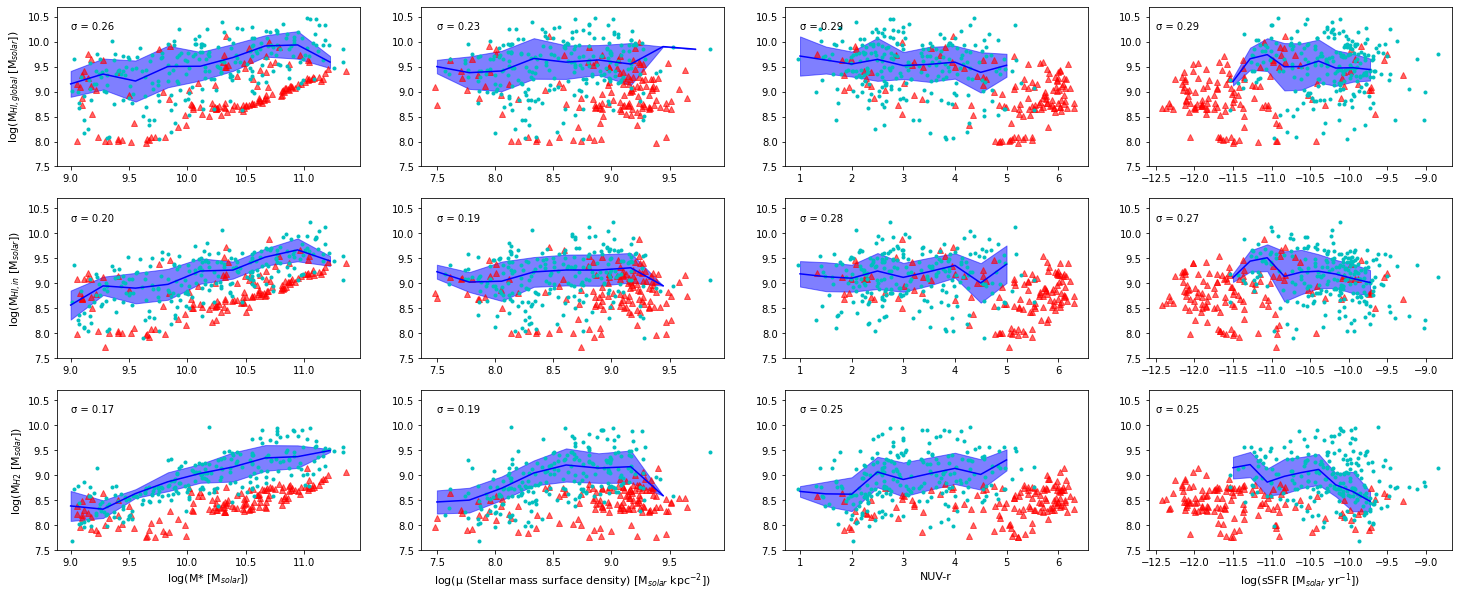

In [14]:
plt.figure(figsize=(25,10))
# Plotting the depletion times for the HI(global) mass against stellar properties
# MHI(global) against stellar mass
plt.subplot(3,4,1)
plt.plot(lgMSTAR_ndet, lgMHI_gl_ndet, 'r^', alpha = 0.6)
plt.plot(lgMSTAR_det, lgMHI_gl_det, 'c.')
plt.plot(HIglbins_Mstar[:-1], MHIgl_Mstar[:-1], 'b-')
plt.fill_between(HIglbins_Mstar[:-1], HIglnMAD_Mstar[:-1], HIglpMAD_Mstar[:-1], color= 'b', alpha = 0.5)
plt.ylabel('log(M$_{HI, global}$ [M$_{solar}$])', fontsize=11)
plt.text(9, 10.25, 'σ = %.2f' % ScatHIgl_Mstar)
plt.ylim(7.5, 10.7)
# MHI(global) against stellar surface density
plt.subplot(3,4,2)
plt.plot(lgMuST_ndet, lgMHI_gl_ndet, 'r^', alpha = 0.6)
plt.plot(lgMuST_det, lgMHI_gl_det, 'c.')
plt.plot(HIglbins_Must[:-1], MHIgl_Must[:-1], 'b-')
plt.fill_between(HIglbins_Must[:-1], HIglnMAD_Must[:-1], HIglpMAD_Must[:-1], color= 'b', alpha = 0.5)
plt.text(7.5, 10.25, 'σ = %.2f' % ScatHIgl_MuST)
plt.ylim(7.5, 10.7)
# MHI(global) against NUV-r
plt.subplot(3,4,3)
plt.plot(NUVr_ndet, lgMHI_gl_ndet, 'r^', alpha = 0.6)
plt.plot(NUVr_det, lgMHI_gl_det, 'c.')
plt.plot(HIglbins_NUVr[:-1], MHIgl_NUVr[:-1], 'b-')
plt.fill_between(HIglbins_NUVr[:-1], HIglnMAD_NUVr[:-1], HIglpMAD_NUVr[:-1], color= 'b', alpha = 0.5)
plt.text(1, 10.25, 'σ = %.2f' % ScatHIgl_NUVr)
plt.ylim(7.5, 10.7)
# MHI(global) against sSFR
plt.subplot(3,4,4)
plt.plot(lgsSFR_ndet, lgMHI_gl_ndet, 'r^', alpha = 0.6)
plt.plot(lgsSFR_det, lgMHI_gl_det, 'c.')
plt.plot(HIglbins_sSFR[:-1], MHIgl_sSFR[:-1], 'b-')
plt.fill_between(HIglbins_sSFR[:-1], HIglnMAD_sSFR[:-1], HIglpMAD_sSFR[:-1], color= 'b', alpha = 0.5)
plt.text(-12.5, 10.25, 'σ = %.2f' % ScatHIgl_sSFR)
plt.ylim(7.5, 10.7)

# Plotting the depletion times for the HI(in) mass against stellar properties
# HI(in) against stellar mass
plt.subplot(3,4,5)
plt.plot(lgMSTAR_ndet, lgMHI_in_ndet, 'r^', alpha = 0.6)
plt.plot(lgMSTAR_det, lgMHI_in_det, 'c.')
plt.plot(HIinbins_Mstar[:-1], MHIin_Mstar[:-1], 'b-')
plt.fill_between(HIinbins_Mstar[:-1], HIinnMAD_Mstar[:-1], HIinpMAD_Mstar[:-1], color= 'b', alpha = 0.5)
plt.ylabel('log(M$_{HI, in}$ [M$_{solar}$])', fontsize=11)
plt.text(9, 10.25, 'σ = %.2f' % ScatHIin_Mstar)
plt.ylim(7.5, 10.7)
# HI(in) against stellar surface density
plt.subplot(3,4,6)
plt.plot(lgMuST_ndet, lgMHI_in_ndet, 'r^', alpha = 0.6)
plt.plot(lgMuST_det, lgMHI_in_det, 'c.')
plt.plot(HIinbins_Must[:-2], MHIin_Must[:-2], 'b-')
plt.fill_between(HIinbins_Must[:-2], HIinnMAD_Must[:-2], HIinpMAD_Must[:-2], color= 'b', alpha = 0.5)
plt.text(7.5, 10.25, 'σ = %.2f' % ScatHIin_MuST)
plt.ylim(7.5, 10.7)
# HI(in) against NUV-r
plt.subplot(3,4,7)
plt.plot(NUVr_ndet, lgMHI_in_ndet, 'r^', alpha = 0.6)
plt.plot(NUVr_det, lgMHI_in_det, 'c.')
plt.plot(HIinbins_NUVr[:-1], MHIin_NUVr[:-1], 'b-')
plt.fill_between(HIinbins_NUVr[:-1], HIinnMAD_NUVr[:-1], HIinpMAD_NUVr[:-1], color= 'b', alpha = 0.5)
plt.text(1, 10.25, 'σ = %.2f' % ScatHIin_NUVr)
plt.ylim(7.5, 10.7)
# HI(in) against sSFR
plt.subplot(3,4,8)
plt.plot(lgsSFR_ndet, lgMHI_in_ndet, 'r^', alpha = 0.6)
plt.plot(lgsSFR_det, lgMHI_in_det, 'c.')
plt.plot(HIinbins_sSFR[:-1], MHIin_sSFR[:-1], 'b-')
plt.fill_between(HIinbins_sSFR[:-1], HIinnMAD_sSFR[:-1], HIinpMAD_sSFR[:-1], color= 'b', alpha = 0.5)
plt.text(-12.5, 10.25, 'σ = %.2f' % ScatHIin_sSFR)
plt.ylim(7.5, 10.7)

# Plotting the depletion times for the H2 mass against stellar properties
# H2 against stellar mass
plt.subplot(3,4,9)
plt.plot(lgMSTAR_ndet, limlgMH2_ndet, 'r^', alpha = 0.6)
plt.plot(lgMSTAR_det, lgMH2_det, 'c.')
plt.plot(H2bins_Mstar[:-1], MH2_Mstar[:-1], 'b-')
plt.fill_between(H2bins_Mstar[:-1], H2nMAD_Mstar[:-1], H2pMAD_Mstar[:-1], color= 'b', alpha = 0.5)
plt.ylabel('log(M$_{H2}$ [M$_{solar}$])', fontsize=11)
plt.xlabel('log(M* [M$_{solar}$])', fontsize=11)
plt.text(9, 10.25, 'σ = %.2f' % ScatH2_Mstar)
plt.ylim(7.5, 10.7)
# H2 against stellar surface density
plt.subplot(3,4,10)
plt.plot(lgMuST_ndet, limlgMH2_ndet, 'r^', alpha = 0.6)
plt.plot(lgMuST_det, lgMH2_det, 'c.')
plt.plot(H2bins_Must[:-2], MH2_Must[:-2], 'b-')
plt.fill_between(H2bins_Must[:-2], H2nMAD_Must[:-2], H2pMAD_Must[:-2], color= 'b', alpha = 0.5)
plt.xlabel('log(μ (Stellar mass surface density) [M$_{solar}$ kpc$^{-2}$])', fontsize=11)
plt.text(7.5, 10.25, 'σ = %.2f' % ScatH2_MuST)
plt.ylim(7.5, 10.7)
# H2 against NUVr
plt.subplot(3,4,11)
plt.plot(NUVr_ndet, limlgMH2_ndet, 'r^', alpha = 0.6)
plt.plot(NUVr_det, lgMH2_det, 'c.')
plt.plot(H2bins_NUVr[:-1], MH2_NUVr[:-1], 'b-')
plt.fill_between(H2bins_NUVr[:-1], H2nMAD_NUVr[:-1], H2pMAD_NUVr[:-1], color= 'b', alpha = 0.5)
plt.xlabel('NUV-r', fontsize=11)
plt.text(1, 10.25, 'σ = %.2f' % ScatH2_NUVr)
plt.ylim(7.5, 10.7)
# H2 against sSFR
plt.subplot(3,4,12)
plt.plot(lgsSFR_ndet, limlgMH2_ndet, 'r^', alpha = 0.6)
plt.plot(lgsSFR_det, lgMH2_det, 'c.')
plt.plot(H2bins_sSFR[:-1], MH2_sSFR[:-1], 'b-')
plt.fill_between(H2bins_sSFR[:-1], H2nMAD_sSFR[:-1], H2pMAD_sSFR[:-1], color= 'b', alpha = 0.5)
plt.xlabel('log(sSFR [M$_{solar}$ yr$^{-1}$])', fontsize=11)
plt.text(-12.5, 10.25, 'σ = %.2f' % ScatH2_sSFR)
plt.ylim(7.5, 10.7);

4) Investigating how the trends are affected by the binning the bulge-to-total ratio- plotting trends for the spiral dominated galaxies and then for the total of the sample

In [15]:
# Finding the distribution of galaxies in the bulge-to-total sample
print('B/T > 0.6:', len(np.where(B2TM > 0.6)[0]))
print('B/T > 0.4:', len(np.where(B2TM > 0.4)[0]))
print('B/T > 0.2:', len(np.where(B2TM > 0.2)[0]))
print('B/T > 0.1:', len(np.where(B2TM > 0.1)[0]))

B/T > 0.6: 16
B/T > 0.4: 64
B/T > 0.2: 167
B/T > 0.1: 222


In [16]:
# Due to the large number of galaxies dominated by a disk component need to change the bins to focus more of those galaxies
# Over half the galaxies present in the sample are between 0 and 0.2 on the bulge-to-total ratio
lgMH2_tot = lgMH2 + limlgMH2
B2TM1 = B2TM[np.where(B2TM < 0.2)]
B2TM2 = B2TM[np.where((B2TM > 0.2) & (B2TM < 0.4))]
B2TM3 = B2TM[np.where(B2TM > 0.4)]

lgMHI_in1 = lgMHI_in[np.where(B2TM < 0.2)]
lgMHI_in2 = lgMHI_in[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMHI_in3 = lgMHI_in[np.where(B2TM > 0.4)]

lgMHI_gl1 = lgMHI_gl[np.where(B2TM < 0.2)]
lgMHI_gl2 = lgMHI_gl[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMHI_gl3 = lgMHI_gl[np.where(B2TM > 0.4)]

lgMH2_tot1 = lgMH2_tot[np.where(B2TM < 0.2)]
lgMH2_tot2 = lgMH2_tot[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMH2_tot3 = lgMH2_tot[np.where(B2TM > 0.4)]

lgMSTAR1 = lgMSTAR[np.where(B2TM < 0.2)]
lgMSTAR2 = lgMSTAR[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMSTAR3 = lgMSTAR[np.where(B2TM > 0.4)]

NUVr1 = NUVr[np.where(B2TM < 0.2)]
NUVr2 = NUVr[np.where((B2TM > 0.2) & (B2TM < 0.4))]
NUVr3 = NUVr[np.where(B2TM > 0.4)]

lgsSFR1 = lgsSFR[np.where(B2TM < 0.2)]
lgsSFR2 = lgsSFR[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgsSFR3 = lgsSFR[np.where(B2TM > 0.4)]

lgMuST1 = lgMuST[np.where(B2TM < 0.2)]
lgMuST2 = lgMuST[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMuST3 = lgMuST[np.where(B2TM > 0.4)]

HIsrc1 = HIsrc[np.where(B2TM < 0.2)]
HIsrc2 = HIsrc[np.where((B2TM > 0.2) & (B2TM < 0.4))]
HIsrc3 = HIsrc[np.where(B2TM > 0.4)]

FLAG_CO1 = FLAG_CO[np.where(B2TM < 0.2)]
FLAG_CO2 = FLAG_CO[np.where((B2TM > 0.2) & (B2TM < 0.4))]
FLAG_CO3 = FLAG_CO[np.where(B2TM > 0.4)]

In [17]:
# Finding which galaxies in each bin are detections vs non-detection
lgMHI_in1_det = lgMHI_in1[np.where(HIsrc1 < 4)]
lgMHI_in1_ndet = lgMHI_in1[np.where(HIsrc1 >= 4)]
lgMHI_in2_det = lgMHI_in2[np.where(HIsrc2 < 4)]
lgMHI_in2_ndet = lgMHI_in2[np.where(HIsrc2 >= 4)]
lgMHI_in3_det = lgMHI_in3[np.where(HIsrc3 < 4)]
lgMHI_in3_ndet = lgMHI_in3[np.where(HIsrc3 >= 4)]

lgMHI_gl1_det = lgMHI_gl1[np.where(HIsrc1 < 4)]
lgMHI_gl1_ndet = lgMHI_gl1[np.where(HIsrc1 >= 4)]
lgMHI_gl2_det = lgMHI_gl2[np.where(HIsrc2 < 4)]
lgMHI_gl2_ndet = lgMHI_gl2[np.where(HIsrc2 >= 4)]
lgMHI_gl3_det = lgMHI_gl3[np.where(HIsrc3 < 4)]
lgMHI_gl3_ndet = lgMHI_gl3[np.where(HIsrc3 >= 4)]

lgMH2_tot1_det = lgMH2_tot1[np.where(FLAG_CO1 < 2)]
lgMH2_tot1_ndet = lgMH2_tot1[np.where(FLAG_CO1 > 1)]
lgMH2_tot2_det = lgMH2_tot2[np.where(FLAG_CO2 < 2)]
lgMH2_tot2_ndet = lgMH2_tot2[np.where(FLAG_CO2 > 1)]
lgMH2_tot3_det = lgMH2_tot3[np.where(FLAG_CO3 < 2)]
lgMH2_tot3_ndet = lgMH2_tot3[np.where(FLAG_CO3 > 1)]

In [18]:
# Adjusting the x-axis (stellar properties arrays) so that the detections and non-detections are of the same length
lgMSTAR1_det = lgMSTAR1[np.where(HIsrc1 < 4)]
lgMSTAR1_ndet = lgMSTAR1[np.where(HIsrc1 >= 4)]
lgMSTAR2_det = lgMSTAR2[np.where(HIsrc2 < 4)]
lgMSTAR2_ndet = lgMSTAR2[np.where(HIsrc2 >= 4)]
lgMSTAR3_det = lgMSTAR3[np.where(HIsrc3 < 4)]
lgMSTAR3_ndet = lgMSTAR3[np.where(HIsrc3 >= 4)]

NUVr1_det = NUVr1[np.where(HIsrc1 < 4)]
NUVr1_ndet = NUVr1[np.where(HIsrc1 >= 4)]
NUVr2_det = NUVr2[np.where(HIsrc2 < 4)]
NUVr2_ndet = NUVr2[np.where(HIsrc2 >= 4)]
NUVr3_det = NUVr3[np.where(HIsrc3 < 4)]
NUVr3_ndet = NUVr3[np.where(HIsrc3 >= 4)]

lgsSFR1_det = lgsSFR1[np.where(HIsrc1 < 4)]
lgsSFR1_ndet = lgsSFR1[np.where(HIsrc1 >= 4)]
lgsSFR2_det = lgsSFR2[np.where(HIsrc2 < 4)]
lgsSFR2_ndet = lgsSFR2[np.where(HIsrc2 >= 4)]
lgsSFR3_det = lgsSFR3[np.where(HIsrc3 < 4)]
lgsSFR3_ndet = lgsSFR3[np.where(HIsrc3 >= 4)]

lgMuST1_det = lgMuST1[np.where(HIsrc1 < 4)]
lgMuST1_ndet = lgMuST1[np.where(HIsrc1 >= 4)]
lgMuST2_det = lgMuST2[np.where(HIsrc2 < 4)]
lgMuST2_ndet = lgMuST2[np.where(HIsrc2 >= 4)]
lgMuST3_det = lgMuST3[np.where(HIsrc3 < 4)]
lgMuST3_ndet = lgMuST3[np.where(HIsrc3 >= 4)]

In [19]:
# x-axis values for the H2 where the detections and non-detections of CO are different to those of HI
lgMSTAR1_detH2 = lgMSTAR1[np.where(FLAG_CO1 < 2)]
lgMSTAR1_ndetH2 = lgMSTAR1[np.where(FLAG_CO1 > 1)]
lgMSTAR2_detH2 = lgMSTAR2[np.where(FLAG_CO2 < 2)]
lgMSTAR2_ndetH2 = lgMSTAR2[np.where(FLAG_CO2 > 1)]
lgMSTAR3_detH2 = lgMSTAR3[np.where(FLAG_CO3 < 2)]
lgMSTAR3_ndetH2 = lgMSTAR3[np.where(FLAG_CO3 > 1)]

NUVr1_detH2 = NUVr1[np.where(FLAG_CO1 < 2)]
NUVr1_ndetH2 = NUVr1[np.where(FLAG_CO1 > 1)]
NUVr2_detH2 = NUVr2[np.where(FLAG_CO2 < 2)]
NUVr2_ndetH2 = NUVr2[np.where(FLAG_CO2 > 1)]
NUVr3_detH2 = NUVr3[np.where(FLAG_CO3 < 2)]
NUVr3_ndetH2 = NUVr3[np.where(FLAG_CO3 > 1)]

lgsSFR1_detH2 = lgsSFR1[np.where(FLAG_CO1 < 2)]
lgsSFR1_ndetH2 = lgsSFR1[np.where(FLAG_CO1 > 1)]
lgsSFR2_detH2 = lgsSFR2[np.where(FLAG_CO2 < 2)]
lgsSFR2_ndetH2 = lgsSFR2[np.where(FLAG_CO2 > 1)]
lgsSFR3_detH2 = lgsSFR3[np.where(FLAG_CO3 < 2)]
lgsSFR3_ndetH2 = lgsSFR3[np.where(FLAG_CO3 > 1)]

lgMuST1_detH2 = lgMuST1[np.where(FLAG_CO1 < 2)]
lgMuST1_ndetH2 = lgMuST1[np.where(FLAG_CO1 > 1)]
lgMuST2_detH2 = lgMuST2[np.where(FLAG_CO2 < 2)]
lgMuST2_ndetH2 = lgMuST2[np.where(FLAG_CO2 > 1)]
lgMuST3_detH2 = lgMuST3[np.where(FLAG_CO3 < 2)]
lgMuST3_ndetH2 = lgMuST3[np.where(FLAG_CO3 > 1)]

In [20]:
# Finding the running median of the galaxies in the sample for the HI global (B2TM < 0.2)
# Arrays for the bins
bins_Mstar = np.linspace(9, 11.5, 10)
bins_NUVr = np.linspace(1, 7, 10)
bins_sSFR = np.linspace(-11.5, -9.0, 10)
bins_Must = np.linspace(7.5, 10, 10)

In [21]:
# Array of zeroes to store the median of each bin
# For MHI (global)
HIglmedian_Mstar = np.zeros(len(bins_Mstar)) 
HIglmedian_Mstar1 = np.zeros(len(bins_Mstar)) # <--- if the variable has 1 at the end it is for B2TM < 0.2

HIglmedian_NUVr = np.zeros(len(bins_NUVr))
HIglmedian_NUVr1 = np.zeros(len(bins_NUVr))

HIglmedian_sSFR = np.zeros(len(bins_sSFR))
HIglmedian_sSFR1 = np.zeros(len(bins_sSFR))

HIglmedian_Must = np.zeros(len(bins_Must))
HIglmedian_Must1 = np.zeros(len(bins_Must))

# For MHI (optical)
HIinmedian_Mstar = np.zeros(len(bins_Mstar)) 
HIinmedian_Mstar1 = np.zeros(len(bins_Mstar))

HIinmedian_NUVr = np.zeros(len(bins_NUVr))
HIinmedian_NUVr1 = np.zeros(len(bins_NUVr))

HIinmedian_sSFR = np.zeros(len(bins_sSFR))
HIinmedian_sSFR1 = np.zeros(len(bins_sSFR))

HIinmedian_Must = np.zeros(len(bins_Must))
HIinmedian_Must1 = np.zeros(len(bins_Must))

# For MH2
H2median_Mstar = np.zeros(len(bins_Mstar)) 
H2median_Mstar1 = np.zeros(len(bins_Mstar))

H2median_NUVr = np.zeros(len(bins_NUVr))
H2median_NUVr1 = np.zeros(len(bins_NUVr))

H2median_sSFR = np.zeros(len(bins_sSFR))
H2median_sSFR1 = np.zeros(len(bins_sSFR))

H2median_Must = np.zeros(len(bins_Must))
H2median_Must1 = np.zeros(len(bins_Must))

In [22]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar) -1):
  # Median bins for MHI (global):
  # Medians for the Mstar graph
  HIglmedian_Mstar[i] = np.median(lgMHI_gl[np.where((lgMSTAR[np.where(lgMHI_gl)] >= bins_Mstar[i]) & (lgMSTAR[np.where(lgMHI_gl)] <= bins_Mstar[i+1]))])
  HIglmedian_Mstar1[i] = np.median(lgMHI_gl1[np.where((lgMSTAR1[np.where(lgMHI_gl1)] >= bins_Mstar[i]) & (lgMSTAR1[np.where(lgMHI_gl1)] <= bins_Mstar[i+1]))])

  # Medians for the NUVr graph
  HIglmedian_NUVr[i] = np.median(lgMHI_gl[np.where((NUVr[np.where(lgMHI_gl)] >= bins_NUVr[i]) & (NUVr[np.where(lgMHI_gl)] <= bins_NUVr[i+1]))])
  HIglmedian_NUVr1[i] = np.median(lgMHI_gl1[np.where((NUVr1[np.where(lgMHI_gl1)] >= bins_NUVr[i]) & (NUVr1[np.where(lgMHI_gl1)] <= bins_NUVr[i+1]))])

  # Medians for the sSFR graph
  HIglmedian_sSFR[i] = np.median(lgMHI_gl[np.where((lgsSFR[np.where(lgMHI_gl)] >= bins_sSFR[i]) & (lgsSFR[np.where(lgMHI_gl)] <= bins_sSFR[i+1]))])
  HIglmedian_sSFR1[i] = np.median(lgMHI_gl1[np.where((lgsSFR1[np.where(lgMHI_gl1)] >= bins_sSFR[i]) & (lgsSFR1[np.where(lgMHI_gl1)] <= bins_sSFR[i+1]))])
  
  # Medians for the Mu star graph
  HIglmedian_Must[i] = np.median(lgMHI_gl[np.where((lgMuST[np.where(lgMHI_gl)] >= bins_Must[i]) & (lgMuST[np.where(lgMHI_gl)] <= bins_Must[i+1]))])
  HIglmedian_Must1[i] = np.median(lgMHI_gl1[np.where((lgMuST1[np.where(lgMHI_gl1)] >= bins_Must[i]) & (lgMuST1[np.where(lgMHI_gl1)] <= bins_Must[i+1]))]) 

  # Median bins for MHI (optical):
  # Medians for the Mstar graph
  HIinmedian_Mstar[i] = np.median(lgMHI_in[np.where((lgMSTAR[np.where(lgMHI_in)] >= bins_Mstar[i]) & (lgMSTAR[np.where(lgMHI_in)] <= bins_Mstar[i+1]))])
  HIinmedian_Mstar1[i] = np.median(lgMHI_in1[np.where((lgMSTAR1[np.where(lgMHI_in1)] >= bins_Mstar[i]) & (lgMSTAR1[np.where(lgMHI_in1)] <= bins_Mstar[i+1]))])

  # Medians for the NUVr graph
  HIinmedian_NUVr[i] = np.median(lgMHI_in[np.where((NUVr[np.where(lgMHI_in)] >= bins_NUVr[i]) & (NUVr[np.where(lgMHI_in)] <= bins_NUVr[i+1]))])
  HIinmedian_NUVr1[i] = np.median(lgMHI_in1[np.where((NUVr1[np.where(lgMHI_in1)] >= bins_NUVr[i]) & (NUVr1[np.where(lgMHI_in1)] <= bins_NUVr[i+1]))])

  # Medians for the sSFR graph
  HIinmedian_sSFR[i] = np.median(lgMHI_in[np.where((lgsSFR[np.where(lgMHI_in)] >= bins_sSFR[i]) & (lgsSFR[np.where(lgMHI_in)] <= bins_sSFR[i+1]))])
  HIinmedian_sSFR1[i] = np.median(lgMHI_in1[np.where((lgsSFR1[np.where(lgMHI_in1)] >= bins_sSFR[i]) & (lgsSFR1[np.where(lgMHI_in1)] <= bins_sSFR[i+1]))])
  
  # Medians for the Mu star graph
  HIinmedian_Must[i] = np.median(lgMHI_in[np.where((lgMuST[np.where(lgMHI_in)] >= bins_Must[i]) & (lgMuST[np.where(lgMHI_in)] <= bins_Must[i+1]))])
  HIinmedian_Must1[i] = np.median(lgMHI_in1[np.where((lgMuST1[np.where(lgMHI_in1)] >= bins_Must[i]) & (lgMuST1[np.where(lgMHI_in1)] <= bins_Must[i+1]))])

  # Median bins for MH2:
  # Medians for the Mstar graph
  H2median_Mstar[i] = np.median(lgMH2_tot[np.where((lgMSTAR[np.where(lgMH2_tot)] >= bins_Mstar[i]) & (lgMSTAR[np.where(lgMH2_tot)] <= bins_Mstar[i+1]))])
  H2median_Mstar1[i] = np.median(lgMH2_tot1[np.where((lgMSTAR1[np.where(lgMH2_tot1)] >= bins_Mstar[i]) & (lgMSTAR1[np.where(lgMH2_tot1)] <= bins_Mstar[i+1]))])

  # Medians for the NUVr graph
  H2median_NUVr[i] = np.median(lgMH2_tot[np.where((NUVr[np.where(lgMH2_tot)] >= bins_NUVr[i]) & (NUVr[np.where(lgMH2_tot)] <= bins_NUVr[i+1]))])
  H2median_NUVr1[i] = np.median(lgMH2_tot1[np.where((NUVr1[np.where(lgMH2_tot1)] >= bins_NUVr[i]) & (NUVr1[np.where(lgMH2_tot1)] <= bins_NUVr[i+1]))])

  # Medians for the sSFR graph
  H2median_sSFR[i] = np.median(lgMH2_tot[np.where((lgsSFR[np.where(lgMH2_tot)] >= bins_sSFR[i]) & (lgsSFR[np.where(lgMH2_tot)] <= bins_sSFR[i+1]))])
  H2median_sSFR1[i] = np.median(lgMH2_tot1[np.where((lgsSFR1[np.where(lgMH2_tot1)] >= bins_sSFR[i]) & (lgsSFR1[np.where(lgMH2_tot1)] <= bins_sSFR[i+1]))])

  # Medians for the Mu star graph
  H2median_Must[i] = np.median(lgMH2_tot[np.where((lgMuST[np.where(lgMH2_tot)] >= bins_Must[i]) & (lgMuST[np.where(lgMH2_tot)] <= bins_Must[i+1]))])
  H2median_Must1[i] = np.median(lgMH2_tot1[np.where((lgMuST1[np.where(lgMH2_tot1)] >= bins_Must[i]) & (lgMuST1[np.where(lgMH2_tot1)] <= bins_Must[i+1]))]) 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


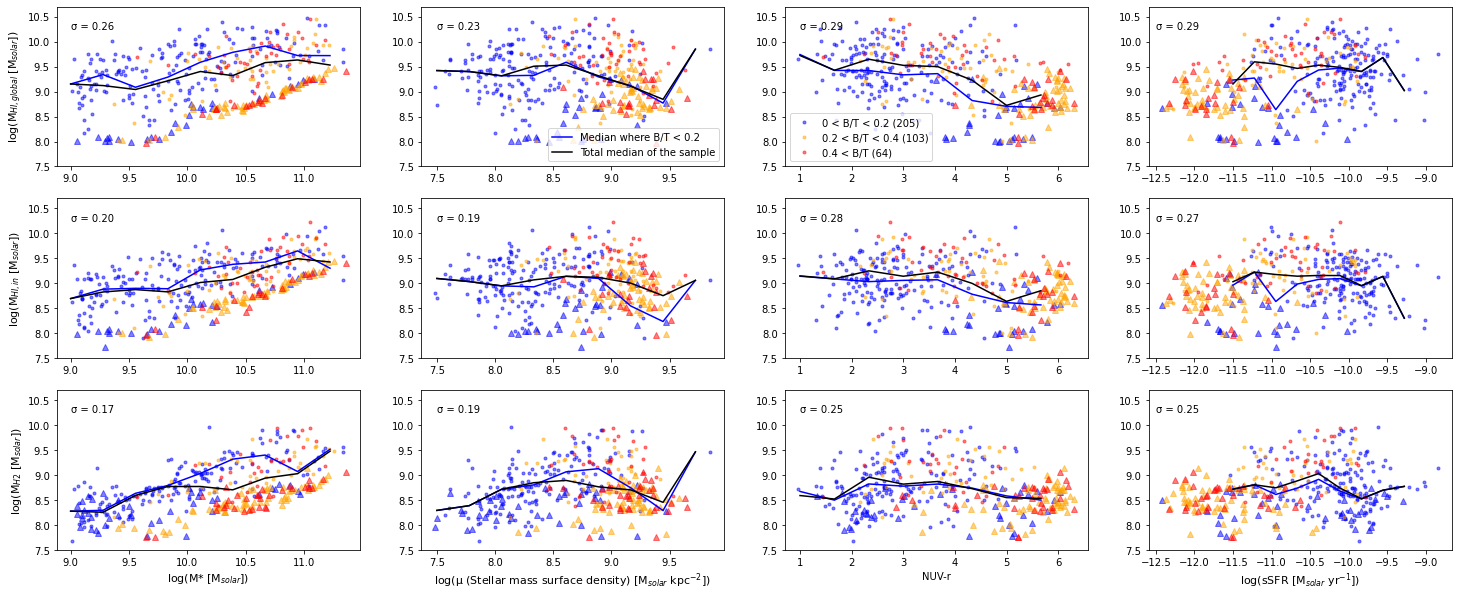

In [23]:
plt.figure(figsize=(25,10))
# Plotting the HI(global) mass against stellar properties
# MHI(global) against stellar mass
plt.subplot(3,4,1)
plt.plot(lgMSTAR1_det, lgMHI_gl1_det, 'blue', alpha = 0.5, marker='.', linestyle='none')
plt.plot(lgMSTAR1_ndet, lgMHI_gl1_ndet, 'blue', alpha = 0.5, marker='^', linestyle='none')
plt.plot(lgMSTAR2_det, lgMHI_gl2_det, 'orange', alpha = 0.5, marker='.', linestyle='none')
plt.plot(lgMSTAR2_ndet, lgMHI_gl2_ndet, 'orange', alpha = 0.5, marker='^', linestyle='none')
plt.plot(lgMSTAR3_det, lgMHI_gl3_det, 'red', alpha = 0.5, marker='.', linestyle='none')
plt.plot(lgMSTAR3_ndet, lgMHI_gl3_ndet, 'red', alpha = 0.5, marker='^', linestyle='none')
plt.plot(bins_Mstar[:-1], HIglmedian_Mstar1[:-1], 'b-')
plt.plot(bins_Mstar[:-1], HIglmedian_Mstar[:-1], 'k-')
plt.ylabel('log(M$_{HI, global}$ [M$_{solar}$])', fontsize=11)
plt.text(9, 10.25, 'σ = %.2f' % ScatHIgl_Mstar)
plt.ylim(7.5, 10.7)
# MHI(global) against stellar surface density
plt.subplot(3,4,2)
plt.plot(lgMuST1_det, lgMHI_gl1_det, 'blue', alpha = 0.5, marker = '.', linestyle='none')
plt.plot(lgMuST1_ndet, lgMHI_gl1_ndet, 'blue', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgMuST2_det, lgMHI_gl2_det, 'orange', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgMuST2_ndet, lgMHI_gl2_ndet, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST3_det, lgMHI_gl3_det, 'red', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgMuST3_ndet, lgMHI_gl3_ndet, 'red', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(bins_Must[:-1], HIglmedian_Must1[:-1], 'b-', label='Median where B/T < 0.2')
plt.plot(bins_Must[:-1], HIglmedian_Must[:-1], 'k-', label='Total median of the sample')
plt.legend(loc='lower right')
plt.text(7.5, 10.25, 'σ = %.2f' % ScatHIgl_MuST)
plt.ylim(7.5, 10.7)
# MHI(global) against NUV-r
plt.subplot(3,4,3)
plt.plot(NUVr1_det, lgMHI_gl1_det,'blue', alpha = 0.5, marker= '.', linestyle='none', label='0 < B/T < 0.2 (205)')
plt.plot(NUVr1_ndet, lgMHI_gl1_ndet,'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr2_det, lgMHI_gl2_det, 'orange', alpha = 0.5, marker= '.', linestyle='none', label='0.2 < B/T < 0.4 (103)')
plt.plot(NUVr2_ndet, lgMHI_gl2_ndet, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr3_det, lgMHI_gl3_det, 'red', alpha = 0.5, marker= '.', linestyle='none', label='0.4 < B/T (64)')
plt.plot(NUVr3_ndet, lgMHI_gl3_ndet, 'red', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(bins_NUVr[:-1], HIglmedian_NUVr1[:-1], 'b-')
plt.plot(bins_NUVr[:-1], HIglmedian_NUVr[:-1], 'k-')
plt.text(1, 10.25, 'σ = %.2f' % ScatHIgl_NUVr)
plt.legend(loc='lower left')
plt.ylim(7.5, 10.7)
# MHI(global) against sSFR
plt.subplot(3,4,4)
plt.plot(lgsSFR1_det, lgMHI_gl1_det, 'blue', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgsSFR1_ndet, lgMHI_gl1_ndet, 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR2_det, lgMHI_gl2_det, 'orange', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgsSFR2_ndet, lgMHI_gl2_ndet, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR3_det, lgMHI_gl3_det, 'red', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgsSFR3_ndet, lgMHI_gl3_ndet, 'red', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(bins_sSFR[:-1], HIglmedian_sSFR1[:-1], 'b-')
plt.plot(bins_sSFR[:-1], HIglmedian_sSFR[:-1], 'k-')
plt.text(-12.5, 10.25, 'σ = %.2f' % ScatHIgl_sSFR)
plt.ylim(7.5, 10.7)

# Plotting the HI(in) mass against stellar properties
# HI(in) against stellar mass
plt.subplot(3,4,5)
plt.plot(lgMSTAR1_det, lgMHI_in1_det, 'blue', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgMSTAR1_ndet, lgMHI_in1_ndet, 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMSTAR2_det, lgMHI_in2_det, 'orange', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgMSTAR2_ndet, lgMHI_in2_ndet, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMSTAR3_det, lgMHI_in3_det, 'red', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgMSTAR3_ndet, lgMHI_in3_ndet, 'red', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(bins_Mstar[:-1], HIinmedian_Mstar1[:-1], 'b-')
plt.plot(bins_Mstar[:-1], HIinmedian_Mstar[:-1], 'k-')
plt.ylabel('log(M$_{HI, in}$ [M$_{solar}$])', fontsize=11)
plt.text(9, 10.25, 'σ = %.2f' % ScatHIin_Mstar)
plt.ylim(7.5, 10.7)
# HI(in) against stellar surface density
plt.subplot(3,4,6)
plt.plot(lgMuST1_det, lgMHI_in1_det, 'blue', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgMuST1_ndet, lgMHI_in1_ndet, 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST2_det, lgMHI_in2_det, 'orange', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgMuST2_ndet, lgMHI_in2_ndet, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST3_det, lgMHI_in3_det, 'red', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgMuST3_ndet, lgMHI_in3_ndet, 'red', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(bins_Must[:-1], HIinmedian_Must1[:-1], 'b-')
plt.plot(bins_Must[:-1], HIinmedian_Must[:-1], 'k-')
plt.text(7.5, 10.25, 'σ = %.2f' % ScatHIin_MuST)
plt.ylim(7.5, 10.7)
# HI(in) against NUV-r
plt.subplot(3,4,7)
plt.plot(NUVr1_det, lgMHI_in1_det, 'blue', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(NUVr1_ndet, lgMHI_in1_ndet, 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr2_det, lgMHI_in2_det, 'orange', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(NUVr2_ndet, lgMHI_in2_ndet, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr3_det, lgMHI_in3_det, 'red', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(NUVr3_ndet, lgMHI_in3_ndet, 'red', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(bins_NUVr[:-1], HIinmedian_NUVr1[:-1], 'b-')
plt.plot(bins_NUVr[:-1], HIinmedian_NUVr[:-1], 'k-')
plt.text(1, 10.25, 'σ = %.2f' % ScatHIin_NUVr)
plt.ylim(7.5, 10.7)
# HI(in) against sSFR
plt.subplot(3,4,8)
plt.plot(lgsSFR1_det, lgMHI_in1_det, 'blue', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgsSFR1_ndet, lgMHI_in1_ndet, 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR2_det, lgMHI_in2_det, 'orange', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgsSFR2_ndet, lgMHI_in2_ndet, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR3_det, lgMHI_in3_det, 'red', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgsSFR3_ndet, lgMHI_in3_ndet, 'red', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(bins_sSFR[:-1], HIinmedian_sSFR1[:-1], 'b-')
plt.plot(bins_sSFR[:-1], HIinmedian_sSFR[:-1], 'k-')
plt.text(-12.5, 10.25, 'σ = %.2f' % ScatHIin_sSFR)
plt.ylim(7.5, 10.7)

# Plotting the the H2 mass against stellar properties
# H2 against stellar mass
plt.subplot(3,4,9)
plt.plot(lgMSTAR1_detH2, lgMH2_tot1_det, 'blue', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgMSTAR1_ndetH2, lgMH2_tot1_ndet, 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMSTAR2_detH2, lgMH2_tot2_det, 'orange', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgMSTAR2_ndetH2, lgMH2_tot2_ndet, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMSTAR3_detH2, lgMH2_tot3_det, 'red', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgMSTAR3_ndetH2, lgMH2_tot3_ndet, 'red', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(bins_Mstar[:-1], H2median_Mstar1[:-1], 'b-')
plt.plot(bins_Mstar[:-1], H2median_Mstar[:-1], 'k-')
plt.ylabel('log(M$_{H2}$ [M$_{solar}$])', fontsize=11)
plt.xlabel('log(M* [M$_{solar}$])', fontsize=11)
plt.text(9, 10.25, 'σ = %.2f' % ScatH2_Mstar)
plt.ylim(7.5, 10.7)
# H2 against stellar surface density
plt.subplot(3,4,10)
plt.plot(lgMuST1_detH2, lgMH2_tot1_det, 'blue', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgMuST1_ndetH2, lgMH2_tot1_ndet, 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST2_detH2, lgMH2_tot2_det, 'orange', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgMuST2_ndetH2, lgMH2_tot2_ndet, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST3_detH2, lgMH2_tot3_det, 'red', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgMuST3_ndetH2, lgMH2_tot3_ndet, 'red', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(bins_Must[:-1], H2median_Must1[:-1], 'b-')
plt.plot(bins_Must[:-1], H2median_Must[:-1], 'k-')
plt.xlabel('log(μ (Stellar mass surface density) [M$_{solar}$ kpc$^{-2}$])', fontsize=11)
plt.text(7.5, 10.25, 'σ = %.2f' % ScatH2_MuST)
plt.ylim(7.5, 10.7)
# H2 against NUVr
plt.subplot(3,4,11)
plt.plot(NUVr1_detH2, lgMH2_tot1_det, 'blue', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(NUVr1_ndetH2, lgMH2_tot1_ndet, 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr2_detH2, lgMH2_tot2_det, 'orange', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(NUVr2_ndetH2, lgMH2_tot2_ndet, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr3_detH2, lgMH2_tot3_det, 'red', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(NUVr3_ndetH2, lgMH2_tot3_ndet, 'red', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(bins_NUVr[:-1], H2median_NUVr1[:-1], 'b-')
plt.plot(bins_NUVr[:-1], H2median_NUVr[:-1], 'k-')
plt.text(1, 10.25, 'σ = %.2f' % ScatH2_NUVr)
plt.xlabel('NUV-r')
plt.ylim(7.5, 10.7)
# H2 against sSFR
plt.subplot(3,4,12)
plt.plot(lgsSFR1_detH2, lgMH2_tot1_det, 'blue', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgsSFR1_ndetH2, lgMH2_tot1_ndet, 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR2_detH2, lgMH2_tot2_det, 'orange', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgsSFR2_ndetH2, lgMH2_tot2_ndet, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR3_detH2, lgMH2_tot3_det, 'red', alpha = 0.5, marker= '.', linestyle='none')
plt.plot(lgsSFR3_ndetH2, lgMH2_tot3_ndet, 'red', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(bins_sSFR[:-1], H2median_sSFR1[:-1], 'b-')
plt.plot(bins_sSFR[:-1], H2median_sSFR[:-1], 'k-')
plt.xlabel('log(sSFR [M$_{solar}$ yr$^{-1}$])', fontsize=11)
plt.text(-12.5, 10.25, 'σ = %.2f' % ScatH2_sSFR)
plt.ylim(7.5, 10.7);

5) Comparison of how the mass of HI (global) and the mass of HI (interior) compare with the mass of the H2

In [24]:
# We have four cases of detections vs non-detections:
# (1) HI flag is 1,2,3- a detection AND CO flag is 1- a detection
# (2) HI flag is 4- a non-detection AND CO flag is 2- a non-detection
# (3) HI flag is 1,2,3- detection AND CO flag is 2- a non detection
# (4) HI flag is 4- a non-detection AND CO flag is 1- a detection
# For the scaling relations of MH2/MHI(in) and MH2/MHI(global):
# Case (1) are galaxies detections
# Case (2) are galaxy non-detections and must be removed from the sample
# Case (3) are upper limits
# Case (4) are the lower limits

# Finding the amount of galaxies that fit each criteria, each will be suffixed by a 1,2,3,4 based on the definitions above:
# HI (global) mass
lgMHI_gl_det1 = lgMHI_gl[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgMHI_gl_det2 = lgMHI_gl[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgMHI_gl_det3 = lgMHI_gl[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgMHI_gl_det4 = lgMHI_gl[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# HI (inner) mass
lgMHI_in_det1 = lgMHI_in[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgMHI_in_det2 = lgMHI_in[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgMHI_in_det3 = lgMHI_in[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgMHI_in_det4 = lgMHI_in[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# H2 mass
lgMH2_det1 = lgMH2_tot[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgMH2_det2 = lgMH2_tot[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgMH2_det3 = lgMH2_tot[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgMH2_det4 = lgMH2_tot[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# Stellar mass
lgMSTAR_det1 = lgMSTAR[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgMSTAR_det2 = lgMSTAR[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgMSTAR_det3 = lgMSTAR[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgMSTAR_det4 = lgMSTAR[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# Stellar mass surface density
lgMuST_det1 = lgMuST[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgMuST_det2 = lgMuST[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgMuST_det3 = lgMuST[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgMuST_det4 = lgMuST[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# NUVr
NUVr_det1 = NUVr[np.where((HIsrc < 4) & (FLAG_CO < 2))]
NUVr_det2 = NUVr[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
NUVr_det3 = NUVr[np.where((HIsrc < 4) & (FLAG_CO > 1))]
NUVr_det4 = NUVr[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# sSFR
lgsSFR_det1 = lgsSFR[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgsSFR_det2 = lgsSFR[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgsSFR_det3 = lgsSFR[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgsSFR_det4 = lgsSFR[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# B2TM
B2TM_det1 = B2TM[np.where((HIsrc < 4) & (FLAG_CO < 2))]
B2TM_det2 = B2TM[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
B2TM_det3 = B2TM[np.where((HIsrc < 4) & (FLAG_CO > 1))]
B2TM_det4 = B2TM[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# SFR
lgSFRbest_det1 = lgSFRbest[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgSFRbest_det2 = lgSFRbest[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgSFRbest_det3 = lgSFRbest[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgSFRbest_det4 = lgSFRbest[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# GASS ID
GASS_det1 = GASS[np.where((HIsrc < 4) & (FLAG_CO < 2))]
GASS_det2 = GASS[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
GASS_det3 = GASS[np.where((HIsrc < 4) & (FLAG_CO > 1))]
GASS_det4 = GASS[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# RA
RA_det1 = RA[np.where((HIsrc < 4) & (FLAG_CO < 2))]
RA_det2 = RA[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
RA_det3 = RA[np.where((HIsrc < 4) & (FLAG_CO > 1))]
RA_det4 = RA[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# DEC
DEC_det1 = DEC[np.where((HIsrc < 4) & (FLAG_CO < 2))]
DEC_det2 = DEC[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
DEC_det3 = DEC[np.where((HIsrc < 4) & (FLAG_CO > 1))]
DEC_det4 = DEC[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# 2Reff
Reff_kpc_det1 = Reff_kpc[np.where((HIsrc < 4) & (FLAG_CO < 2))]
Reff_kpc_det2 = Reff_kpc[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
Reff_kpc_det3 = Reff_kpc[np.where((HIsrc < 4) & (FLAG_CO > 1))]
Reff_kpc_det4 = Reff_kpc[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# R90
R90_kpc_det1 = R90_kpc[np.where((HIsrc < 4) & (FLAG_CO < 2))]
R90_kpc_det2 = R90_kpc[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
R90_kpc_det3 = R90_kpc[np.where((HIsrc < 4) & (FLAG_CO > 1))]
R90_kpc_det4 = R90_kpc[np.where((HIsrc >= 4) & (FLAG_CO < 2))]

In [25]:
# We can now compute the mass fractions, ignoring any variable with a '2' suffix
# H2/HI(global)
H2HIgl_det1 = np.log10((10**lgMH2_det1) / (10**lgMHI_gl_det1))
H2HIgl_det3 = np.log10((10**lgMH2_det3) / (10**lgMHI_gl_det3))
H2HIgl_det4 = np.log10((10**lgMH2_det4) / (10**lgMHI_gl_det4))
# H2/HI(inner)
H2HIin_det1 = np.log10((10**lgMH2_det1) / (10**lgMHI_in_det1))
H2HIin_det3 = np.log10((10**lgMH2_det3) / (10**lgMHI_in_det3))
H2HIin_det4 = np.log10((10**lgMH2_det4) / (10**lgMHI_in_det4))

In [26]:
# Finding the running median of the galaxies in the sample for the H2/HI(global)
# Arrays for the bins
bins_Mstar = np.linspace(9.25, 11, 10)
bins_NUVr = np.linspace(1.5, 7.5, 10)
bins_sSFR = np.linspace(-11.15, -9.25, 10)
bins_Must = np.linspace(7.75, 9.4, 10)

# Array of zeroes to store the median of each bin
H2HIgl_median_Mstar = np.zeros(len(bins_Mstar)) 
H2HIgl_MAD_Mstar = np.zeros(len(bins_Mstar))

H2HIgl_median_NUVr = np.zeros(len(bins_NUVr))
H2HIgl_MAD_NUVr = np.zeros(len(bins_NUVr))

H2HIgl_median_sSFR = np.zeros(len(bins_sSFR))
H2HIgl_MAD_sSFR = np.zeros(len(bins_sSFR))

H2HIgl_median_Must = np.zeros(len(bins_Must))
H2HIgl_MAD_Must = np.zeros(len(bins_Must))

In [27]:
# Finding the running median of the galaxies in the sample for the H2/HI(inner)
# Arrays for the zeros to store the median of each bin
H2HIin_median_Mstar = np.zeros(len(bins_Mstar)) 
H2HIin_MAD_Mstar = np.zeros(len(bins_Mstar))

H2HIin_median_NUVr = np.zeros(len(bins_NUVr))
H2HIin_MAD_NUVr = np.zeros(len(bins_NUVr))

H2HIin_median_sSFR = np.zeros(len(bins_sSFR))
H2HIin_MAD_sSFR = np.zeros(len(bins_sSFR))

H2HIin_median_Must = np.zeros(len(bins_Must))
H2HIin_MAD_Must = np.zeros(len(bins_Must))

In [28]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar) -1):
  # H2/HI (global)
  # Median and MAD for the Mstar graph
  H2HIgl_median_Mstar[i] = np.median(H2HIgl_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])
  H2HIgl_MAD_Mstar[i] = stats.median_abs_deviation(H2HIgl_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  H2HIgl_median_NUVr[i] = np.median(H2HIgl_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])
  H2HIgl_MAD_NUVr[i] = stats.median_abs_deviation(H2HIgl_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  H2HIgl_median_sSFR[i] = np.median(H2HIgl_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  H2HIgl_MAD_sSFR[i] = stats.median_abs_deviation(H2HIgl_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  
  #Median and MAD for the Must graph
  H2HIgl_median_Must[i] = np.median(H2HIgl_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])
  H2HIgl_MAD_Must[i] = stats.median_abs_deviation(H2HIgl_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])

  # H2/HI (optical)
  # Median and MAD for the Mstar graph
  H2HIin_median_Mstar[i] = np.median(H2HIin_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])
  H2HIin_MAD_Mstar[i] = stats.median_abs_deviation(H2HIin_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  H2HIin_median_NUVr[i] = np.median(H2HIin_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])
  H2HIin_MAD_NUVr[i] = stats.median_abs_deviation(H2HIin_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  H2HIin_median_sSFR[i] = np.median(H2HIin_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  H2HIin_MAD_sSFR[i] = stats.median_abs_deviation(H2HIin_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  
  #Median and MAD for the Must graph
  H2HIin_median_Must[i] = np.median(H2HIin_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])
  H2HIin_MAD_Must[i] = stats.median_abs_deviation(H2HIin_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])

# Working out the upper and lower bounds of the median absolute deviation
# H2/HI (global)
# Mstar graph median bounds
H2HIgl_pMAD_Mstar = H2HIgl_median_Mstar + H2HIgl_MAD_Mstar
H2HIgl_nMAD_Mstar = H2HIgl_median_Mstar - H2HIgl_MAD_Mstar
# NUV-r graph median bounds
H2HIgl_pMAD_NUVr = H2HIgl_median_NUVr + H2HIgl_MAD_NUVr
H2HIgl_nMAD_NUVr = H2HIgl_median_NUVr - H2HIgl_MAD_NUVr
# sSFR graph median bounds
H2HIgl_pMAD_sSFR = H2HIgl_median_sSFR + H2HIgl_MAD_sSFR
H2HIgl_nMAD_sSFR = H2HIgl_median_sSFR - H2HIgl_MAD_sSFR
# Must graph median bounds
H2HIgl_pMAD_Must = H2HIgl_median_Must + H2HIgl_MAD_Must
H2HIgl_nMAD_Must = H2HIgl_median_Must - H2HIgl_MAD_Must

# H2/HI (optical)
# Mstar graph median bounds
H2HIin_pMAD_Mstar = H2HIin_median_Mstar + H2HIin_MAD_Mstar
H2HIin_nMAD_Mstar = H2HIin_median_Mstar - H2HIin_MAD_Mstar
# NUV-r graph median bounds
H2HIin_pMAD_NUVr = H2HIin_median_NUVr + H2HIin_MAD_NUVr
H2HIin_nMAD_NUVr = H2HIin_median_NUVr - H2HIin_MAD_NUVr
# sSFR graph median bounds
H2HIin_pMAD_sSFR = H2HIin_median_sSFR + H2HIin_MAD_sSFR
H2HIin_nMAD_sSFR = H2HIin_median_sSFR - H2HIin_MAD_sSFR
# Must graph median bounds
H2HIin_pMAD_Must = H2HIin_median_Must + H2HIin_MAD_Must
H2HIin_nMAD_Must = H2HIin_median_Must - H2HIin_MAD_Must

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [29]:
# Finding the average scatter of the detections on each plot, mean of the MAD values for each plot:
# H2/HI (global)
ScatH2HIgl_Mstar = np.mean(H2HIgl_MAD_Mstar[:-1])
ScatH2HIgl_NUVr = np.mean(H2HIgl_MAD_NUVr[:-4])
ScatH2HIgl_sSFR = np.mean(H2HIgl_MAD_sSFR[:-2])
ScatH2HIgl_Must = np.mean(H2HIgl_MAD_Must[:-1])
# H2/HI (optical)
ScatH2HIin_Mstar = np.mean(H2HIin_MAD_Mstar[:-1])
ScatH2HIin_NUVr = np.mean(H2HIin_MAD_NUVr[:-4])
ScatH2HIin_sSFR = np.mean(H2HIin_MAD_sSFR[:-2])
ScatH2HIin_Must = np.mean(H2HIin_MAD_Must[:-1])

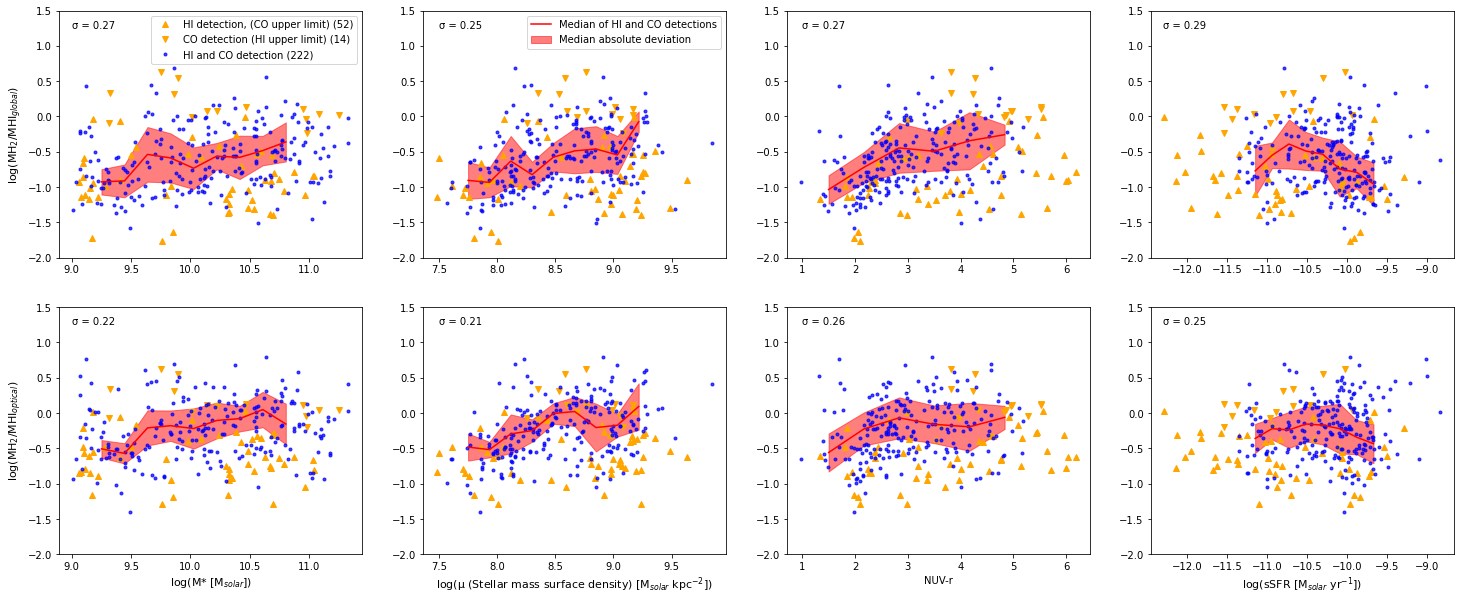

In [30]:
# Plotting the mass fractions against the four stellar properties seen before
plt.figure(figsize=(25,10))
# H2/HI(global) stellar mass
plt.subplot(2,4,1)
plt.plot(lgMSTAR_det3, H2HIgl_det3, 'orange', marker = '^', linestyle='none', label='HI detection, (CO upper limit) (52)')
plt.plot(lgMSTAR_det4, H2HIgl_det4, 'orange', marker = 'v', linestyle='none', label='CO detection (HI upper limit) (14)')
plt.plot(lgMSTAR_det1, H2HIgl_det1, 'blue', marker = '.', linestyle ='none', alpha = 0.75, label='HI and CO detection (222)')
plt.ylabel('log(MH$_{2}$/MHI$_{global}$)', fontsize=11)
plt.plot(bins_Mstar[:-1], H2HIgl_median_Mstar[:-1], 'r-')
plt.fill_between(bins_Mstar[:-1], H2HIgl_nMAD_Mstar[:-1], H2HIgl_pMAD_Mstar[:-1], color= 'r', alpha = 0.5)
plt.ylim(-2, 1.5)
plt.legend(loc='upper right')
plt.text(9, 1.25, 'σ = %.2f' % ScatH2HIgl_Mstar)
# H2/HI(global) stellar surface density
plt.subplot(2,4,2)
plt.plot(lgMuST_det3, H2HIgl_det3, 'orange', marker = '^', linestyle='none')
plt.plot(lgMuST_det4, H2HIgl_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(lgMuST_det1, H2HIgl_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.plot(bins_Must[:-1], H2HIgl_median_Must[:-1], 'r-', label='Median of HI and CO detections')
plt.fill_between(bins_Must[:-1], H2HIgl_nMAD_Must[:-1], H2HIgl_pMAD_Must[:-1], color= 'r', alpha = 0.5, label='Median absolute deviation')
plt.ylim(-2, 1.5)
plt.legend(loc='upper right')
plt.text(7.5, 1.25, 'σ = %.2f' % ScatH2HIgl_Must)
# H2/HI(global) NUVr
plt.subplot(2,4,3)
plt.plot(NUVr_det3, H2HIgl_det3, 'orange', marker = '^', linestyle='none')
plt.plot(NUVr_det4, H2HIgl_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(NUVr_det1, H2HIgl_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.plot(bins_NUVr[:-1], H2HIgl_median_NUVr[:-1], 'r-')
plt.fill_between(bins_NUVr[:-1], H2HIgl_nMAD_NUVr[:-1], H2HIgl_pMAD_NUVr[:-1], color= 'r', alpha = 0.5)
plt.ylim(-2, 1.5)
plt.text(1, 1.25, 'σ = %.2f' % ScatH2HIgl_NUVr)
# H2/HI(global) sSFR
plt.subplot(2,4,4)
plt.plot(lgsSFR_det3, H2HIgl_det3, 'orange', marker = '^', linestyle='none')
plt.plot(lgsSFR_det4, H2HIgl_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(lgsSFR_det1, H2HIgl_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.plot(bins_sSFR[:-2], H2HIgl_median_sSFR[:-2], 'r-')
plt.fill_between(bins_sSFR[:-2], H2HIgl_nMAD_sSFR[:-2], H2HIgl_pMAD_sSFR[:-2], color= 'r', alpha = 0.5)
plt.ylim(-2, 1.5)
plt.text(-12.3, 1.25, 'σ = %.2f' % ScatH2HIgl_sSFR)

# H2/HI(inner) stellar mass
plt.subplot(2,4,5)
plt.plot(lgMSTAR_det3, H2HIin_det3, 'orange', marker = '^', linestyle='none')
plt.plot(lgMSTAR_det4, H2HIin_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(lgMSTAR_det1, H2HIin_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.ylabel('log(MH$_{2}$/MHI$_{optical}$)', fontsize=11)
plt.xlabel('log(M* [M$_{solar}$])', fontsize=11)
plt.plot(bins_Mstar[:-1], H2HIin_median_Mstar[:-1], 'r-')
plt.fill_between(bins_Mstar[:-1], H2HIin_nMAD_Mstar[:-1], H2HIin_pMAD_Mstar[:-1], color= 'r', alpha = 0.5)
plt.ylim(-2, 1.5)
plt.text(9, 1.25, 'σ = %.2f' % ScatH2HIin_Mstar)
# H2/HI(inner) stellar surface density
plt.subplot(2,4,6)
plt.plot(lgMuST_det3, H2HIin_det3, 'orange', marker = '^', linestyle='none')
plt.plot(lgMuST_det4, H2HIin_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(lgMuST_det1, H2HIin_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.xlabel('log(μ (Stellar mass surface density) [M$_{solar}$ kpc$^{-2}$])', fontsize=11)
plt.plot(bins_Must[:-1], H2HIin_median_Must[:-1], 'r-')
plt.fill_between(bins_Must[:-1], H2HIin_nMAD_Must[:-1], H2HIin_pMAD_Must[:-1], color= 'r', alpha = 0.5)
plt.ylim(-2, 1.5)
plt.text(7.5, 1.25, 'σ = %.2f' % ScatH2HIin_Must)
# H2/HI(inner) NUVr
plt.subplot(2,4,7)
plt.plot(NUVr_det3, H2HIin_det3, 'orange', marker = '^', linestyle='none')
plt.plot(NUVr_det4, H2HIin_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(NUVr_det1, H2HIin_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.xlabel('NUV-r')
plt.plot(bins_NUVr[:-1], H2HIin_median_NUVr[:-1], 'r-')
plt.fill_between(bins_NUVr[:-1], H2HIin_nMAD_NUVr[:-1], H2HIin_pMAD_NUVr[:-1], color= 'r', alpha = 0.5)
plt.ylim(-2, 1.5)
plt.text(1, 1.25, 'σ = %.2f' % ScatH2HIin_NUVr)
# H2/HI(inner) sSFR
plt.subplot(2,4,8)
plt.plot(lgsSFR_det3, H2HIin_det3, 'orange', marker = '^', linestyle='none')
plt.plot(lgsSFR_det4, H2HIin_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(lgsSFR_det1, H2HIin_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.xlabel('log(sSFR [M$_{solar}$ yr$^{-1}$])', fontsize=11)
plt.plot(bins_sSFR[:-2], H2HIin_median_sSFR[:-2], 'r-')
plt.fill_between(bins_sSFR[:-2], H2HIin_nMAD_sSFR[:-2], H2HIin_pMAD_sSFR[:-2], color= 'r', alpha = 0.5)
plt.ylim(-2, 1.5)
plt.text(-12.3, 1.25, 'σ = %.2f' % ScatH2HIin_sSFR);

6) Looking at the depletion time for the gases

In [31]:
# Depletion times are given by t(dep) = M(gas)/SFR
# Depletion time for HI (global, detections)
lgtdep_HIgl_det1 = np.log10((10**lgMHI_gl_det1) / ((10**lgsSFR_det1) * (10**lgMSTAR_det1)))
# Depletion time for HI (global, upper and lower limits)
lgtdep_HIgl_det3 = np.log10((10**lgMHI_gl_det3) / ((10**lgsSFR_det3) * (10**lgMSTAR_det3)))
lgtdep_HIgl_det4 = np.log10((10**lgMHI_gl_det4) / ((10**lgsSFR_det4) * (10**lgMSTAR_det4)))

# Depletion time for HI (optical, detections)
lgtdep_HIin_det1 = np.log10((10**lgMHI_in_det1) / ((10**lgsSFR_det1) * (10**lgMSTAR_det1)))
# Depletion time for HI (optical, upper and lower limits)
lgtdep_HIin_det3 = np.log10((10**lgMHI_in_det3) / ((10**lgsSFR_det3) * (10**lgMSTAR_det3)))
lgtdep_HIin_det4 = np.log10((10**lgMHI_in_det4) / ((10**lgsSFR_det4) * (10**lgMSTAR_det4)))

# Depletion time for H2 (detections)
lgtdep_H2_det1 = np.log10((10**lgMH2_det1) / ((10**lgsSFR_det1) * (10**lgMSTAR_det1)))
# Depletion time for H2 (upper and lower limits)
lgtdep_H2_det3 = np.log10((10**lgMH2_det3) / ((10**lgsSFR_det3) * (10**lgMSTAR_det3)))
lgtdep_H2_det4 = np.log10((10**lgMH2_det4) / ((10**lgsSFR_det4) * (10**lgMSTAR_det4)))

In [32]:
# Finding the running median of the galaxies in the sample for the HI global
# Arrays for the bins
bins_Mstar = np.linspace(9, 11.25, 10)
bins_NUVr = np.linspace(1, 5.5, 10)
bins_sSFR = np.linspace(-11.25, -9.5, 10)
bins_Must = np.linspace(7.5, 9.5, 10)

In [33]:
# Array of zeroes to store the median of each bin
# Depletion times for HI (global)
tdep_HIglmedian_Mstar = np.zeros(len(bins_Mstar))
tdep_HIglMAD_Mstar = np.zeros(len(bins_Mstar))

tdep_HIglmedian_NUVr = np.zeros(len(bins_NUVr))
tdep_HIglMAD_NUVr = np.zeros(len(bins_NUVr))

tdep_HIglmedian_sSFR = np.zeros(len(bins_sSFR))
tdep_HIglMAD_sSFR = np.zeros(len(bins_sSFR))

tdep_HIglmedian_Must = np.zeros(len(bins_Must))
tdep_HIglMAD_Must = np.zeros(len(bins_Must))

# Depletion times for HI (optical)
tdep_HIinmedian_Mstar = np.zeros(len(bins_Mstar))
tdep_HIinMAD_Mstar = np.zeros(len(bins_Mstar))

tdep_HIinmedian_NUVr = np.zeros(len(bins_NUVr))
tdep_HIinMAD_NUVr = np.zeros(len(bins_NUVr))

tdep_HIinmedian_sSFR = np.zeros(len(bins_sSFR))
tdep_HIinMAD_sSFR = np.zeros(len(bins_sSFR))

tdep_HIinmedian_Must = np.zeros(len(bins_Must))
tdep_HIinMAD_Must = np.zeros(len(bins_Must))

# Depletion time for H2
tdep_H2median_Mstar = np.zeros(len(bins_Mstar))
tdep_H2MAD_Mstar = np.zeros(len(H2bins_Mstar))

tdep_H2median_NUVr = np.zeros(len(bins_NUVr))
tdep_H2MAD_NUVr = np.zeros(len(bins_NUVr))

tdep_H2median_sSFR = np.zeros(len(bins_sSFR))
tdep_H2MAD_sSFR = np.zeros(len(bins_sSFR))

tdep_H2median_Must = np.zeros(len(bins_Must))
tdep_H2MAD_Must = np.zeros(len(bins_Must))

In [34]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar) -1):
  # Depletion time of HI (global)
  # Median and MAD for the Mstar graph
  tdep_HIglmedian_Mstar[i] = np.median(lgtdep_HIgl_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])
  tdep_HIglMAD_Mstar[i] = stats.median_abs_deviation(lgtdep_HIgl_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  tdep_HIglmedian_NUVr[i] = np.median(lgtdep_HIgl_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])
  tdep_HIglMAD_NUVr[i] = stats.median_abs_deviation(lgtdep_HIgl_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  tdep_HIglmedian_sSFR[i] = np.median(lgtdep_HIgl_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  tdep_HIglMAD_sSFR[i] = stats.median_abs_deviation(lgtdep_HIgl_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])

  # Median and MAD for the Must graph
  tdep_HIglmedian_Must[i] = np.median(lgtdep_HIgl_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])
  tdep_HIglMAD_Must[i] = stats.median_abs_deviation(lgtdep_HIgl_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])

  # Depletion time of HI (optical)
  # Median and MAD for the Mstar graph
  tdep_HIinmedian_Mstar[i] = np.median(lgtdep_HIin_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])
  tdep_HIinMAD_Mstar[i] = stats.median_abs_deviation(lgtdep_HIin_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  tdep_HIinmedian_NUVr[i] = np.median(lgtdep_HIin_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])
  tdep_HIinMAD_NUVr[i] = stats.median_abs_deviation(lgtdep_HIin_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  tdep_HIinmedian_sSFR[i] = np.median(lgtdep_HIin_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  tdep_HIinMAD_sSFR[i] = stats.median_abs_deviation(lgtdep_HIin_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  
  #Median and MAD for the Must graph
  tdep_HIinmedian_Must[i] = np.median(lgtdep_HIin_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])
  tdep_HIinMAD_Must[i] = stats.median_abs_deviation(lgtdep_HIin_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])
  
  # Depletion time of H2
  # Median and MAD for the Mstar graph
  tdep_H2median_Mstar[i] = np.median(lgtdep_H2_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])
  tdep_H2MAD_Mstar[i] = stats.median_abs_deviation(lgtdep_H2_det1[np.where((lgMSTAR_det1 >= H2bins_Mstar[i]) & (lgMSTAR_det1 <= H2bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  tdep_H2median_NUVr[i] = np.median(lgtdep_H2_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])
  tdep_H2MAD_NUVr[i] = stats.median_abs_deviation(lgtdep_H2_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  tdep_H2median_sSFR[i] = np.median(lgtdep_H2_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  tdep_H2MAD_sSFR[i] = stats.median_abs_deviation(lgtdep_H2_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  
  #Median and MAD for the Must graph
  tdep_H2median_Must[i] = np.median(lgtdep_H2_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])
  tdep_H2MAD_Must[i] = stats.median_abs_deviation(lgtdep_H2_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])

In [35]:
# Working out the upper and lower bounds of the median absolute deviation
# HI (global)
# Mstar graph median bounds
tdep_HIglpMAD_Mstar = tdep_HIglmedian_Mstar + tdep_HIglMAD_Mstar
tdep_HIglnMAD_Mstar = tdep_HIglmedian_Mstar - tdep_HIglMAD_Mstar
# NUV-r graph median bounds
tdep_HIglpMAD_NUVr = tdep_HIglmedian_NUVr + tdep_HIglMAD_NUVr
tdep_HIglnMAD_NUVr = tdep_HIglmedian_NUVr - tdep_HIglMAD_NUVr
# sSFR graph median bounds
tdep_HIglpMAD_sSFR = tdep_HIglmedian_sSFR + tdep_HIglMAD_sSFR
tdep_HIglnMAD_sSFR = tdep_HIglmedian_sSFR - tdep_HIglMAD_sSFR
# Must graph median bounds
tdep_HIglpMAD_Must = tdep_HIglmedian_Must + tdep_HIglMAD_Must
tdep_HIglnMAD_Must = tdep_HIglmedian_Must - tdep_HIglMAD_Must

# HI (optical)
# Mstar graph median bounds
tdep_HIinpMAD_Mstar = tdep_HIinmedian_Mstar + tdep_HIinMAD_Mstar
tdep_HIinnMAD_Mstar = tdep_HIinmedian_Mstar - tdep_HIinMAD_Mstar
# NUV-r graph median bounds
tdep_HIinpMAD_NUVr = tdep_HIinmedian_NUVr + tdep_HIinMAD_NUVr
tdep_HIinnMAD_NUVr = tdep_HIinmedian_NUVr - tdep_HIinMAD_NUVr
# sSFR graph median bounds
tdep_HIinpMAD_sSFR = tdep_HIinmedian_sSFR + tdep_HIinMAD_sSFR
tdep_HIinnMAD_sSFR = tdep_HIinmedian_sSFR - tdep_HIinMAD_sSFR
# Must graph median bounds
tdep_HIinpMAD_Must = tdep_HIinmedian_Must + tdep_HIinMAD_Must
tdep_HIinnMAD_Must = tdep_HIinmedian_Must - tdep_HIinMAD_Must

# H2
# Mstar graph median bounds
tdep_H2pMAD_Mstar = tdep_H2median_Mstar + tdep_H2MAD_Mstar
tdep_H2nMAD_Mstar = tdep_H2median_Mstar - tdep_H2MAD_Mstar
# NUV-r graph median bounds
tdep_H2pMAD_NUVr = tdep_H2median_NUVr + tdep_H2MAD_NUVr
tdep_H2nMAD_NUVr = tdep_H2median_NUVr - tdep_H2MAD_NUVr
# sSFR graph median bounds
tdep_H2pMAD_sSFR = tdep_H2median_sSFR + tdep_H2MAD_sSFR
tdep_H2nMAD_sSFR = tdep_H2median_sSFR - tdep_H2MAD_sSFR
# Must graph median bounds
tdep_H2pMAD_Must = tdep_H2median_Must + tdep_H2MAD_Must
tdep_H2nMAD_Must = tdep_H2median_Must - tdep_H2MAD_Must

In [36]:
# Finding the scatter present between the median lines and MAD for each plot
# Depletion time of HI (global)
ScatHIgl_Mstar = np.mean(tdep_HIglMAD_Mstar[1:-1])
ScatHIgl_NUVr = np.mean(tdep_HIglMAD_NUVr[1:-1])
ScatHIgl_sSFR = np.mean(tdep_HIglMAD_sSFR[:-1])
ScatHIgl_Must = np.mean(tdep_HIglMAD_Must[1:-1])
# Depletion time of HI (optical)
ScatHIin_Mstar = np.mean(tdep_HIinMAD_Mstar[1:-1])
ScatHIin_NUVr = np.mean(tdep_HIinMAD_NUVr[1:-1])
ScatHIin_sSFR = np.mean(tdep_HIinMAD_sSFR[:-1])
ScatHIin_Must = np.mean(tdep_HIinMAD_Must[1:-1])
# Depletion time of H2
ScatH2_Mstar = np.mean(tdep_H2MAD_Mstar[1:-1])
ScatH2_NUVr = np.mean(tdep_H2MAD_NUVr[1:-1])
ScatH2_sSFR = np.mean(tdep_H2MAD_sSFR[:-1])
ScatH2_Must = np.mean(tdep_H2MAD_Must[1:-1])

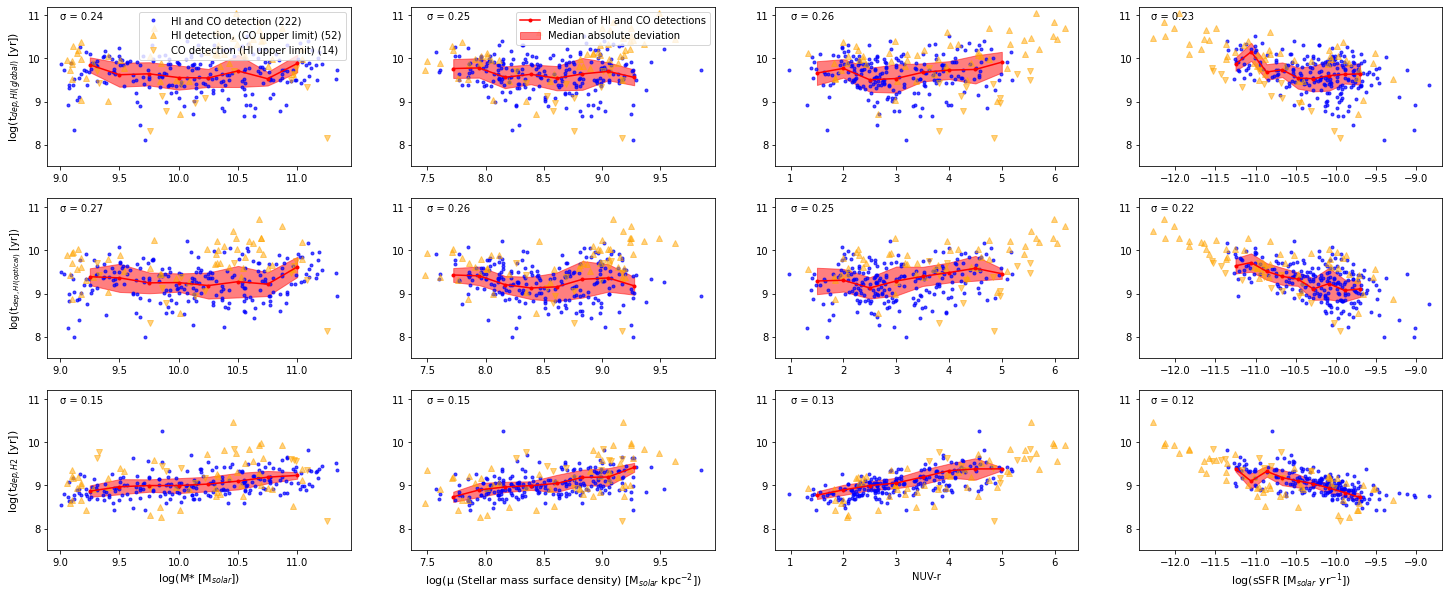

In [37]:
plt.figure(figsize=(25,10))
# Plotting the depletion time for HI(global) mass against stellar properties
# MHI(global) against stellar mass
plt.subplot(3,4,1)
plt.plot(lgMSTAR_det1, lgtdep_HIgl_det1, 'blue', alpha = 0.7, marker='.', linestyle='none', label='HI and CO detection (222)')
plt.plot(lgMSTAR_det3, lgtdep_HIgl_det3, 'orange', alpha = 0.5, marker='^', linestyle='none', label='HI detection, (CO upper limit) (52)')
plt.plot(lgMSTAR_det4, lgtdep_HIgl_det4, 'orange', alpha = 0.5, marker='v', linestyle='none', label='CO detection (HI upper limit) (14)')
plt.ylabel('log(t$_{dep, HI (global)}$ [yr])', fontsize=11)
plt.ylim(7.5, 11.2)
plt.plot(bins_Mstar[1:-1], tdep_HIglmedian_Mstar[1:-1], 'red', marker= '.')
plt.fill_between(bins_Mstar[1:-1], tdep_HIglnMAD_Mstar[1:-1], tdep_HIglpMAD_Mstar[1:-1], color= 'r', alpha = 0.5)
plt.text(9, 10.9, 'σ = %.2f' % ScatHIgl_Mstar)
plt.legend(loc='upper right')

# Depletion time of MHI(global) against stellar surface density
plt.subplot(3,4,2)
plt.plot(lgMuST_det1, lgtdep_HIgl_det1, 'blue', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMuST_det3, lgtdep_HIgl_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det4, lgtdep_HIgl_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_Must[1:-1], tdep_HIglmedian_Must[1:-1], 'red', marker= '.', label='Median of HI and CO detections')
plt.fill_between(bins_Must[1:-1], tdep_HIglnMAD_Must[1:-1], tdep_HIglpMAD_Must[1:-1], color= 'r', alpha = 0.5, label='Median absolute deviation')
plt.text(7.5, 10.9, 'σ = %.2f' % ScatHIgl_Must)
plt.legend(loc='upper right')

# Depletion time of MHI(global) against NUV-r
plt.subplot(3,4,3)
plt.plot(NUVr_det1, lgtdep_HIgl_det1,'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(NUVr_det3, lgtdep_HIgl_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det4, lgtdep_HIgl_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_NUVr[1:-1], tdep_HIglmedian_NUVr[1:-1], 'red', marker= '.')
plt.fill_between(bins_NUVr[1:-1], tdep_HIglnMAD_NUVr[1:-1], tdep_HIglpMAD_NUVr[1:-1], color= 'r', alpha = 0.5)
plt.text(1, 10.9, 'σ = %.2f' % ScatHIgl_NUVr)

# Depletion time of MHI(global) against sSFR
plt.subplot(3,4,4)
plt.plot(lgsSFR_det1, lgtdep_HIgl_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgsSFR_det3, lgtdep_HIgl_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR_det4, lgtdep_HIgl_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_sSFR[:-1], tdep_HIglmedian_sSFR[:-1], 'red', marker= '.')
plt.fill_between(bins_sSFR[:-1], tdep_HIglnMAD_sSFR[:-1], tdep_HIglpMAD_sSFR[:-1], color= 'r', alpha = 0.5)
plt.text(-12.3, 10.9, 'σ = %.2f' % ScatHIgl_sSFR)

# Plotting the depletion time for HI(in) mass against stellar properties
# Depletion time of MHI(in) against stellar mass
plt.subplot(3,4,5)
plt.plot(lgMSTAR_det1, lgtdep_HIin_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMSTAR_det3, lgtdep_HIin_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMSTAR_det4, lgtdep_HIin_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.ylabel('log(t$_{dep, HI(optical)}$ [yr])')
plt.ylim(7.5, 11.2)
plt.plot(bins_Mstar[1:-1], tdep_HIinmedian_Mstar[1:-1], 'red', marker= '.')
plt.fill_between(bins_Mstar[1:-1], tdep_HIinnMAD_Mstar[1:-1], tdep_HIinpMAD_Mstar[1:-1], color= 'r', alpha = 0.5)
plt.text(9, 10.9, 'σ = %.2f' % ScatHIin_Mstar)

# Depletion time of MHI(in) against stellar surface density
plt.subplot(3,4,6)
plt.plot(lgMuST_det1, lgtdep_HIin_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMuST_det3, lgtdep_HIin_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det4, lgtdep_HIin_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_Must[1:-1], tdep_HIinmedian_Must[1:-1], 'red', marker= '.')
plt.fill_between(bins_Must[1:-1], tdep_HIinnMAD_Must[1:-1], tdep_HIinpMAD_Must[1:-1], color= 'r', alpha = 0.5)
plt.text(7.5, 10.9, 'σ = %.2f' % ScatHIin_Must)

# Depletion time of MHI(in) against NUV-r
plt.subplot(3,4,7)
plt.plot(NUVr_det1, lgtdep_HIin_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(NUVr_det3, lgtdep_HIin_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det4, lgtdep_HIin_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_NUVr[1:-1], tdep_HIinmedian_NUVr[1:-1], 'red', marker= '.')
plt.fill_between(bins_NUVr[1:-1], tdep_HIinnMAD_NUVr[1:-1], tdep_HIinpMAD_NUVr[1:-1], color= 'r', alpha = 0.5)
plt.text(1, 10.9, 'σ = %.2f' % ScatHIin_NUVr)

# Depletion time of MHI(in) against sSFR
plt.subplot(3,4,8)
plt.plot(lgsSFR_det1, lgtdep_HIin_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgsSFR_det3, lgtdep_HIin_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR_det4, lgtdep_HIin_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_sSFR[:-1], tdep_HIinmedian_sSFR[:-1], 'red', marker= '.')
plt.fill_between(bins_sSFR[:-1], tdep_HIinnMAD_sSFR[:-1], tdep_HIinpMAD_sSFR[:-1], color= 'r', alpha = 0.5)
plt.text(-12.3, 10.9, 'σ = %.2f' % ScatHIin_sSFR)

# Plotting the depletion time of H2 mass against stellar properties
# Depletion time of MH2 against stellar mass
plt.subplot(3,4,9)
plt.plot(lgMSTAR_det1, lgtdep_H2_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMSTAR_det3, lgtdep_H2_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMSTAR_det4, lgtdep_H2_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.ylabel('log(t$_{dep, H2}$ [yr])', fontsize=11)
plt.xlabel('log(M* [M$_{solar}$])', fontsize=11)
plt.ylim(7.5, 11.2)
plt.plot(bins_Mstar[1:-1], tdep_H2median_Mstar[1:-1], 'red', marker= '.')
plt.fill_between(bins_Mstar[1:-1], tdep_H2nMAD_Mstar[1:-1], tdep_H2pMAD_Mstar[1:-1], color= 'r', alpha = 0.5)
plt.text(9, 10.9, 'σ = %.2f' % ScatH2_Mstar)

# Depletion time of MH2 against stellar surface density
plt.subplot(3,4,10)
plt.plot(lgMuST_det1, lgtdep_H2_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMuST_det3, lgtdep_H2_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det4, lgtdep_H2_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.xlabel('log(μ (Stellar mass surface density) [M$_{solar}$ kpc$^{-2}$])', fontsize=11)
plt.ylim(7.5, 11.2)
plt.plot(bins_Must[1:-1], tdep_H2median_Must[1:-1], 'red', marker= '.')
plt.fill_between(bins_Must[1:-1], tdep_H2nMAD_Must[1:-1], tdep_H2pMAD_Must[1:-1], color= 'r', alpha = 0.5)
plt.text(7.5, 10.9, 'σ = %.2f' % ScatH2_Must)

# Depletion time of MH2 against NUVr
plt.subplot(3,4,11)
plt.plot(NUVr_det1, lgtdep_H2_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(NUVr_det3, lgtdep_H2_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det4, lgtdep_H2_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.xlabel('NUV-r')
plt.ylim(7.5, 11.2)
plt.plot(bins_NUVr[1:-1], tdep_H2median_NUVr[1:-1], 'red', marker= '.')
plt.fill_between(bins_NUVr[1:-1], tdep_H2nMAD_NUVr[1:-1], tdep_H2pMAD_NUVr[1:-1], color= 'r', alpha = 0.5)
plt.text(1, 10.9, 'σ = %.2f' % ScatH2_NUVr)

# Depletion time of MH2 against sSFR
plt.subplot(3,4,12)
plt.plot(lgsSFR_det1, lgtdep_H2_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgsSFR_det3, lgtdep_H2_det3, 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR_det4, lgtdep_H2_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.xlabel('log(sSFR [M$_{solar}$ yr$^{-1}$])', fontsize=11)
plt.ylim(7.5, 11.2)
plt.plot(bins_sSFR[:-1], tdep_H2median_sSFR[:-1], 'red', marker= '.')
plt.fill_between(bins_sSFR[:-1], tdep_H2nMAD_sSFR[:-1], tdep_H2pMAD_sSFR[:-1], color= 'r', alpha = 0.5)
plt.text(-12.3, 10.9, 'σ = %.2f' % ScatH2_sSFR);

In [38]:
# Number of galaxies above 10^10 years depletion time for each Mgas
print(len(np.where(lgtdep_HIgl_det1 > 10)[0]))
print(len(np.where(lgtdep_HIin_det1 > 10)[0]))
print(len(np.where(lgtdep_H2_det1 > 10)[0]))

38
5
1


In [39]:
# Number of galaxies above 10^9 years depletion time for each Mgas
print(len(np.where(lgtdep_HIgl_det1 > 9)[0]))
print(len(np.where(lgtdep_HIin_det1 > 9)[0]))
print(len(np.where(lgtdep_H2_det1 > 9)[0]))

205
165
114


In [40]:
# Number of galaxies above 10^8.5 years depletion time for each Mgas
print(len(np.where(lgtdep_HIgl_det1 > 8.5)[0]))
print(len(np.where(lgtdep_HIin_det1 > 8.5)[0]))
print(len(np.where(lgtdep_H2_det1 > 8.5)[0]))

219
214
219


In [41]:
# Effect of restricting the HI gas mass to the optical region only, the average decrease in log(depletion time)
print(np.mean(lgtdep_HIgl_det1 - lgtdep_HIin_det1))

0.36735959248223743


In [42]:
print(len(lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)]))
print(len(lgtdep_HIgl_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))]))

155
36


7) Changing the depletion time plots to incude how the bulge-to-total ratio changes

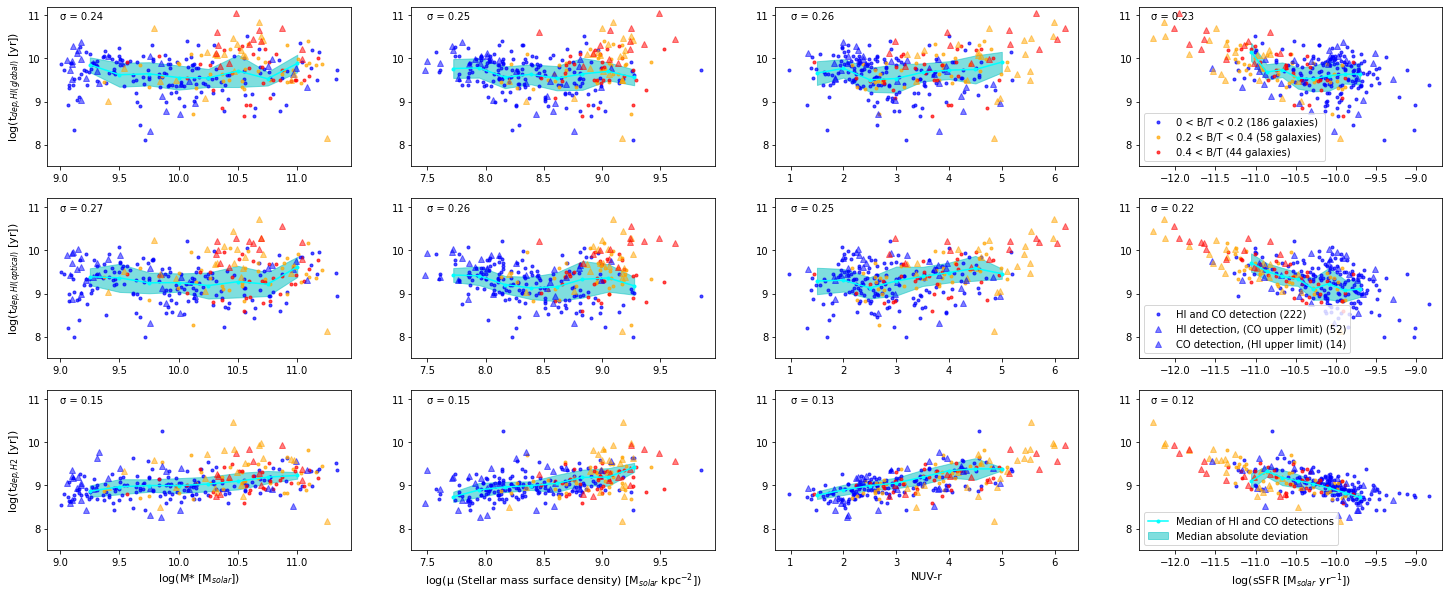

In [43]:
plt.figure(figsize=(25,10))
# Plotting the depletion time for HI(global) mass against stellar properties
# MHI(global) against stellar mass
plt.subplot(3,4,1)
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker='.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIgl_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker='.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIgl_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker='.', linestyle='none')

plt.plot(lgMSTAR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIgl_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker='^', linestyle='none')
plt.plot(lgMSTAR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIgl_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker='^', linestyle='none')
plt.plot(lgMSTAR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIgl_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker='^', linestyle='none')

plt.plot(lgMSTAR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIgl_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker='^', linestyle='none')
plt.plot(lgMSTAR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIgl_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker='^', linestyle='none')
plt.plot(lgMSTAR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIgl_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker='^', linestyle='none')

plt.ylabel('log(t$_{dep, HI (global)}$ [yr])', fontsize=11)
plt.ylim(7.5, 11.2)

plt.plot(bins_Mstar[1:-1], tdep_HIglmedian_Mstar[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_Mstar[1:-1], tdep_HIglnMAD_Mstar[1:-1], tdep_HIglpMAD_Mstar[1:-1], color= 'c', alpha = 0.5)
plt.text(9, 10.9, 'σ = %.2f' % ScatHIgl_Mstar)

# Depletion time of MHI(global) against stellar surface density
plt.subplot(3,4,2)
plt.plot(lgMuST_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMuST_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIgl_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMuST_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIgl_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgMuST_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIgl_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIgl_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIgl_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker= '^', linestyle='none')

plt.plot(lgMuST_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIgl_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIgl_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIgl_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker= '^', linestyle='none')

plt.ylim(7.5, 11.2)

plt.plot(bins_Must[1:-1], tdep_HIglmedian_Must[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_Must[1:-1], tdep_HIglnMAD_Must[1:-1], tdep_HIglpMAD_Must[1:-1], color= 'c', alpha = 0.5)
plt.text(7.5, 10.9, 'σ = %.2f' % ScatHIgl_Must)


# Depletion time of MHI(global) against NUV-r
plt.subplot(3,4,3)
plt.plot(NUVr_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)],'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(NUVr_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIgl_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(NUVr_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIgl_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(NUVr_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIgl_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIgl_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIgl_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker= '^', linestyle='none')

plt.plot(NUVr_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIgl_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIgl_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIgl_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker= '^', linestyle='none')

plt.ylim(7.5, 11.2)

plt.plot(bins_NUVr[1:-1], tdep_HIglmedian_NUVr[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_NUVr[1:-1], tdep_HIglnMAD_NUVr[1:-1], tdep_HIglpMAD_NUVr[1:-1], color= 'c', alpha = 0.5)
plt.text(1, 10.9, 'σ = %.2f' % ScatHIgl_NUVr)


# Depletion time of MHI(global) against sSFR
plt.subplot(3,4,4)
plt.plot(lgsSFR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none', label= '0 < B/T < 0.2 (186 galaxies)')
plt.plot(lgsSFR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIgl_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none', label= '0.2 < B/T < 0.4 (58 galaxies)')
plt.plot(lgsSFR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIgl_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none', label= '0.4 < B/T (44 galaxies)')

plt.plot(lgsSFR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIgl_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIgl_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIgl_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker= '^', linestyle='none')

plt.plot(lgsSFR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIgl_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIgl_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIgl_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker= '^', linestyle='none')

plt.ylim(7.5, 11.2)

plt.plot(bins_sSFR[1:-1], tdep_HIglmedian_sSFR[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_sSFR[1:-1], tdep_HIglnMAD_sSFR[1:-1], tdep_HIglpMAD_sSFR[1:-1], color= 'c', alpha = 0.5)
plt.text(-12.3, 10.9, 'σ = %.2f' % ScatHIgl_sSFR)
plt.legend(loc='lower left')

# Plotting the depletion time for HI(in) mass against stellar properties
# Depletion time of MHI(in) against stellar mass
plt.subplot(3,4,5)
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIin_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIin_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgMSTAR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIin_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMSTAR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIin_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgMSTAR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIin_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(lgMSTAR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIin_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMSTAR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIin_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgMSTAR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIin_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.ylabel('log(t$_{dep, HI(optical)}$ [yr])', fontsize=11)
plt.ylim(7.5, 11.2)

plt.plot(bins_Mstar[1:-1], tdep_HIinmedian_Mstar[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_Mstar[1:-1], tdep_HIinnMAD_Mstar[1:-1], tdep_HIinpMAD_Mstar[1:-1], color= 'c', alpha = 0.5)
plt.text(9, 10.9, 'σ = %.2f' % ScatHIin_Mstar)

# Depletion time of MHI(in) against stellar surface density
plt.subplot(3,4,6)
plt.plot(lgMuST_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMuST_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIin_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMuST_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIin_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgMuST_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIin_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIin_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgMuST_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIin_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(lgMuST_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIin_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIin_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgMuST_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIin_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.ylim(7.5, 11.2)

plt.plot(bins_Must[1:-1], tdep_HIinmedian_Must[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_Must[1:-1], tdep_HIinnMAD_Must[1:-1], tdep_HIinpMAD_Must[1:-1], color= 'c', alpha = 0.5)
plt.text(7.5, 10.9, 'σ = %.2f' % ScatHIin_Must)

# Depletion time of MHI(in) against NUV-r
plt.subplot(3,4,7)
plt.plot(NUVr_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(NUVr_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIin_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(NUVr_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIin_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(NUVr_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIin_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIin_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(NUVr_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIin_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(NUVr_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIin_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIin_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(NUVr_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIin_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.ylim(7.5, 11.2)

plt.plot(bins_NUVr[1:-1], tdep_HIinmedian_NUVr[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_NUVr[1:-1], tdep_HIinnMAD_NUVr[1:-1], tdep_HIinpMAD_NUVr[1:-1], color= 'c', alpha = 0.5)
plt.text(1, 10.9, 'σ = %.2f' % ScatHIin_NUVr)

# Depletion time of MHI(in) against sSFR
plt.subplot(3,4,8)
plt.plot(lgsSFR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none', label='HI and CO detection (222)')
plt.plot(lgsSFR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIin_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgsSFR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIin_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgsSFR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIin_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none', label='HI detection, (CO upper limit) (52)')
plt.plot(lgsSFR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIin_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgsSFR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIin_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(lgsSFR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIin_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none', label='CO detection, (HI upper limit) (14)')
plt.plot(lgsSFR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIin_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgsSFR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIin_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.ylim(7.5, 11.2)

plt.plot(bins_sSFR[1:-1], tdep_HIinmedian_sSFR[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_sSFR[1:-1], tdep_HIinnMAD_sSFR[1:-1], tdep_HIinpMAD_sSFR[1:-1], color= 'c', alpha = 0.5)
plt.text(-12.3, 10.9, 'σ = %.2f' % ScatHIin_sSFR)
plt.legend(loc='lower left')

# Plotting the depletion time of H2 mass against stellar properties
# Depletion time of MH2 against stellar mass
plt.subplot(3,4,9)
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgMSTAR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMSTAR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgMSTAR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(lgMSTAR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMSTAR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgMSTAR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.ylabel('log(t$_{dep, H2}$ [yr])', fontsize=11)
plt.xlabel('log(M* [M$_{solar}$])', fontsize=11)
plt.ylim(7.5, 11.2)

plt.plot(bins_Mstar[1:-1], tdep_H2median_Mstar[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_Mstar[1:-1], tdep_H2nMAD_Mstar[1:-1], tdep_H2pMAD_Mstar[1:-1], color= 'c', alpha = 0.5)
plt.text(9, 10.9, 'σ = %.2f' % ScatH2_Mstar)

# Depletion time of MH2 against stellar surface density
plt.subplot(3,4,10)
plt.plot(lgMuST_det1[np.where(B2TM_det1 < 0.2)], lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMuST_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMuST_det1[np.where(B2TM_det1 > 0.4)], lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgMuST_det3[np.where(B2TM_det3 < 0.2)], lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgMuST_det3[np.where(B2TM_det3 > 0.4)], lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(lgMuST_det4[np.where(B2TM_det4 < 0.2)], lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgMuST_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgMuST_det4[np.where(B2TM_det4 > 0.4)], lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.xlabel('log(μ (Stellar mass surface density) [M$_{solar}$ kpc$^{-2}$])', fontsize=11)
plt.ylim(7.5, 11.2)

plt.plot(bins_Must[1:-1], tdep_H2median_Must[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_Must[1:-1], tdep_H2nMAD_Must[1:-1], tdep_H2pMAD_Must[1:-1], color= 'c', alpha = 0.5)
plt.text(7.5, 10.9, 'σ = %.2f' % ScatH2_Must)

# Depletion time of MH2 against NUVr
plt.subplot(3,4,11)
plt.plot(NUVr_det1[np.where(B2TM_det1 < 0.2)], lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(NUVr_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(NUVr_det1[np.where(B2TM_det1 > 0.4)], lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(NUVr_det3[np.where(B2TM_det3 < 0.2)], lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(NUVr_det3[np.where(B2TM_det3 > 0.4)], lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(NUVr_det4[np.where(B2TM_det4 < 0.2)], lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(NUVr_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(NUVr_det4[np.where(B2TM_det4 > 0.4)], lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.xlabel('NUV-r', fontsize=11)
plt.ylim(7.5, 11.2)

plt.plot(bins_NUVr[1:-1], tdep_H2median_NUVr[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_NUVr[1:-1], tdep_H2nMAD_NUVr[1:-1], tdep_H2pMAD_NUVr[1:-1], color= 'c', alpha = 0.5)
plt.text(1, 10.9, 'σ = %.2f' % ScatH2_NUVr)

# Depletion time of MH2 against sSFR
plt.subplot(3,4,12)
plt.plot(lgsSFR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgsSFR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgsSFR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgsSFR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgsSFR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(lgsSFR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgsSFR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgsSFR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.xlabel('log(sSFR [M$_{solar}$ yr$^{-1}$])', fontsize=11)
plt.ylim(7.5, 11.2)

plt.plot(bins_sSFR[1:-1], tdep_H2median_sSFR[1:-1], 'cyan', marker= '.', label='Median of HI and CO detections')
plt.fill_between(bins_sSFR[1:-1], tdep_H2nMAD_sSFR[1:-1], tdep_H2pMAD_sSFR[1:-1], color= 'c', alpha = 0.5, label='Median absolute deviation')
plt.text(-12.3, 10.9, 'σ = %.2f' % ScatH2_sSFR)
plt.legend(loc='lower left');


8) Removing the points on the above graph and adding a shaded confidence region. Comparing the difference in medians of the total HI + CO detections between the sample of points that are disk dominated and the entire sample.

In [44]:
# Finding the MAD and median lines for the total galaxies is the 231 galaxies listed in the previous plot
# Finding the MAD and median lines for the disk-dominated galaxies only
# Stellar parameters
lgMSTAR_det1_d = lgMSTAR_det1[np.where(B2TM_det1 < 0.2)]
lgMSTAR_det3_d = lgMSTAR_det3[np.where(B2TM_det3 < 0.2)]
lgMSTAR_det4_d = lgMSTAR_det4[np.where(B2TM_det4 < 0.2)]

lgMuST_det1_d = lgMuST_det1[np.where(B2TM_det1 < 0.2)]
lgMuST_det3_d = lgMuST_det3[np.where(B2TM_det3 < 0.2)]
lgMuST_det4_d = lgMuST_det4[np.where(B2TM_det4 < 0.2)]

NUVr_det1_d = NUVr_det1[np.where(B2TM_det1 < 0.2)]
NUVr_det3_d = NUVr_det3[np.where(B2TM_det3 < 0.2)]
NUVr_det4_d = NUVr_det4[np.where(B2TM_det4 < 0.2)]

lgsSFR_det1_d = lgsSFR_det1[np.where(B2TM_det1 < 0.2)]
lgsSFR_det3_d = lgsSFR_det3[np.where(B2TM_det3 < 0.2)]
lgsSFR_det4_d = lgsSFR_det4[np.where(B2TM_det4 < 0.2)]

# Selecting the galaxies (detections only) that are disk dominated
# HI (global)
lgtdep_HIgl_det_d = lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)]
# HI (inner)
lgtdep_HIin_det_d = lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)]
# H2
lgtdep_H2_det_d = lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)]

In [45]:
# Arrays for the bins
bins_Mstar_d = np.linspace(9, 11.25, 10)
bins_NUVr_d = np.linspace(1, 5.5, 10)
bins_sSFR_d = np.linspace(-11.25, -9.5, 10)
bins_Must_d = np.linspace(7.5, 9.5, 10)

# Array of zeroes to store the median of each bin
# Depletion times for HI (global)
tdep_HIglmedian_Mstar_d = np.zeros(len(bins_Mstar_d))
tdep_HIglMAD_Mstar_d = np.zeros(len(bins_Mstar_d))

tdep_HIglmedian_NUVr_d = np.zeros(len(bins_NUVr_d))
tdep_HIglMAD_NUVr_d = np.zeros(len(bins_NUVr_d))

tdep_HIglmedian_sSFR_d = np.zeros(len(bins_sSFR_d))
tdep_HIglMAD_sSFR_d = np.zeros(len(bins_sSFR_d))

tdep_HIglmedian_Must_d = np.zeros(len(bins_Must_d))
tdep_HIglMAD_Must_d = np.zeros(len(bins_Must_d))

# Depletion times for HI (optical)
tdep_HIinmedian_Mstar_d = np.zeros(len(bins_Mstar_d))
tdep_HIinMAD_Mstar_d = np.zeros(len(bins_Mstar_d))

tdep_HIinmedian_NUVr_d = np.zeros(len(bins_NUVr_d))
tdep_HIinMAD_NUVr_d = np.zeros(len(bins_NUVr_d))

tdep_HIinmedian_sSFR_d = np.zeros(len(bins_sSFR_d))
tdep_HIinMAD_sSFR_d = np.zeros(len(bins_sSFR_d))

tdep_HIinmedian_Must_d = np.zeros(len(bins_Must_d))
tdep_HIinMAD_Must_d = np.zeros(len(bins_Must_d))

# Depletion time for H2
tdep_H2median_Mstar_d = np.zeros(len(bins_Mstar_d))
tdep_H2MAD_Mstar_d = np.zeros(len(bins_Mstar_d))

tdep_H2median_NUVr_d = np.zeros(len(bins_NUVr_d))
tdep_H2MAD_NUVr_d = np.zeros(len(bins_NUVr_d))

tdep_H2median_sSFR_d = np.zeros(len(bins_sSFR_d))
tdep_H2MAD_sSFR_d = np.zeros(len(bins_sSFR_d))

tdep_H2median_Must_d = np.zeros(len(bins_Must_d))
tdep_H2MAD_Must_d = np.zeros(len(bins_Must_d))

In [46]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar_d) -1):
  # Depletion time of HI (global) (disk dominated, detections)
  # Median and MAD for the Mstar graph
  tdep_HIglmedian_Mstar_d[i] = np.median(lgtdep_HIgl_det_d[np.where((lgMSTAR_det1_d >= bins_Mstar_d[i]) & (lgMSTAR_det1_d <= bins_Mstar_d[i+1]))])
  tdep_HIglMAD_Mstar_d[i] = stats.median_abs_deviation(lgtdep_HIgl_det_d[np.where((lgMSTAR_det1_d >= bins_Mstar_d[i]) & (lgMSTAR_det1_d <= bins_Mstar_d[i+1]))])

  # Median and MAD for the NUV-r graph
  tdep_HIglmedian_NUVr_d[i] = np.median(lgtdep_HIgl_det_d[np.where((NUVr_det1_d >= bins_NUVr_d[i]) & (NUVr_det1_d <= bins_NUVr_d[i+1]))])
  tdep_HIglMAD_NUVr_d[i] = stats.median_abs_deviation(lgtdep_HIgl_det_d[np.where((NUVr_det1_d >= bins_NUVr_d[i]) & (NUVr_det1_d <= bins_NUVr_d[i+1]))])

  # Median and MAD for the sSFR graph
  tdep_HIglmedian_sSFR_d[i] = np.median(lgtdep_HIgl_det_d[np.where((lgsSFR_det1_d >= bins_sSFR_d[i]) & (lgsSFR_det1_d <= bins_sSFR_d[i+1]))])
  tdep_HIglMAD_sSFR_d[i] = stats.median_abs_deviation(lgtdep_HIgl_det_d[np.where((lgsSFR_det1_d >= bins_sSFR_d[i]) & (lgsSFR_det1_d <= bins_sSFR_d[i+1]))])

  # Median and MAD for the Must graph
  tdep_HIglmedian_Must_d[i] = np.median(lgtdep_HIgl_det_d[np.where((lgMuST_det1_d >= bins_Must_d[i]) & (lgMuST_det1_d <= bins_Must_d[i+1]))])
  tdep_HIglMAD_Must_d[i] = stats.median_abs_deviation(lgtdep_HIgl_det_d[np.where((lgMuST_det1_d >= bins_Must_d[i]) & (lgMuST_det1_d <= bins_Must_d[i+1]))])

  # Depletion time of HI (optical) (disk dominated, detections)
  # Median and MAD for the Mstar graph
  tdep_HIinmedian_Mstar_d[i] = np.median(lgtdep_HIin_det_d[np.where((lgMSTAR_det1_d >= bins_Mstar_d[i]) & (lgMSTAR_det1_d <= bins_Mstar_d[i+1]))])
  tdep_HIinMAD_Mstar_d[i] = stats.median_abs_deviation(lgtdep_HIin_det_d[np.where((lgMSTAR_det1_d >= bins_Mstar_d[i]) & (lgMSTAR_det1_d <= bins_Mstar_d[i+1]))])

  # Median and MAD for the NUV-r graph
  tdep_HIinmedian_NUVr_d[i] = np.median(lgtdep_HIin_det_d[np.where((NUVr_det1_d >= bins_NUVr_d[i]) & (NUVr_det1_d <= bins_NUVr_d[i+1]))])
  tdep_HIinMAD_NUVr_d[i] = stats.median_abs_deviation(lgtdep_HIin_det_d[np.where((NUVr_det1_d >= bins_NUVr_d[i]) & (NUVr_det1_d <= bins_NUVr_d[i+1]))])

  # Median and MAD for the sSFR graph
  tdep_HIinmedian_sSFR_d[i] = np.median(lgtdep_HIin_det_d[np.where((lgsSFR_det1_d >= bins_sSFR_d[i]) & (lgsSFR_det1_d <= bins_sSFR_d[i+1]))])
  tdep_HIinMAD_sSFR_d[i] = stats.median_abs_deviation(lgtdep_HIin_det_d[np.where((lgsSFR_det1_d >= bins_sSFR_d[i]) & (lgsSFR_det1_d <= bins_sSFR_d[i+1]))])
  
  #Median and MAD for the Must graph
  tdep_HIinmedian_Must_d[i] = np.median(lgtdep_HIin_det_d[np.where((lgMuST_det1_d >= bins_Must_d[i]) & (lgMuST_det1_d <= bins_Must_d[i+1]))])
  tdep_HIinMAD_Must_d[i] = stats.median_abs_deviation(lgtdep_HIin_det_d[np.where((lgMuST_det1_d >= bins_Must_d[i]) & (lgMuST_det1_d <= bins_Must_d[i+1]))])
  
  # Depletion time of H2 (disk dominated, detections)
  # Median and MAD for the Mstar graph
  tdep_H2median_Mstar_d[i] = np.median(lgtdep_H2_det_d[np.where((lgMSTAR_det1_d >= bins_Mstar_d[i]) & (lgMSTAR_det1_d <= bins_Mstar_d[i+1]))])
  tdep_H2MAD_Mstar_d[i] = stats.median_abs_deviation(lgtdep_H2_det_d[np.where((lgMSTAR_det1_d >= bins_Mstar_d[i]) & (lgMSTAR_det1_d <= bins_Mstar_d[i+1]))])

  # Median and MAD for the NUV-r graph
  tdep_H2median_NUVr_d[i] = np.median(lgtdep_H2_det_d[np.where((NUVr_det1_d >= bins_NUVr_d[i]) & (NUVr_det1_d <= bins_NUVr_d[i+1]))])
  tdep_H2MAD_NUVr_d[i] = stats.median_abs_deviation(lgtdep_H2_det_d[np.where((NUVr_det1_d >= bins_NUVr_d[i]) & (NUVr_det1_d <= bins_NUVr_d[i+1]))])

  # Median and MAD for the sSFR graph
  tdep_H2median_sSFR_d[i] = np.median(lgtdep_H2_det_d[np.where((lgsSFR_det1_d >= bins_sSFR_d[i]) & (lgsSFR_det1_d <= bins_sSFR_d[i+1]))])
  tdep_H2MAD_sSFR_d[i] = stats.median_abs_deviation(lgtdep_H2_det_d[np.where((lgsSFR_det1_d >= bins_sSFR_d[i]) & (lgsSFR_det1_d <= bins_sSFR_d[i+1]))])
  
  #Median and MAD for the Must graph
  tdep_H2median_Must_d[i] = np.median(lgtdep_H2_det_d[np.where((lgMuST_det1_d >= bins_Must_d[i]) & (lgMuST_det1_d <= bins_Must_d[i+1]))])
  tdep_H2MAD_Must_d[i] = stats.median_abs_deviation(lgtdep_H2_det_d[np.where((lgMuST_det1_d >= bins_Must_d[i]) & (lgMuST_det1_d <= bins_Must_d[i+1]))])

In [47]:
# Working out the upper and lower bounds of the median absolute deviation
# HI (global)
# Mstar graph median bounds
tdep_HIglpMAD_Mstar_d = tdep_HIglmedian_Mstar_d + tdep_HIglMAD_Mstar_d
tdep_HIglnMAD_Mstar_d = tdep_HIglmedian_Mstar_d - tdep_HIglMAD_Mstar_d
# NUV-r graph median bounds
tdep_HIglpMAD_NUVr_d = tdep_HIglmedian_NUVr_d + tdep_HIglMAD_NUVr_d
tdep_HIglnMAD_NUVr_d = tdep_HIglmedian_NUVr_d - tdep_HIglMAD_NUVr_d
# sSFR graph median bounds
tdep_HIglpMAD_sSFR_d = tdep_HIglmedian_sSFR_d + tdep_HIglMAD_sSFR_d
tdep_HIglnMAD_sSFR_d = tdep_HIglmedian_sSFR_d - tdep_HIglMAD_sSFR_d
# Must graph median bounds
tdep_HIglpMAD_Must_d = tdep_HIglmedian_Must_d + tdep_HIglMAD_Must_d
tdep_HIglnMAD_Must_d = tdep_HIglmedian_Must_d - tdep_HIglMAD_Must_d

# HI (optical)
# Mstar graph median bounds
tdep_HIinpMAD_Mstar_d = tdep_HIinmedian_Mstar_d + tdep_HIinMAD_Mstar_d
tdep_HIinnMAD_Mstar_d = tdep_HIinmedian_Mstar_d - tdep_HIinMAD_Mstar_d
# NUV-r graph median bounds
tdep_HIinpMAD_NUVr_d = tdep_HIinmedian_NUVr_d + tdep_HIinMAD_NUVr_d
tdep_HIinnMAD_NUVr_d = tdep_HIinmedian_NUVr_d - tdep_HIinMAD_NUVr_d
# sSFR graph median bounds
tdep_HIinpMAD_sSFR_d = tdep_HIinmedian_sSFR_d + tdep_HIinMAD_sSFR_d
tdep_HIinnMAD_sSFR_d = tdep_HIinmedian_sSFR_d - tdep_HIinMAD_sSFR_d
# Must graph median bounds
tdep_HIinpMAD_Must_d = tdep_HIinmedian_Must_d + tdep_HIinMAD_Must_d
tdep_HIinnMAD_Must_d = tdep_HIinmedian_Must_d - tdep_HIinMAD_Must_d

# H2
# Mstar graph median bounds
tdep_H2pMAD_Mstar_d = tdep_H2median_Mstar_d + tdep_H2MAD_Mstar_d
tdep_H2nMAD_Mstar_d = tdep_H2median_Mstar_d - tdep_H2MAD_Mstar_d
# NUV-r graph median bounds
tdep_H2pMAD_NUVr_d = tdep_H2median_NUVr_d + tdep_H2MAD_NUVr_d
tdep_H2nMAD_NUVr_d = tdep_H2median_NUVr_d - tdep_H2MAD_NUVr_d
# sSFR graph median bounds
tdep_H2pMAD_sSFR_d = tdep_H2median_sSFR_d + tdep_H2MAD_sSFR_d
tdep_H2nMAD_sSFR_d = tdep_H2median_sSFR_d - tdep_H2MAD_sSFR_d
# Must graph median bounds
tdep_H2pMAD_Must_d = tdep_H2median_Must_d + tdep_H2MAD_Must_d
tdep_H2nMAD_Must_d = tdep_H2median_Must_d - tdep_H2MAD_Must_d

In [48]:
# Finding the scatter present between the median lines and MAD for each plot
# Depletion time of HI (global)
ScatHIgl_Mstar_d = np.mean(tdep_HIglMAD_Mstar_d[1:-1])
ScatHIgl_NUVr_d = np.mean(tdep_HIglMAD_NUVr_d[1:-1])
ScatHIgl_sSFR_d = np.mean(tdep_HIglMAD_sSFR_d[:-1])
ScatHIgl_Must_d = np.mean(tdep_HIglMAD_Must_d[1:-1])
# Depletion time of HI (optical)
ScatHIin_Mstar_d = np.mean(tdep_HIinMAD_Mstar_d[1:-1])
ScatHIin_NUVr_d = np.mean(tdep_HIinMAD_NUVr_d[1:-1])
ScatHIin_sSFR_d = np.mean(tdep_HIinMAD_sSFR_d[:-1])
ScatHIin_Must_d = np.mean(tdep_HIinMAD_Must_d[1:-1])
# Depletion time of H2
ScatH2_Mstar_d = np.mean(tdep_H2MAD_Mstar_d[1:-1])
ScatH2_NUVr_d = np.mean(tdep_H2MAD_NUVr_d[1:-1])
ScatH2_sSFR_d = np.mean(tdep_H2MAD_sSFR_d[:-1])
ScatH2_Must_d = np.mean(tdep_H2MAD_Must_d[1:-1])

In [49]:
# Finding the average of the median lines:
# The 'blue' refers to the median of the spirals
# The 'red' refers to the total median the sample, the number is the 'position' of the subplot below
# All the disk dominated galaxies:
blue341 = np.mean(tdep_HIglmedian_Mstar_d)
blue342 = np.mean(tdep_HIglmedian_Must_d)
blue343 = np.mean(tdep_HIglmedian_NUVr_d)
blue344 = np.mean(tdep_HIglmedian_sSFR_d)

blue345 = np.mean(tdep_HIinmedian_Mstar_d)
blue346 = np.mean(tdep_HIinmedian_Must_d)
blue347 = np.mean(tdep_HIinmedian_NUVr_d)
blue348 = np.mean(tdep_HIinmedian_sSFR_d)

blue349 = np.mean(tdep_H2median_Mstar_d)
blue3410 = np.mean(tdep_H2median_Must_d)
blue3411 = np.mean(tdep_H2median_NUVr_d)
blue3412 = np.mean(tdep_H2median_sSFR_d)

blueMstar = np.array([blue341, blue345, blue349])
blueMust = np.array([blue342, blue346, blue3410])
blueNUVr = np.array([blue343, blue347, blue3411])
bluesSFR = np.array([blue344, blue348, blue3412])

# All the galaxies in the sample
red341 = np.mean(tdep_HIglmedian_Mstar)
red342 = np.mean(tdep_HIglmedian_Must)
red343 = np.mean(tdep_HIglmedian_NUVr)
red344 = np.mean(tdep_HIglmedian_sSFR)

red345 = np.mean(tdep_HIinmedian_Mstar)
red346 = np.mean(tdep_HIinmedian_Must)
red347 = np.mean(tdep_HIinmedian_NUVr)
red348 = np.mean(tdep_HIinmedian_sSFR)

red349 = np.mean(tdep_H2median_Mstar)
red3410 = np.mean(tdep_H2median_Must)
red3411 = np.mean(tdep_H2median_NUVr)
red3412 = np.mean(tdep_H2median_sSFR)

redMstar = np.array([red341, red345, red349])
redMust = np.array([red342, red346, red3410])
redNUVr = np.array([red343, red347, red3411])
redsSFR = np.array([red344, red348, red3412])

In [50]:
print(blueMstar, blueMust, blueNUVr, bluesSFR)
print(redMstar, redMust, redNUVr, redsSFR)

[8.70194135 8.32644091 8.0980135 ] [8.65729522 8.25986994 8.11594362] [8.6982234  8.3753674  8.16965275] [8.76814218 8.44460318 8.15579243]
[8.6947186  8.36589724 8.11721621] [8.69181023 8.36476678 8.1222332 ] [8.73163875 8.40781447 8.17637148] [8.74003606 8.41136691 8.16269503]


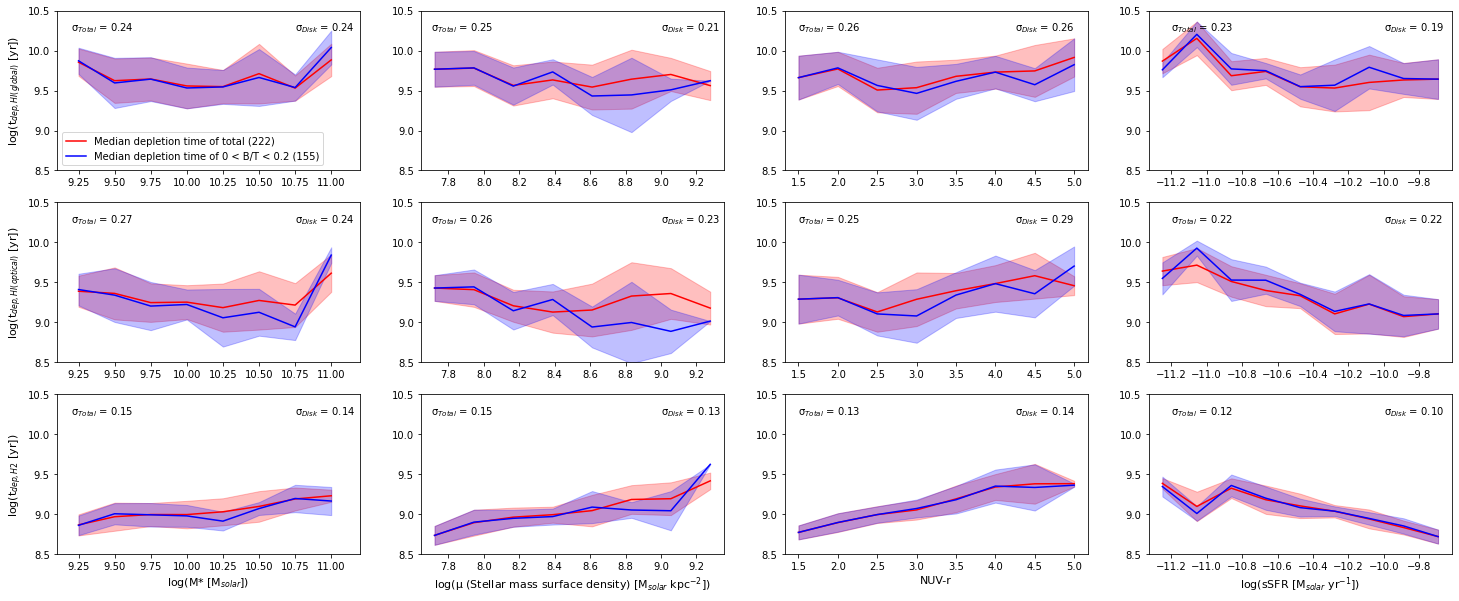

In [51]:
# Plotting the median lines for disk dominated vs the whole sample across four stellar properties
plt.figure(figsize=(25,10))
# Plotting the depletion time for HI(global) mass against stellar properties
# MHI(global) against stellar mass
plt.subplot(3,4,1)
plt.ylim(8.5, 10.5)
plt.xlim(9.1, 11.2)
plt.plot(bins_Mstar[1:-1], tdep_HIglmedian_Mstar[1:-1], 'red', label='Median depletion time of total (222)')
plt.fill_between(bins_Mstar[1:-1], tdep_HIglnMAD_Mstar[1:-1], tdep_HIglpMAD_Mstar[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_Mstar_d[1:-1], tdep_HIglmedian_Mstar_d[1:-1], 'blue', label='Median depletion time of 0 < B/T < 0.2 (155)')
plt.fill_between(bins_Mstar_d[1:-1], tdep_HIglnMAD_Mstar_d[1:-1], tdep_HIglpMAD_Mstar_d[1:-1], color= 'b', alpha = 0.25)
plt.ylabel('log(t$_{dep, HI (global)}$ [yr])', fontsize=11)
plt.text(9.2, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIgl_Mstar)
plt.text(10.75, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIgl_Mstar_d)
plt.legend(loc='lower left')

# Depletion time of MHI(global) against stellar surface density
plt.subplot(3,4,2)
plt.ylim(8.5, 10.5)
plt.plot(bins_Must[1:-1], tdep_HIglmedian_Must[1:-1], 'red')
plt.fill_between(bins_Must[1:-1], tdep_HIglnMAD_Must[1:-1], tdep_HIglpMAD_Must[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_Must_d[1:-1], tdep_HIglmedian_Must_d[1:-1], 'blue')
plt.fill_between(bins_Must_d[1:-1], tdep_HIglnMAD_Must_d[1:-1], tdep_HIglpMAD_Must_d[1:-1], color= 'b', alpha = 0.25)
plt.text(7.7, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIgl_Must)
plt.text(9, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIgl_Must_d)

# Depletion time of MHI(global) against NUV-r
plt.subplot(3,4,3)
plt.ylim(8.5, 10.5)
plt.plot(bins_NUVr[1:-1], tdep_HIglmedian_NUVr[1:-1], 'red')
plt.fill_between(bins_NUVr[1:-1], tdep_HIglnMAD_NUVr[1:-1], tdep_HIglpMAD_NUVr[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_NUVr_d[1:-1], tdep_HIglmedian_NUVr_d[1:-1], 'blue')
plt.fill_between(bins_NUVr_d[1:-1], tdep_HIglnMAD_NUVr_d[1:-1], tdep_HIglpMAD_NUVr_d[1:-1], color= 'b', alpha = 0.25)
plt.text(1.5, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIgl_NUVr)
plt.text(4.25, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIgl_NUVr_d)

# Depletion time of MHI(global) against sSFR
plt.subplot(3,4,4)
plt.ylim(8.5, 10.5)
plt.plot(bins_sSFR[:-1], tdep_HIglmedian_sSFR[:-1], 'red')
plt.fill_between(bins_sSFR[:-1], tdep_HIglnMAD_sSFR[:-1], tdep_HIglpMAD_sSFR[:-1], color= 'r', alpha = 0.25)
plt.plot(bins_sSFR_d[:-1], tdep_HIglmedian_sSFR_d[:-1], 'blue')
plt.fill_between(bins_sSFR_d[:-1], tdep_HIglnMAD_sSFR_d[:-1], tdep_HIglpMAD_sSFR_d[:-1], color= 'b', alpha = 0.25)
plt.text(-11.2, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIgl_sSFR)
plt.text(-10, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIgl_sSFR_d)


# Plotting the depletion time for HI(in) mass against stellar properties
# Depletion time of MHI(in) against stellar mass
plt.subplot(3,4,5)
plt.ylim(8.5, 10.5)
plt.xlim(9.1, 11.2)
plt.ylabel('log(t$_{dep, HI(optical)}$ [yr])', fontsize=11)
plt.plot(bins_Mstar[1:-1], tdep_HIinmedian_Mstar[1:-1], 'red')
plt.fill_between(bins_Mstar[1:-1], tdep_HIinnMAD_Mstar[1:-1], tdep_HIinpMAD_Mstar[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_Mstar_d[1:-1], tdep_HIinmedian_Mstar_d[1:-1], 'blue')
plt.fill_between(bins_Mstar_d[1:-1], tdep_HIinnMAD_Mstar_d[1:-1], tdep_HIinpMAD_Mstar_d[1:-1], color= 'b', alpha = 0.25)
plt.text(9.2, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIin_Mstar)
plt.text(10.75, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIin_Mstar_d)

# Depletion time of MHI(in) against stellar surface density
plt.subplot(3,4,6)
plt.ylim(8.5, 10.5)
plt.plot(bins_Must[1:-1], tdep_HIinmedian_Must[1:-1], 'red')
plt.fill_between(bins_Must[1:-1], tdep_HIinnMAD_Must[1:-1], tdep_HIinpMAD_Must[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_Must_d[1:-1], tdep_HIinmedian_Must_d[1:-1], 'blue')
plt.fill_between(bins_Must_d[1:-1], tdep_HIinnMAD_Must_d[1:-1], tdep_HIinpMAD_Must_d[1:-1], color= 'b', alpha = 0.25)
plt.text(7.7, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIin_Must)
plt.text(9, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIin_Must_d)

# Depletion time of MHI(in) against NUV-r
plt.subplot(3,4,7)
plt.ylim(8.5, 10.5)
plt.plot(bins_NUVr[1:-1], tdep_HIinmedian_NUVr[1:-1], 'red')
plt.fill_between(bins_NUVr[1:-1], tdep_HIinnMAD_NUVr[1:-1], tdep_HIinpMAD_NUVr[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_NUVr_d[1:-1], tdep_HIinmedian_NUVr_d[1:-1], 'blue')
plt.fill_between(bins_NUVr_d[1:-1], tdep_HIinnMAD_NUVr_d[1:-1], tdep_HIinpMAD_NUVr_d[1:-1], color= 'b', alpha = 0.25)
plt.text(1.5, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIin_NUVr)
plt.text(4.25, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIin_NUVr_d)

# Depletion time of MHI(in) against sSFR
plt.subplot(3,4,8)
plt.ylim(8.5, 10.5)
plt.plot(bins_sSFR[:-1], tdep_HIinmedian_sSFR[:-1], 'red')
plt.fill_between(bins_sSFR[:-1], tdep_HIinnMAD_sSFR[:-1], tdep_HIinpMAD_sSFR[:-1], color= 'r', alpha = 0.25)
plt.plot(bins_sSFR_d[:-1], tdep_HIinmedian_sSFR_d[:-1], 'blue')
plt.fill_between(bins_sSFR_d[:-1], tdep_HIinnMAD_sSFR_d[:-1], tdep_HIinpMAD_sSFR_d[:-1], color= 'b', alpha = 0.25)
plt.text(-11.2, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIin_sSFR)
plt.text(-10, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIin_sSFR_d)


# Plotting the depletion time of H2 mass against stellar properties
# Depletion time of MH2 against stellar mass
plt.subplot(3,4,9)
plt.ylim(8.5, 10.5)
plt.xlim(9.1, 11.2)
plt.ylabel('log(t$_{dep, H2}$ [yr])', fontsize=11)
plt.xlabel('log(M* [M$_{solar}$])', fontsize=11)
plt.plot(bins_Mstar[1:-1], tdep_H2median_Mstar[1:-1], 'red')
plt.fill_between(bins_Mstar[1:-1], tdep_H2nMAD_Mstar[1:-1], tdep_H2pMAD_Mstar[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_Mstar_d[1:-1], tdep_H2median_Mstar_d[1:-1], 'blue')
plt.fill_between(bins_Mstar_d[1:-1], tdep_H2nMAD_Mstar_d[1:-1], tdep_H2pMAD_Mstar_d[1:-1], color= 'b', alpha = 0.25)
plt.text(9.2, 10.25, 'σ$_{Total}$ = %.2f' % ScatH2_Mstar)
plt.text(10.75, 10.25, 'σ$_{Disk}$ = %.2f' % ScatH2_Mstar_d)

# Depletion time of MH2 against stellar surface density
plt.subplot(3,4,10)
plt.ylim(8.5, 10.5)
plt.xlabel('log(μ (Stellar mass surface density) [M$_{solar}$ kpc$^{-2}$])', fontsize=11)
plt.plot(bins_Must[1:-1], tdep_H2median_Must[1:-1], 'red')
plt.fill_between(bins_Must[1:-1], tdep_H2nMAD_Must[1:-1], tdep_H2pMAD_Must[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_Must_d[1:-1], tdep_H2median_Must_d[1:-1], 'blue')
plt.fill_between(bins_Must_d[1:-1], tdep_H2nMAD_Must_d[1:-1], tdep_H2pMAD_Must_d[1:-1], color= 'b', alpha = 0.25)
plt.text(7.7, 10.25, 'σ$_{Total}$ = %.2f' % ScatH2_Must)
plt.text(9, 10.25, 'σ$_{Disk}$ = %.2f' % ScatH2_Must_d)

# Depletion time of MH2 against NUVr
plt.subplot(3,4,11)
plt.ylim(8.5, 10.5)
plt.xlabel('NUV-r', fontsize=11)
plt.plot(bins_NUVr[1:-1], tdep_H2median_NUVr[1:-1], 'red')
plt.fill_between(bins_NUVr[1:-1], tdep_H2nMAD_NUVr[1:-1], tdep_H2pMAD_NUVr[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_NUVr_d[1:-1], tdep_H2median_NUVr_d[1:-1], 'blue')
plt.fill_between(bins_NUVr_d[1:-1], tdep_H2nMAD_NUVr_d[1:-1], tdep_H2pMAD_NUVr_d[1:-1], color= 'b', alpha = 0.25)
plt.text(1.5, 10.25, 'σ$_{Total}$ = %.2f' % ScatH2_NUVr)
plt.text(4.25, 10.25, 'σ$_{Disk}$ = %.2f' % ScatH2_NUVr_d)

# Depletion time of MH2 against sSFR
plt.subplot(3,4,12)
plt.ylim(8.5, 10.5)
plt.xlabel('log(sSFR [M$_{solar}$ yr$^{-1}$])', fontsize=11)
plt.plot(bins_sSFR[:-1], tdep_H2median_sSFR[:-1], 'red')
plt.fill_between(bins_sSFR[:-1], tdep_H2nMAD_sSFR[:-1], tdep_H2pMAD_sSFR[:-1], color= 'r', alpha = 0.25)
plt.plot(bins_sSFR_d[:-1], tdep_H2median_sSFR_d[:-1], 'blue')
plt.fill_between(bins_sSFR_d[:-1], tdep_H2nMAD_sSFR_d[:-1], tdep_H2pMAD_sSFR_d[:-1], color= 'b', alpha = 0.25)
plt.text(-11.2, 10.25, 'σ$_{Total}$ = %.2f' % ScatH2_sSFR)
plt.text(-10, 10.25, 'σ$_{Disk}$ = %.2f' % ScatH2_sSFR_d);

9) Comparing the depletion times more directly, looking at the direct correspondance of the H2 to HI (global) and the H2 to HI (optical)

In [52]:
a1 = len(lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)])
b1 = len(lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)])
c1 = len(lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)])
d1 = a1+b1+c1
print('Disk dominated galaxies: %.1f' % d1)
a2 = len(lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))])
b2 = len(lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))])
c2 = len(lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))])
d2 = a2+b2+c2
print('Disk + bulge galaxies: %.1f' % d2)
a3 = len(lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)])
b3 = len(lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)])
c3 = len(lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)])
d3 = a3+b3+c3
print('Prominent bulge galaxies: %.1f' % d3)

Disk dominated galaxies: 186.0
Disk + bulge galaxies: 58.0
Prominent bulge galaxies: 44.0


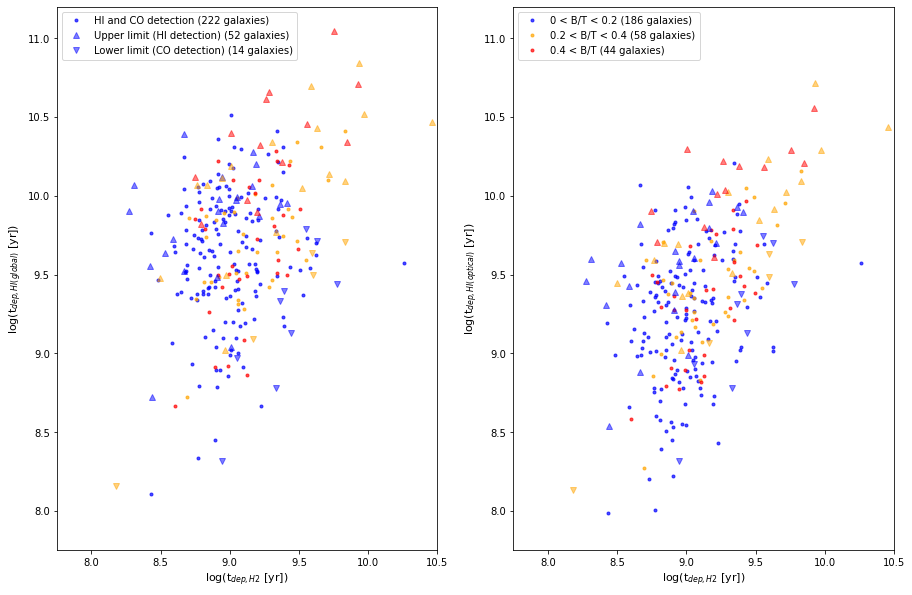

In [53]:
plt.figure(figsize=(15,10))
# Comparing H2 and HI (global)
plt.subplot(1,2,1)
plt.plot(lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none', label='HI and CO detection (222 galaxies)')
plt.plot(lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIgl_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIgl_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIgl_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none', label='Upper limit (HI detection) (52 galaxies)')
plt.plot(lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIgl_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIgl_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIgl_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none', label='Lower limit (CO detection) (14 galaxies)')
plt.plot(lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIgl_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIgl_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.xlabel('log(t$_{dep, H2}$ [yr])', fontsize=11)
plt.ylabel('log(t$_{dep, HI (global)}$ [yr])', fontsize=11)
plt.xlim(7.75, 10.5)
plt.ylim(7.75, 11.2)
plt.legend(loc='upper left')

# Comparing H2 and HI (optical)
plt.subplot(1,2,2)
plt.plot(lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none', label= '0 < B/T < 0.2 (186 galaxies)')
plt.plot(lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIin_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none', label= '0.2 < B/T < 0.4 (58 galaxies)')
plt.plot(lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIin_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none', label= '0.4 < B/T (44 galaxies)')

plt.plot(lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIin_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIin_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIin_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIin_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIin_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIin_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.xlabel('log(t$_{dep, H2}$ [yr])', fontsize=11)
plt.ylabel('log(t$_{dep, HI (optical)}$ [yr])', fontsize=11)
plt.xlim(7.75, 10.5)
plt.ylim(7.75, 11.2)
plt.legend(loc='upper left');

10) Investigating the depletion times of the HI global, optical and H2 when compared to how offset each galaxy is from the star forming main sequence

In [54]:
# As the redshift of all the galaxies in the sample is the local universe, the best fit function used is the one from the
# Catinella and Saintonge (2021) review paper for galaxies 0.01 < z < 0.05
# lgSFR(MS) = 0.412 - log( 1+ [10^logMSTAR / 10^10.59]^-0.718 )

def SFMSfit(lgMstar):
  return 0.412 - np.log10(1+ ((10**lgMstar) / (10**10.59))**-0.718)

lgSFMS_det1 = SFMSfit(lgMSTAR_det1)
lgSFMS_det3 = SFMSfit(lgMSTAR_det3)
lgSFMS_det4 = SFMSfit(lgMSTAR_det4)

# Making an upper and lower bounds of this best fit function (+/- 0.4 dex scatter)
uplgSFMS_det1 = lgSFMS_det1 + 0.4
dwlgSFMS_det1 = lgSFMS_det1 - 0.4

In [55]:
# Finding the main sequence offset: lgSFR_det(1,2,3) - lgSFMS_det(1,2,3) = lgSFMS_off_det(1,2,3)

def SFMS_off(lgSFR, lgSFMS):
  return lgSFR - lgSFMS

lgSFMS_off_det1 = SFMS_off(lgSFRbest_det1, lgSFMS_det1)
lgSFMS_off_det3 = SFMS_off(lgSFRbest_det3, lgSFMS_det3)
lgSFMS_off_det4 = SFMS_off(lgSFRbest_det4, lgSFMS_det4)
print(lgSFMS_off_det1[0:11])
print(lgSFMS_off_det3[0:11])
print(lgSFMS_off_det4[0:11])

[-0.50068384  0.6556864   0.07119545  0.02686121  0.4932023  -0.01537231
  0.2772393  -0.6099923  -0.11088517  0.05626315 -0.6526147 ]
[-0.18450218 -0.21879488 -0.16445452 -1.583161    0.09961253 -0.301803
 -0.8277867  -0.519676   -0.5243863  -0.5875528  -0.39697334]
[ 0.01695168 -1.0939667  -0.24416992 -0.71570283 -0.6889664  -0.8065466
 -0.34092876 -0.20675188 -0.78641135 -0.64825404  1.0268173 ]


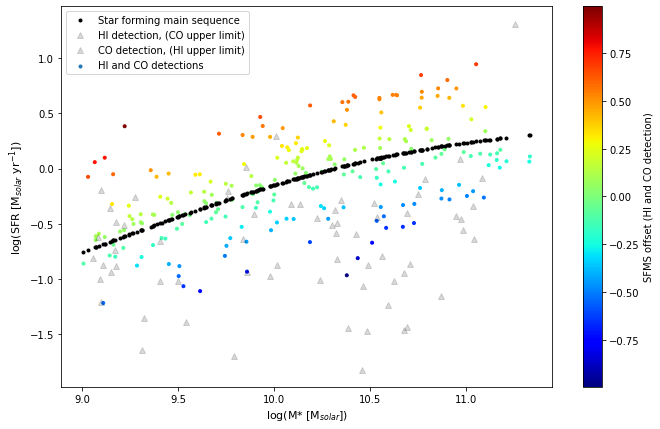

In [56]:
# Plotting a scatter plot with colourbar to reflect the offset of the data from the SFMS
plt.figure(figsize=(11,7))
plt.plot(lgMSTAR_det1, lgSFMS_det1, 'black', marker='.', linestyle='none', label='Star forming main sequence')
plt.scatter(lgMSTAR_det1, lgSFRbest_det1, c=lgSFMS_off_det1, cmap='jet', marker= '.', label='HI and CO detections')
plt.colorbar(label='SFMS offset (HI and CO detection)', orientation='vertical')
plt.plot(lgMSTAR_det3, lgSFRbest_det3, 'black', marker='^', linestyle='none', alpha=0.15, label='HI detection, (CO upper limit)')
plt.plot(lgMSTAR_det4, lgSFRbest_det4, 'black', marker='^', linestyle='none', alpha=0.15, label='CO detection, (HI upper limit)')
plt.legend(loc='upper left')
plt.xlabel('log(M* [M$_{solar}$])', fontsize=11)
plt.ylabel('log(SFR [M$_{solar}$ yr$^{-1}$])', fontsize=11);

In [57]:
# Using the specific star forming main sequence (sSFMS) from the xGASS paper (2018)

MSTAR_det1 = 10**lgMSTAR_det1
MSTAR_det3 = 10**lgMSTAR_det3
MSTAR_det4 = 10**lgMSTAR_det4

def sSFMSfit(Mstar):
  return -0.344*(np.log10(Mstar) -9) - 9.822

lgsSFMS_det1 = sSFMSfit(MSTAR_det1)
lgsSFMS_det3 = sSFMSfit(MSTAR_det3)
lgsSFMS_det4 = sSFMSfit(MSTAR_det4)

# Making an upper and lower bounds of this best fit function
def sigma_sSFMS(Mstar):
  return 0.088*(np.log10(Mstar) -9) + 0.188
uplgsSFMS_det1 = lgsSFMS_det1 + sigma_sSFMS(MSTAR_det1)
dwlgsSFMS_det1 = lgsSFMS_det1 - sigma_sSFMS(MSTAR_det1)

print(uplgsSFMS_det1[0:11])
print(lgsSFMS_det1[0:11])
print(dwlgsSFMS_det1[0:11])

[ -9.824668   -9.871887   -9.712513   -9.932752   -9.901775   -9.833935
  -9.909968   -9.9381275  -9.848188   -9.690197  -10.0768795]
[-10.07821  -10.141662  -9.927502 -10.223448 -10.181824 -10.090662
 -10.192832 -10.230672 -10.109816  -9.897515 -10.417119]
[-10.331752 -10.411436 -10.14249  -10.514144 -10.461872 -10.347389
 -10.475696 -10.523216 -10.371443 -10.104834 -10.757359]


In [58]:
# Finding the main sequence offset: lgSFR_det(1,2,3) - lgSFMS_det(1,2,3) = lgSFMS_off_det(1,2,3)

def sSFMS_off(lgsSFR, lgsSFMS):
  return lgsSFR - lgsSFMS

lgsSFMS_off_det1 = sSFMS_off(lgsSFR_det1, lgsSFMS_det1)
lgsSFMS_off_det3 = sSFMS_off(lgsSFR_det3, lgsSFMS_det3)
lgsSFMS_off_det4 = sSFMS_off(lgsSFR_det4, lgsSFMS_det4)
lgsSFMS_off_dw = sSFMS_off(lgsSFR_det1, dwlgsSFMS_det1)
lgsSFMS_off_up = sSFMS_off(lgsSFR_det1, uplgsSFMS_det1)

print(np.mean(lgsSFMS_off_det1))
print(np.mean(lgsSFMS_off_dw))
print(np.mean(lgsSFMS_off_up))

-0.018455459
0.26947728
-0.30638817


In [59]:
# Fitting a line to the SFMS
x = lgMSTAR_det1
p = np.linspace(min(lgMSTAR_det1), max(lgMSTAR_det1), 100)
y1 = lgsSFMS_det1
def linfun(x, m, c): 
    return m*x + c
popt1, pcov1 = curve_fit(linfun, x, y1)
# Fitting a line to the SFMS upper limit
y2 = uplgsSFMS_det1
def linfun(x, m, c): 
    return m*x + c
popt2, pcov2 = curve_fit(linfun, x, y2)
# Fitting a line to the SFMS lower limit
y3 = dwlgsSFMS_det1
def linfun(x, m, c): 
    return m*x + c
popt3, pcov3 = curve_fit(linfun, x, y3)

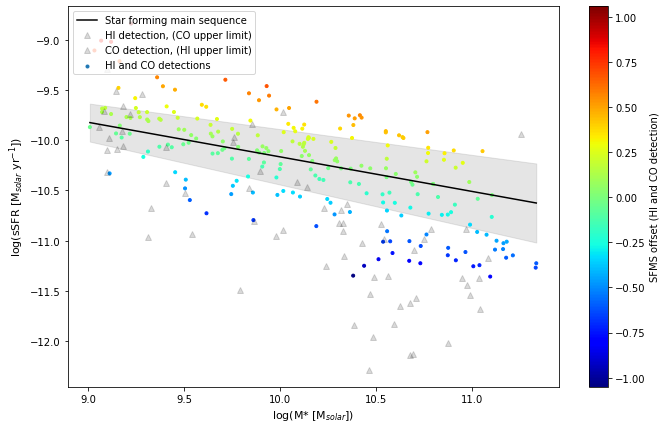

In [60]:
# Plotting a scatter plot with colourbar to reflect the offset of the data from the SFMS
plt.figure(figsize=(11,7))
plt.plot(p, linfun(p, *popt1), 'k-', label='Star forming main sequence')
plt.fill_between(p, linfun(p, *popt3), linfun(p, *popt2), color='grey', alpha = 0.2)
plt.scatter(lgMSTAR_det1, lgsSFR_det1, c=lgsSFMS_off_det1, cmap='jet', marker= '.', label='HI and CO detections')
plt.colorbar(label='SFMS offset (HI and CO detection)', orientation='vertical')
plt.plot(lgMSTAR_det3, lgsSFR_det3, 'black', marker='^', linestyle='none', alpha=0.15, label='HI detection, (CO upper limit)')
plt.plot(lgMSTAR_det4, lgsSFR_det4, 'black', marker='^', linestyle='none', alpha=0.15, label='CO detection, (HI upper limit)')
plt.legend(loc='upper left')
plt.xlabel('log(M* [M$_{solar}$])', fontsize=11)
plt.ylabel('log(sSFR [M$_{solar}$ yr$^{-1}$])', fontsize=11);

11) Using the offset from the specific star forming main sequence with the depletion times to investigate the larger scatter seen by the HI when restricted to the optical region

In [61]:
# Finding the running median of the galaxies for H2
# Arrays for the bins
SFMSbins = np.linspace(-0.75, 0.75, 7)

# Array of zeroes to store the median of each bin
SFMS_HIgl_median = np.zeros(len(SFMSbins))
SFMS_HIgl_MAD = np.zeros(len(SFMSbins))

SFMS_HIin_median = np.zeros(len(SFMSbins))
SFMS_HIin_MAD = np.zeros(len(SFMSbins))

SFMS_H2_median = np.zeros(len(SFMSbins))
SFMS_H2_MAD = np.zeros(len(SFMSbins))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(SFMSbins) -1):
  # Median and MAD for the SFMS of t(dep) for MHI (global)
  SFMS_HIgl_median[i] = np.median(lgtdep_HIgl_det1[np.where((lgsSFMS_off_det1 >= SFMSbins[i]) & (lgsSFMS_off_det1 <= SFMSbins[i+1]))])
  SFMS_HIgl_MAD[i] = stats.median_abs_deviation(lgtdep_HIgl_det1[np.where((lgsSFMS_off_det1 >= SFMSbins[i]) & (lgsSFMS_off_det1 <= SFMSbins[i+1]))])

  # Median and MAD for the SFMS of t(dep) for MHI (optical)
  SFMS_HIin_median[i] = np.median(lgtdep_HIin_det1[np.where((lgsSFMS_off_det1 >= SFMSbins[i]) & (lgsSFMS_off_det1 <= SFMSbins[i+1]))])
  SFMS_HIin_MAD[i] = stats.median_abs_deviation(lgtdep_HIin_det1[np.where((lgsSFMS_off_det1 >= SFMSbins[i]) & (lgsSFMS_off_det1 <= SFMSbins[i+1]))])

  # Median and MAD for the SFMS of t(dep) for MH2
  SFMS_H2_median[i] = np.median(lgtdep_H2_det1[np.where((lgsSFMS_off_det1 >= SFMSbins[i]) & (lgsSFMS_off_det1 <= SFMSbins[i+1]))])
  SFMS_H2_MAD[i] = stats.median_abs_deviation(lgtdep_H2_det1[np.where((lgsSFMS_off_det1 >= SFMSbins[i]) & (lgsSFMS_off_det1 <= SFMSbins[i+1]))])

# Working out the upper and lower bounds of the median absolute deviation
SFMS_HIgl_pMAD = SFMS_HIgl_median + SFMS_HIgl_MAD
SFMS_HIgl_nMAD = SFMS_HIgl_median - SFMS_HIgl_MAD

SFMS_HIin_pMAD = SFMS_HIin_median + SFMS_HIin_MAD
SFMS_HIin_nMAD = SFMS_HIin_median - SFMS_HIin_MAD

SFMS_H2_pMAD = SFMS_H2_median + SFMS_H2_MAD
SFMS_H2_nMAD = SFMS_H2_median - SFMS_H2_MAD

In [62]:
# Finding the scatter present between the median lines and MAD for each plot
# For HI (global)
ScatHIgl_SFMS = np.mean(SFMS_HIgl_MAD[:-1])
# For HI (optical)
ScatHIin_SFMS = np.mean(SFMS_HIin_MAD[:-1])
# For H2
ScatH2_SFMS = np.mean(SFMS_H2_MAD[:-1])

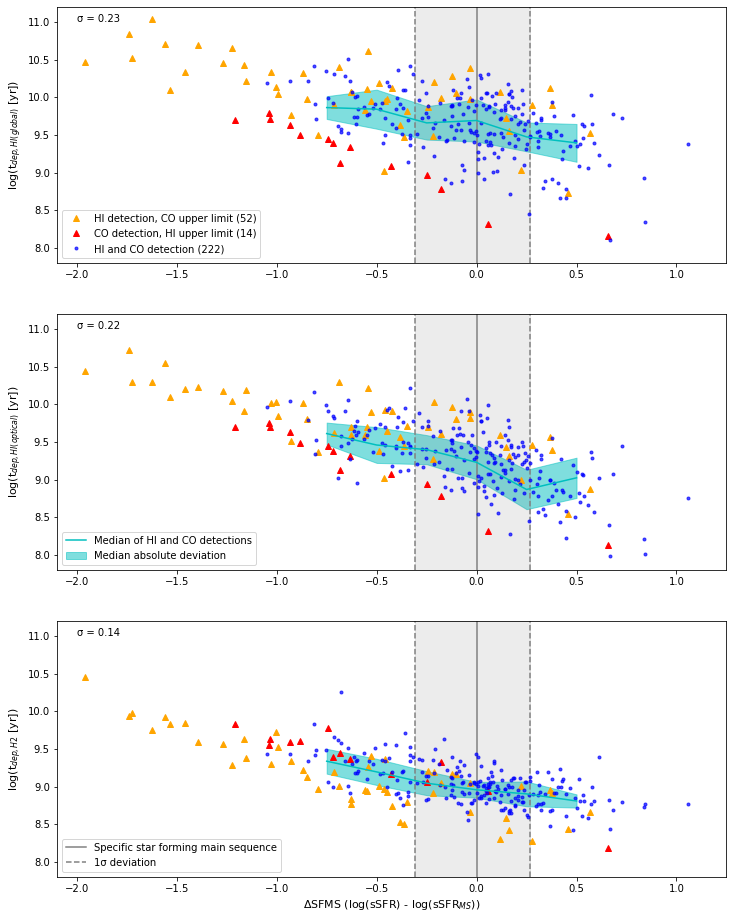

In [63]:
# Plotting the delta SFMS (x-axis) against the three depletion times for each gas
plt.figure(figsize=(12,16))
# For t(dep) MHI (global)
plt.subplot(3,1,1)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIgl_det3, 'orange', marker='^', linestyle='none', label='HI detection, CO upper limit (52)')
plt.plot(lgsSFMS_off_det4, lgtdep_HIgl_det4, 'red', marker='^', linestyle='none', label='CO detection, HI upper limit (14)')
plt.plot(lgsSFMS_off_det1, lgtdep_HIgl_det1, 'blue', marker='.', linestyle='none', label='HI and CO detection (222)', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIgl_median[:-1], 'c-')
plt.fill_between(SFMSbins[:-1], SFMS_HIgl_nMAD[:-1], SFMS_HIgl_pMAD[:-1], color= 'c', alpha = 0.5)

plt.ylabel('log(t$_{dep, HI (global)}$ [yr])', fontsize=11)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatHIgl_SFMS)
plt.legend(loc='lower left')

# For t(dep) MHI (optical)
plt.subplot(3,1,2)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIin_det3, 'orange', marker='^', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_HIin_det4, 'red', marker='^', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_HIin_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIin_median[:-1], 'c-', label='Median of HI and CO detections')
plt.fill_between(SFMSbins[:-1], SFMS_HIin_nMAD[:-1], SFMS_HIin_pMAD[:-1], color= 'c', alpha = 0.5, label='Median absolute deviation')

plt.ylabel('log(t$_{dep, HI (optical)}$ [yr])', fontsize=11)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatHIin_SFMS)
plt.legend(loc='lower left')

# For t(dep) MH2
plt.subplot(3,1,3)
plt.axvline(x=0, color='grey', linestyle='-', label='Specific star forming main sequence')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--', label='1σ deviation') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_H2_det3, 'orange', marker='^', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_H2_det4, 'red', marker='^', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_H2_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_H2_median[:-1], 'c-')
plt.fill_between(SFMSbins[:-1], SFMS_H2_nMAD[:-1], SFMS_H2_pMAD[:-1], color= 'c', alpha = 0.5)

plt.ylabel('log(t$_{dep, H2}$ [yr])', fontsize=11)
plt.ylim(7.8, 11.2)
plt.xlabel('ΔSFMS (log(sSFR) - log(sSFR$_{MS}$))', fontsize=11)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatH2_SFMS)
plt.legend(loc='lower left');

12) Investigating any unusual galaxies within the depletion time plots

In [64]:
print(len(np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)[0]))

69


In [65]:
# Creating a subsection of the data that holds to the above condition that MH2 > MHI (optical region)
strange_gal_HIgl = lgtdep_HIgl_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)]
strange_gal_HIin = lgtdep_HIin_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)]
strange_gal_H2 = lgtdep_H2_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)]
strange_sSFMS_off = lgsSFMS_off_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)]
strange_sSFMS = lgsSFMS_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)]
strange_lgMSTAR = lgMSTAR_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)]
strange_sSFR = lgsSFR_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)]

In [66]:
print(len(np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)[0]))

20


In [67]:
# Creating a subsection that holds to the above condition that MH2 > MHI (global)
stranger_gal_HIgl = lgtdep_HIgl_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)]
stranger_gal_HIin = lgtdep_HIin_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)]
stranger_gal_H2 = lgtdep_H2_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)]
stranger_sSFMS_off = lgsSFMS_off_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)]
strangre_sSFMS = lgsSFMS_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)]
stranger_lgMSTAR = lgMSTAR_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)]
stranger_sSFR = lgsSFR_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)]

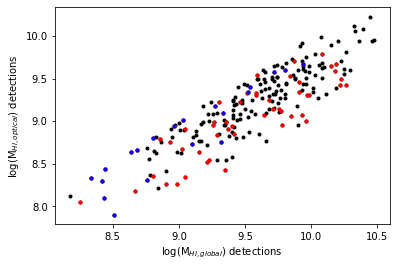

In [68]:
plt.plot(lgMHI_gl_det1, lgMHI_in_det1, 'k.')
plt.plot(lgMHI_gl_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)], lgMHI_in_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)], 'r.')
plt.plot(lgMHI_gl_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)], lgMHI_in_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)], 'b.')
plt.xlabel('log(M$_{HI, global}$) detections')
plt.ylabel('log(M$_{HI, optical}$) detections');

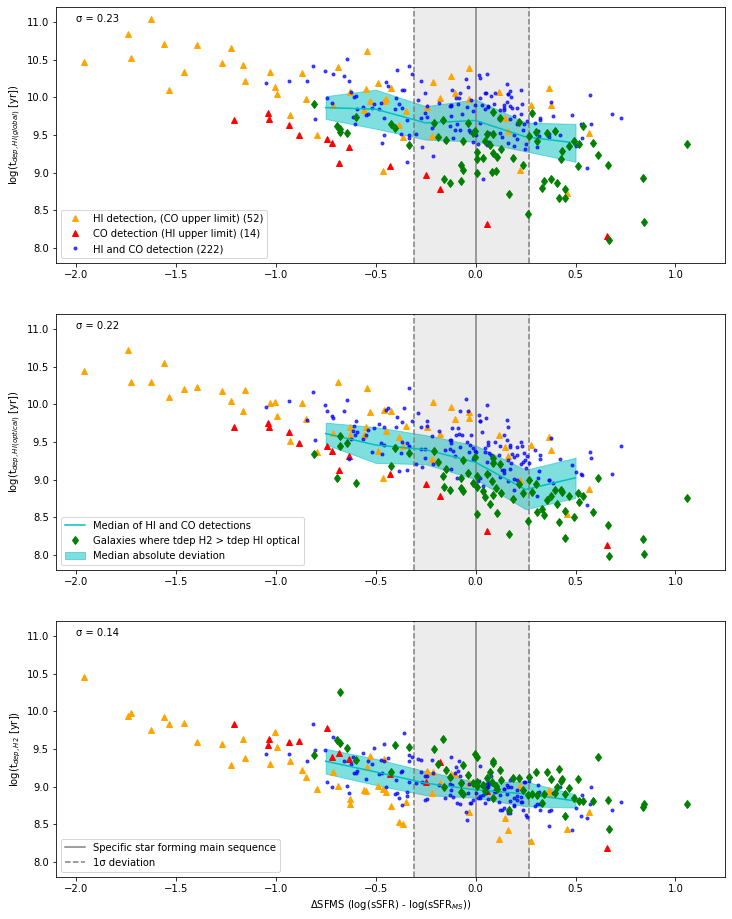

In [69]:
# Plotting the delta SFMS (x-axis) against the three depletion times for each gas
plt.figure(figsize=(12,16))
# For t(dep) MHI (global)
plt.subplot(3,1,1)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIgl_det3, 'orange', marker='^', linestyle='none', label='HI detection, (CO upper limit) (52)')
plt.plot(lgsSFMS_off_det4, lgtdep_HIgl_det4, 'red', marker='^', linestyle='none', label='CO detection (HI upper limit) (14)')
plt.plot(lgsSFMS_off_det1, lgtdep_HIgl_det1, 'blue', marker='.', linestyle='none', label='HI and CO detection (222)', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIgl_median[:-1], 'c-')
plt.fill_between(SFMSbins[:-1], SFMS_HIgl_nMAD[:-1], SFMS_HIgl_pMAD[:-1], color= 'c', alpha = 0.5)
plt.plot(strange_sSFMS_off, strange_gal_HIgl, color='green', marker='d', linestyle='none')

plt.ylabel('log(t$_{dep, HI (global)}$ [yr])')
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatHIgl_SFMS)
plt.legend(loc='lower left')

# For t(dep) MHI (optical)
plt.subplot(3,1,2)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIin_det3, 'orange', marker='^', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_HIin_det4, 'red', marker='^', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_HIin_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIin_median[:-1], 'c-', label='Median of HI and CO detections')
plt.fill_between(SFMSbins[:-1], SFMS_HIin_nMAD[:-1], SFMS_HIin_pMAD[:-1], color= 'c', alpha = 0.5, label='Median absolute deviation')
plt.plot(strange_sSFMS_off, strange_gal_HIin, color='green', marker='d', linestyle='none', label='Galaxies where tdep H2 > tdep HI optical')

plt.ylabel('log(t$_{dep, HI (optical)}$ [yr])')
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatHIin_SFMS)
plt.legend(loc='lower left')

# For t(dep) MH2
plt.subplot(3,1,3)
plt.axvline(x=0, color='grey', linestyle='-', label='Specific star forming main sequence')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--', label='1σ deviation') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_H2_det3, 'orange', marker='^', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_H2_det4, 'red', marker='^', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_H2_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_H2_median[:-1], 'c-')
plt.fill_between(SFMSbins[:-1], SFMS_H2_nMAD[:-1], SFMS_H2_pMAD[:-1], color= 'c', alpha = 0.5)
plt.plot(strange_sSFMS_off, strange_gal_H2, color='green', marker='d', linestyle='none')

plt.ylabel('log(t$_{dep, H2}$ [yr])')
plt.ylim(7.8, 11.2)
plt.xlabel('ΔSFMS (log(sSFR) - log(sSFR$_{MS}$))')
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatH2_SFMS)
plt.legend(loc='lower left');

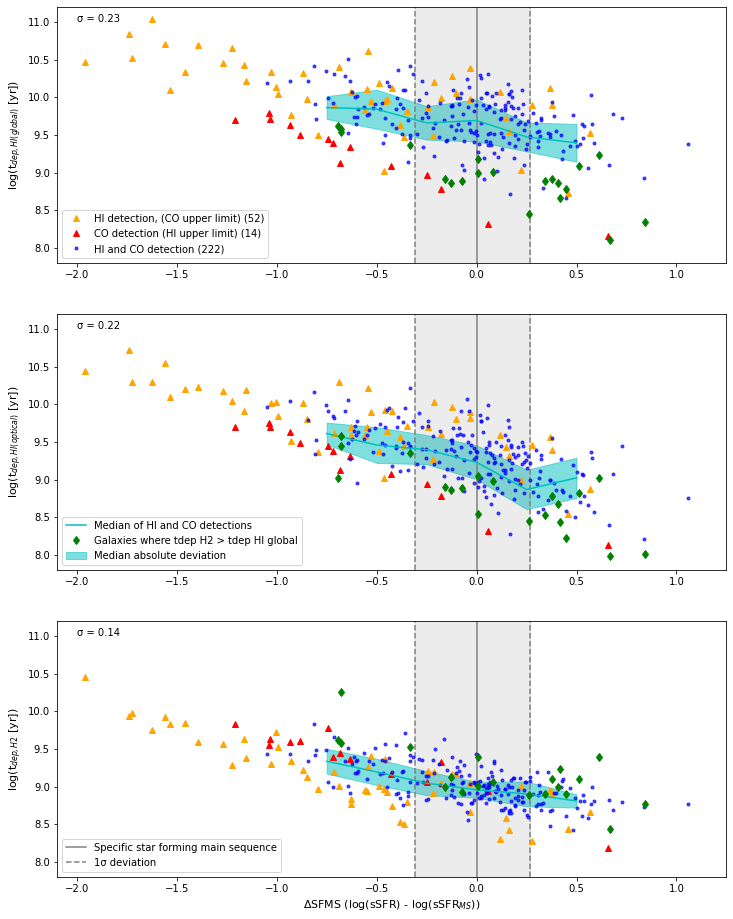

In [70]:
# Plotting the delta SFMS (x-axis) against the three depletion times for each gas
plt.figure(figsize=(12,16))
# For t(dep) MHI (global)
plt.subplot(3,1,1)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIgl_det3, 'orange', marker='^', linestyle='none', label='HI detection, (CO upper limit) (52)')
plt.plot(lgsSFMS_off_det4, lgtdep_HIgl_det4, 'red', marker='^', linestyle='none', label='CO detection (HI upper limit) (14)')
plt.plot(lgsSFMS_off_det1, lgtdep_HIgl_det1, 'blue', marker='.', linestyle='none', label='HI and CO detection (222)', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIgl_median[:-1], 'c-')
plt.fill_between(SFMSbins[:-1], SFMS_HIgl_nMAD[:-1], SFMS_HIgl_pMAD[:-1], color= 'c', alpha = 0.5)
plt.plot(stranger_sSFMS_off, stranger_gal_HIgl, color='green', marker='d', linestyle='none')

plt.ylabel('log(t$_{dep, HI (global)}$ [yr])', fontsize=11)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatHIgl_SFMS)
plt.legend(loc='lower left')

# For t(dep) MHI (optical)
plt.subplot(3,1,2)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIin_det3, 'orange', marker='^', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_HIin_det4, 'red', marker='^', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_HIin_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIin_median[:-1], 'c-', label='Median of HI and CO detections')
plt.fill_between(SFMSbins[:-1], SFMS_HIin_nMAD[:-1], SFMS_HIin_pMAD[:-1], color= 'c', alpha = 0.5, label='Median absolute deviation')
plt.plot(stranger_sSFMS_off, stranger_gal_HIin, color='green', marker='d', linestyle='none', label='Galaxies where tdep H2 > tdep HI global')

plt.ylabel('log(t$_{dep, HI (optical)}$ [yr])', fontsize=11)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatHIin_SFMS)
plt.legend(loc='lower left')

# For t(dep) MH2
plt.subplot(3,1,3)
plt.axvline(x=0, color='grey', linestyle='-', label='Specific star forming main sequence')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--', label='1σ deviation') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_H2_det3, 'orange', marker='^', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_H2_det4, 'red', marker='^', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_H2_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_H2_median[:-1], 'c-')
plt.fill_between(SFMSbins[:-1], SFMS_H2_nMAD[:-1], SFMS_H2_pMAD[:-1], color= 'c', alpha = 0.5)
plt.plot(stranger_sSFMS_off, stranger_gal_H2, color='green', marker='d', linestyle='none')

plt.ylabel('log(t$_{dep, H2}$ [yr])', fontsize=11)
plt.ylim(7.8, 11.2)
plt.xlabel('ΔSFMS (log(sSFR) - log(sSFR$_{MS}$))', fontsize=11)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatH2_SFMS)
plt.legend(loc='lower left');

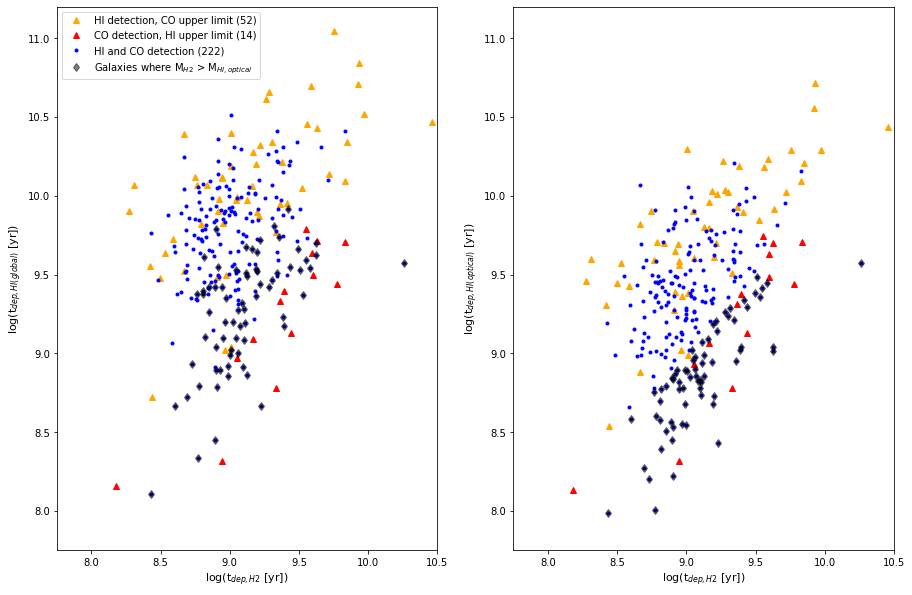

In [71]:
# Looking at the relationship between the depletion times of MH2, MHI(global) and MHI(optical)
# Highlighting the cases where the depletion times and therefore the masses of H2 are greater than the mass (and depletion time) of optical HI
plt.figure(figsize=(15,10))
strange_tdepH2 = lgtdep_H2_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)]
strange_tdepHIgl = lgtdep_HIgl_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)]
strange_tdepHIin = lgtdep_HIin_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)]

# Comparing H2 and HI (global)
plt.subplot(1,2,1)
plt.plot(lgtdep_H2_det3, lgtdep_HIgl_det3, 'orange', marker='^', linestyle='none', label='HI detection, CO upper limit (52)')
plt.plot(lgtdep_H2_det4, lgtdep_HIgl_det4, 'red', marker='^', linestyle='none', label='CO detection, HI upper limit (14)')
plt.plot(lgtdep_H2_det1, lgtdep_HIgl_det1, 'blue', marker='.', linestyle='none', label='HI and CO detection (222)')
plt.plot(strange_tdepH2, strange_tdepHIgl, 'black', marker='d', linestyle='none', label='Galaxies where M$_{H2}$ > M$_{HI, optical}$', alpha=0.5)

plt.xlabel('log(t$_{dep, H2}$ [yr])', fontsize=11)
plt.ylabel('log(t$_{dep, HI (global)}$ [yr])', fontsize=11)
plt.xlim(7.75, 10.5)
plt.ylim(7.75, 11.2)
plt.legend(loc='upper left')

# Comparing H2 and HI (optical)
plt.subplot(1,2,2)
plt.plot(lgtdep_H2_det3, lgtdep_HIin_det3, 'orange', marker='^', linestyle='none')
plt.plot(lgtdep_H2_det4, lgtdep_HIin_det4, 'red', marker='^', linestyle='none')
plt.plot(lgtdep_H2_det1, lgtdep_HIin_det1, 'blue', marker='.', linestyle='none')
plt.plot(strange_tdepH2, strange_tdepHIin, 'black', marker='d', linestyle='none', alpha=0.5)

plt.xlabel('log(t$_{dep, H2}$ [yr])', fontsize=11)
plt.ylabel('log(t$_{dep, HI (optical)}$ [yr])', fontsize=11)
plt.xlim(7.75, 10.5)
plt.ylim(7.75, 11.2);

In [72]:
# Looking at the relationship between the depletion times of MH2, MHI(global) and MHI(optical)
stranger_tdepH2 = lgtdep_H2_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)]
stranger_tdepHIgl = lgtdep_HIgl_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)]
stranger_tdepHIin = lgtdep_HIin_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)]

In [73]:
x1 = lgtdep_H2_det1
p1 = np.linspace(min(x1), max(x1), 100)
y1 = lgtdep_HIgl_det1
def linfun(x, m, c): 
    return m*x + c
p01 = np.array([])
popt1, pcov1 = curve_fit(linfun, x1, y1)

In [74]:
x2 = lgtdep_H2_det1
p2 = np.linspace(min(x2), max(x2), 100)
y2 = lgtdep_HIin_det1
def linfun(x, m, c): 
    return m*x + c
p02 = np.array([])
popt2, pcov2 = curve_fit(linfun, x2, y2)

Gradient:  0.3622569696069813 +/- 0.09722045060213819
Gradient:  0.5599728815491876 +/- 0.0956391038760063


(7.75, 11.2)

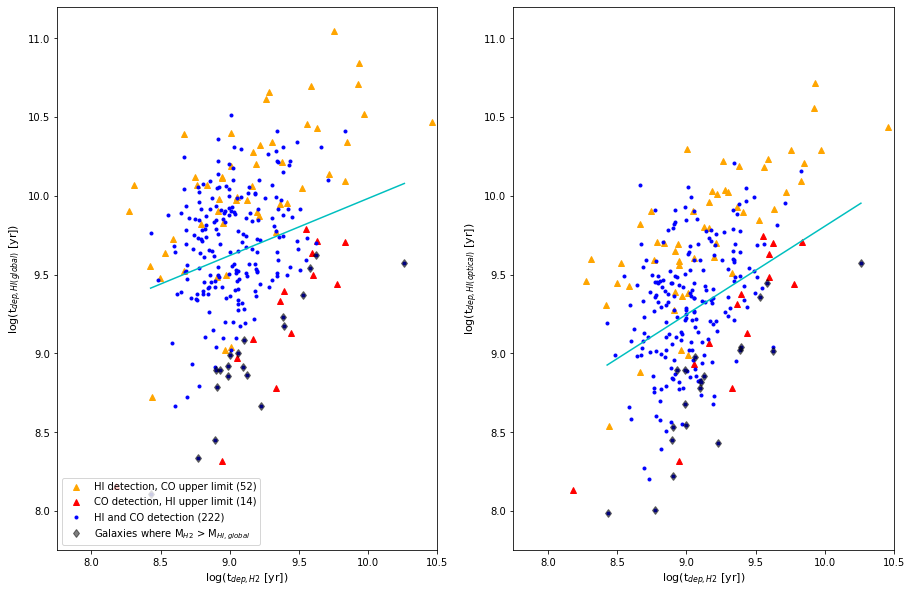

In [75]:
# Highlighting the cases where the depletion times and therefore the masses of H2 are greater than the mass (and depletion time) of global HI
plt.figure(figsize=(15,10))
# Comparing H2 and HI (global)
plt.subplot(1,2,1)
plt.plot(lgtdep_H2_det3, lgtdep_HIgl_det3, 'orange', marker='^', linestyle='none', label='HI detection, CO upper limit (52)')
plt.plot(lgtdep_H2_det4, lgtdep_HIgl_det4, 'red', marker='^', linestyle='none', label='CO detection, HI upper limit (14)')
plt.plot(lgtdep_H2_det1, lgtdep_HIgl_det1, 'blue', marker='.', linestyle='none', label='HI and CO detection (222)')
plt.plot(stranger_tdepH2, stranger_tdepHIgl, 'black', marker='d', linestyle='none', label='Galaxies where M$_{H2}$ > M$_{HI, global}$', alpha=0.5)

#plt.plot(H2HIbins[:-1], H2HIgl_median[:-1], 'c-')
#plt.fill_between(H2HIbins[:-1], H2HIgl_nMAD[:-1], H2HIgl_pMAD[:-1], color= 'c', alpha = 0.5)
plt.plot(p1, linfun(p1, *popt1), 'c-')
print ('Gradient: ', popt1[0], '+/-', np.sqrt(pcov1.diagonal()[0])) ;

plt.xlabel('log(t$_{dep, H2}$ [yr])', fontsize=11)
plt.ylabel('log(t$_{dep, HI (global)}$ [yr])', fontsize=11)
plt.xlim(7.75, 10.5)
plt.ylim(7.75, 11.2)
plt.legend(loc='lower left')
#plt.text(8, 11, 'σ = %.2f' % Scat_H2HIgl)

# Comparing H2 and HI (optical)
plt.subplot(1,2,2)
plt.plot(lgtdep_H2_det3, lgtdep_HIin_det3, 'orange', marker='^', linestyle='none')
plt.plot(lgtdep_H2_det4, lgtdep_HIin_det4, 'red', marker='^', linestyle='none')
plt.plot(lgtdep_H2_det1, lgtdep_HIin_det1, 'blue', marker='.', linestyle='none')
plt.plot(stranger_tdepH2, stranger_tdepHIin, 'black', marker='d', linestyle='none', alpha=0.5)

#plt.plot(H2HIbins[:-1], H2HIin_median[:-1], 'c-')
#plt.fill_between(H2HIbins[:-1], H2HIin_nMAD[:-1], H2HIin_pMAD[:-1], color= 'c', alpha = 0.5)
plt.plot(p2, linfun(p2, *popt2), 'c-')
print ('Gradient: ', popt2[0], '+/-', np.sqrt(pcov2.diagonal()[0])) ;

plt.xlabel('log(t$_{dep, H2}$ [yr])', fontsize=11)
plt.ylabel('log(t$_{dep, HI (optical)}$ [yr])', fontsize=11)
plt.xlim(7.75, 10.5)
plt.ylim(7.75, 11.2)
#plt.text(8, 11, 'σ = %.2f' % Scat_H2HIin);

In [76]:
print(len(np.where(lgMH2_det1 > lgMHI_gl_det1)[0]))

20


13) Investigating the surface density of the HI inside the optical region

In [77]:
# Finding the surface density of the HI inside the optical region
# We assume the surface density to be calculated as a 2D 'area'
# 'Reff_kpc' so we need convert it into parsecs
Reff_pc_det1 = (Reff_kpc_det1*1000)
Reff_pc_det3 = (Reff_kpc_det3*1000)
Reff_pc_det4 = (Reff_kpc_det4*1000)

Reff_area_det1 = np.pi*(Reff_pc_det1**2)
Reff_area_det3 = np.pi*(Reff_pc_det3**2)
Reff_area_det4 = np.pi*(Reff_pc_det4**2)

sigma_HIin_det1 = (10**lgMHI_in_det1) / Reff_area_det1
sigma_HIin_det3 = (10**lgMHI_in_det3) / Reff_area_det3
sigma_HIin_det4 = (10**lgMHI_in_det4) / Reff_area_det4

print(sigma_HIin_det1[0:11])
print((10**lgMHI_in_det1)[0:11])
print(Reff_area_det1[0:11])

[ 3.05740063  8.09106586  6.54438415  6.50606447  5.50230147  5.13466153
 15.34694576  7.69543907  4.61523117  6.78804723  8.02245008]
[8.03732417e+08 3.52920802e+09 4.40132216e+08 6.47973007e+09
 2.96613405e+09 3.13913673e+09 1.00702076e+09 7.43221837e+08
 1.20165894e+09 5.85750936e+08 7.02340427e+08]
[2.62880961e+08 4.36185798e+08 6.72534201e+07 9.95952330e+08
 5.39071526e+08 6.11361959e+08 6.56170145e+07 9.65795234e+07
 2.60368094e+08 8.62915234e+07 8.75468740e+07]


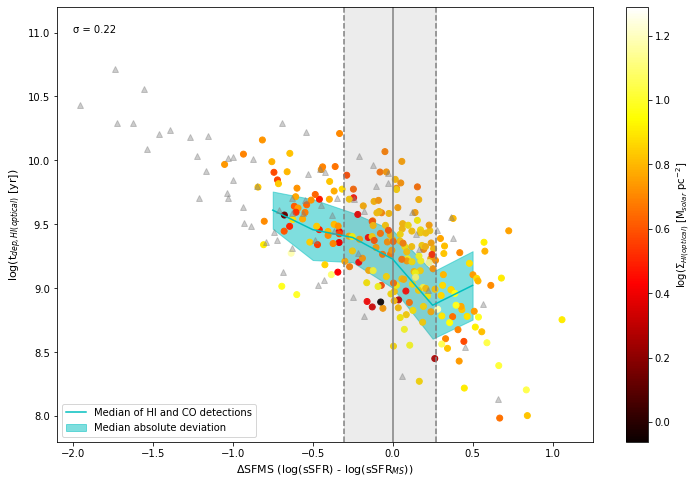

In [78]:
# Plotting the tdepletion time against SFMS offset for HI inside the optical region
# with the detections coloured by surface density
plt.figure(figsize=(12,8))
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')
plt.plot(SFMSbins[:-1], SFMS_HIin_median[:-1], 'c-', label='Median of HI and CO detections')
plt.fill_between(SFMSbins[:-1], SFMS_HIin_nMAD[:-1], SFMS_HIin_pMAD[:-1], color= 'c', alpha = 0.5, label='Median absolute deviation')

plt.scatter(lgsSFMS_off_det1, lgtdep_HIin_det1, c = np.log10(sigma_HIin_det1), cmap = 'hot')
plt.plot(lgsSFMS_off_det3, lgtdep_HIin_det3, 'grey', marker='^', linestyle='none', alpha=0.4)
plt.plot(lgsSFMS_off_det4, lgtdep_HIin_det4, 'grey', marker='^', linestyle='none', alpha=0.4)
plt.colorbar(label='log(Σ$_{HI (optical)}$ [M$_{solar}$ pc$^{-2}$]', orientation='vertical')

plt.ylabel('log(t$_{dep, HI (optical)}$ [yr])', fontsize=11)
plt.xlabel('ΔSFMS (log(sSFR) - log(sSFR$_{MS}$))', fontsize=11)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatHIin_SFMS)
plt.legend(loc='lower left');

14) Looking at the surface density of M(cold gas), the sum of MHI and MH2

In [79]:
# If we define the total cold gas of a galaxy as the sum of MHI and MH2, we can find the surface density of Mcold
# Since we use R (optical) to find the surface area of the galaxy we will define M(cold, optical) = MHI(optical) + MH2
# M (cold gas)
Mcold_opt_det1 = (10**lgMHI_in_det1) + (10**lgMH2_det1)
Mcold_opt_det3 = (10**lgMHI_in_det3) + (10**lgMH2_det3)
Mcold_opt_det4 = (10**lgMHI_in_det4) + (10**lgMH2_det4)
# Finding the log
lgMcold_opt_det1 = np.log10(Mcold_opt_det1)
lgMcold_opt_det3 = np.log10(Mcold_opt_det3)
lgMcold_opt_det4 = np.log10(Mcold_opt_det4)

# Converting M(cold, optical) in surface density
sigma_cold_det1 = (Mcold_opt_det1) / Reff_area_det1
sigma_cold_det3 = (Mcold_opt_det3) / Reff_area_det3
sigma_cold_det4 = (Mcold_opt_det4) / Reff_area_det4

In [80]:
# Calculating the depletion times of Mcold (optical)
lgtdep_cold_det1 = np.log10(Mcold_opt_det1 / ((10**lgsSFR_det1) * (10**lgMSTAR_det1)))
lgtdep_cold_det3 = np.log10(Mcold_opt_det3 / ((10**lgsSFR_det3) * (10**lgMSTAR_det3)))
lgtdep_cold_det4 = np.log10(Mcold_opt_det4 / ((10**lgsSFR_det4) * (10**lgMSTAR_det4)))

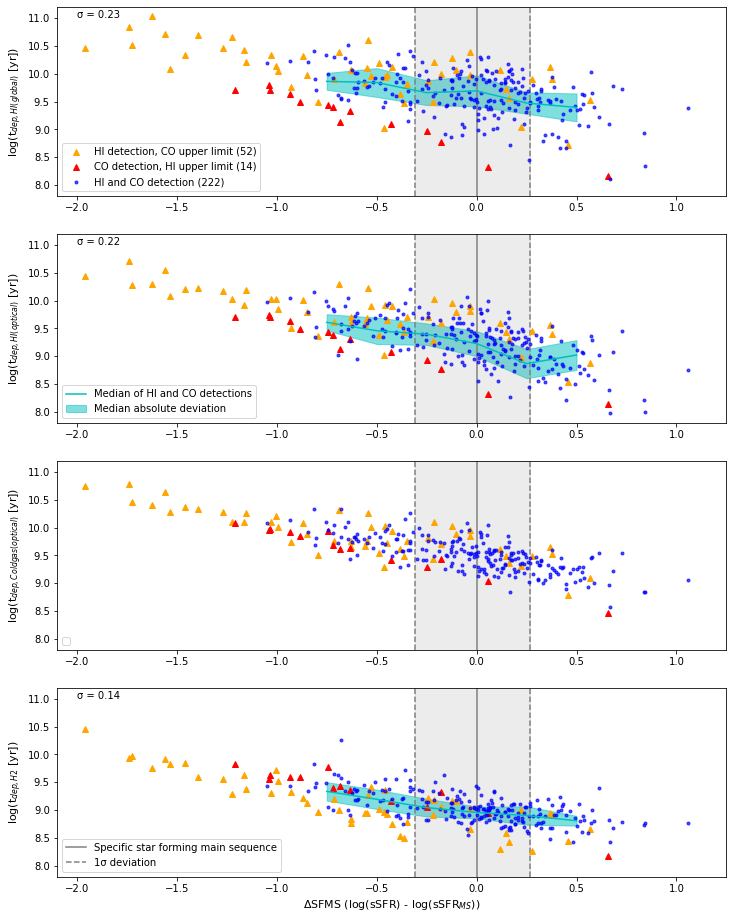

In [82]:
# Plotting the delta SFMS (x-axis) against the three depletion times for each gas
plt.figure(figsize=(12,16))
# For t(dep) MHI (global)
plt.subplot(4,1,1)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIgl_det3, 'orange', marker='^', linestyle='none', label='HI detection, CO upper limit (52)')
plt.plot(lgsSFMS_off_det4, lgtdep_HIgl_det4, 'red', marker='^', linestyle='none', label='CO detection, HI upper limit (14)')
plt.plot(lgsSFMS_off_det1, lgtdep_HIgl_det1, 'blue', marker='.', linestyle='none', label='HI and CO detection (222)', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIgl_median[:-1], 'c-')
plt.fill_between(SFMSbins[:-1], SFMS_HIgl_nMAD[:-1], SFMS_HIgl_pMAD[:-1], color= 'c', alpha = 0.5)

plt.ylabel('log(t$_{dep, HI (global)}$ [yr])', fontsize=11)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatHIgl_SFMS)
plt.legend(loc='lower left')

# For t(dep) MHI (optical)
plt.subplot(4,1,2)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIin_det3, 'orange', marker='^', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_HIin_det4, 'red', marker='^', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_HIin_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIin_median[:-1], 'c-', label='Median of HI and CO detections')
plt.fill_between(SFMSbins[:-1], SFMS_HIin_nMAD[:-1], SFMS_HIin_pMAD[:-1], color= 'c', alpha = 0.5, label='Median absolute deviation')

plt.ylabel('log(t$_{dep, HI (optical)}$ [yr])', fontsize=11)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatHIin_SFMS)
plt.legend(loc='lower left')

# For t(dep) Mcold
plt.subplot(4,1,3)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_cold_det3, 'orange', marker='^', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_cold_det4, 'red', marker='^', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_cold_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

#plt.plot(SFMSbins[:-1], SFMS_HIin_median[:-1], 'c-', label='Median of HI and CO detections')
#plt.fill_between(SFMSbins[:-1], SFMS_HIin_nMAD[:-1], SFMS_HIin_pMAD[:-1], color= 'c', alpha = 0.5, label='Median absolute deviation')

plt.ylabel('log(t$_{dep, Cold gas, (optical)}$ [yr])', fontsize=11)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
#plt.text(-2, 11, 'σ = %.2f' % ScatHIin_SFMS)
plt.legend(loc='lower left')

# For t(dep) MH2
plt.subplot(4,1,4)
plt.axvline(x=0, color='grey', linestyle='-', label='Specific star forming main sequence')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--', label='1σ deviation') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_H2_det3, 'orange', marker='^', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_H2_det4, 'red', marker='^', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_H2_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_H2_median[:-1], 'c-')
plt.fill_between(SFMSbins[:-1], SFMS_H2_nMAD[:-1], SFMS_H2_pMAD[:-1], color= 'c', alpha = 0.5)

plt.ylabel('log(t$_{dep, H2}$ [yr])', fontsize=11)
plt.ylim(7.8, 11.2)
plt.xlabel('ΔSFMS (log(sSFR) - log(sSFR$_{MS}$))', fontsize=11)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatH2_SFMS)
plt.legend(loc='lower left');

15) Writing an output file with some of the key data for the galaxies with larger MHI (optical) depletion times than MH2 depletion times

In [ ]:
low_H2HIGASS = GASS_det1[np.where(lgMH2_det1 > lgMHI_gl_det1)]
low_H2HIRA = RA_det1[np.where(lgMH2_det1 > lgMHI_gl_det1)]
low_H2HIDEC = DEC_det1[np.where(lgMH2_det1 > lgMHI_gl_det1)]

In [ ]:
#np.savetxt('low_HIdepletion_times.txt', np.c_[low_GASS, low_RA, low_DEC, strange_gal_HIgl, strange_gal_HIin, strange_gal_H2], header='GASSID  RA  DEC HIgl  HIin  H2',fmt='%s', delimiter='\t')

In [ ]:
#np.savetxt('low_H2HIgldepletion_coords.txt', np.c_[low_H2HIGASS, low_H2HIRA, low_H2HIDEC], header='GASSID  RA  DEC',fmt='%s', delimiter='\t')